In [1]:
import requests
import pandas as pd
from datetime import datetime

class s:
    def __init__(self, api_key="H8CHNTUNAGZKISTS"):
        """
        Initialize the Alpha Vantage API wrapper
        """
        self.api_key = api_key
        self.base_url = "https://www.alphavantage.co/query"

    # ---------------------------------------------------
    # 1. Get historical stock price data
    # ---------------------------------------------------
    def get_stock_time_series(self, symbol, interval='daily', outputsize='full'):
        """
        Fetch historical stock price data
        """
        function = f"TIME_SERIES_{interval.upper()}"

        params = {
            'function': function,
            'symbol': symbol,
            'apikey': self.api_key,
            'outputsize': outputsize
        }

        response = requests.get(self.base_url, params=params)
        data = response.json()

        if "Error Message" in data:
            raise Exception(f"API Error: {data['Error Message']}")

        # Detect correct key
        key_map = {
            'daily': "Time Series (Daily)",
            'weekly': "Weekly Time Series",
            'monthly': "Monthly Time Series"
        }
        time_series_key = key_map.get(interval.lower(), None)

        if time_series_key not in data:
            raise Exception("No time series data found in API response")

        # Convert to DataFrame
        df = pd.DataFrame.from_dict(data[time_series_key], orient="index")

        # Clean column names
        df.columns = [col.split(". ")[1] for col in df.columns]

        # Convert all columns to numeric
        df = df.apply(pd.to_numeric)

        # Reset index
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        
        return df

    # ---------------------------------------------------
    # 2. Get news sentiment data
    # ---------------------------------------------------
    def get_news_sentiment(self, symbol, topics="blockchain,earnings"):
        """
        Fetch news sentiment from Alpha Vantage
        """
        params = {
            'function': 'NEWS_SENTIMENT',
            'tickers': symbol,
            'topics': topics,
            'apikey': self.api_key
        }

        response = requests.get(self.base_url, params=params)
        data = response.json()

        # No feed found
        if "feed" not in data or len(data["feed"]) == 0:
            print("⚠️ No news feed returned for this ticker.")
            return pd.DataFrame()

        rows = []

        for item in data['feed']:
            row = {}

            # safely extract published time
            if "time_published" in item:
                try:
                    row['time_published'] = pd.to_datetime(item['time_published'])
                except:
                    row['time_published'] = None
            else:
                row['time_published'] = None

            # safely extract other fields
            row['title'] = item.get('title', None)
            row['sentiment_score'] = float(item.get('overall_sentiment_score', 0))
            row['sentiment_label'] = item.get('overall_sentiment_label', None)

            rows.append(row)

        df = pd.DataFrame(rows)

        return df


    # ---------------------------------------------------
    # 3. Clean and filter data (post-2020)
    # ---------------------------------------------------
    def clean_data(self, sentiment_df, stock_df):

        stock_df = stock_df.copy()

        # filter stock data
        stock_df = stock_df[stock_df.index.year >= 2020]

        # sentiment may be empty
        if sentiment_df is None or len(sentiment_df) == 0:
            print("⚠️ No sentiment data to clean")
            return sentiment_df, stock_df

        # filter sentiment data
        sentiment_df = sentiment_df.copy()
        if 'time_published' in sentiment_df.columns:
            sentiment_df = sentiment_df[sentiment_df['time_published'].dt.year >= 2020]

        return sentiment_df, stock_df

    
    # ---------------------------------------------------
    # 4. Pipeline: fetch + clean
    # ---------------------------------------------------
    def fetch_data(self, symbol="NDAQ"):
        """
        Fetch stock + sentiment and return cleaned data
        """
        try:
            # stock
            stock_df = self.get_stock_time_series(symbol)
            print("Stock Data Retrieved")

            # news
            news_df = self.get_news_sentiment(symbol)
            print("News Sentiment Retrieved")

            # clean both
            news_df, stock_df = self.clean_data(news_df, stock_df)

            return stock_df, news_df
        
        except Exception as e:
            print(f"Error: {str(e)}")
            return None, None


In [2]:
api = AlphaVantageAPI(api_key="H8CHNTUNAGZKISTS")

#stock, news = api.fetch_data("NDAQ")


NameError: name 'AlphaVantageAPI' is not defined

In [4]:
import requests
import pandas as pd
from datetime import datetime
import time

class AlphaVantageAPI:
    def __init__(self, api_key="H8CHNTUNAGZKISTS"):
        self.api_key = api_key
        self.base_url = "https://www.alphavantage.co/query"

    def get_stock_time_series(self, symbol, interval='daily', outputsize='full'):
        function = f"TIME_SERIES_{interval.upper()}"

        params = {
            'function': function,
            'symbol': symbol,
            'apikey': self.api_key,
            'outputsize': outputsize
        }

        response = requests.get(self.base_url, params=params)
        data = response.json()

        # Rate limit check
        if "Note" in data:
            print("⏳ RATE LIMIT — Waiting 20 seconds")
            time.sleep(20)
            return self.get_stock_time_series(symbol, interval, outputsize)

        if "Error Message" in data:
            print(f"❌ API Error: {data['Error Message']}")
            return None

        time_series_key = {
            'daily': "Time Series (Daily)",
            'weekly': "Weekly Time Series",
            'monthly': "Monthly Time Series"
        }.get(interval.lower())

        if time_series_key not in data:
            print("⚠️ No stock time series found")
            return None

        df = pd.DataFrame.from_dict(data[time_series_key], orient="index")
        df.columns = [col.split(". ")[1] for col in df.columns]
        df = df.apply(pd.to_numeric)
        df.index = pd.to_datetime(df.index)
        df.sort_index(inplace=True)
        return df

    def get_news_sentiment(self, symbol):
        params = {
            'function': 'NEWS_SENTIMENT',
            'tickers': symbol,
            'apikey': self.api_key
        }

        response = requests.get(self.base_url, params=params)
        data = response.json()

        if "Note" in data:
            print("⏳ RATE LIMIT — Waiting 20 seconds")
            time.sleep(20)
            return self.get_news_sentiment(symbol)

        if "feed" not in data or len(data["feed"]) == 0:
            return pd.DataFrame()

        rows = []
        for item in data['feed']:
            rows.append({
                "time_published": pd.to_datetime(item.get("time_published", None)),
                "title": item.get("title"),
                "sentiment_score": float(item.get("overall_sentiment_score", 0)),
                "sentiment_label": item.get("overall_sentiment_label"),
                "ticker": symbol
            })

        return pd.DataFrame(rows)

    def clean_data(self, news_df, stock_df):
        if stock_df is not None:
            stock_df = stock_df[stock_df.index.year >= 2020]

        if news_df is not None and not news_df.empty:
            news_df = news_df[news_df["time_published"].dt.year >= 2020]

        return news_df, stock_df

    def fetch_data(self, symbol):
        stock = self.get_stock_time_series(symbol)
        news = self.get_news_sentiment(symbol)
        news, stock = self.clean_data(news, stock)
        return stock, news


In [5]:
api = AlphaVantageAPI(api_key="H8CHNTUNAGZKISTS")

In [ ]:
large_caps = [
    "AAPL","MSFT","AMZN","GOOGL","GOOG","META","NVDA","TSLA","BRK.B","JNJ",
    "JPM","V","MA","PG","XOM","CVX","HD","WMT","KO","PEP","ABBV","AVGO",
    "LLY","UNH","MRK","CSCO","ORCL","NFLX","CRM","COST","DIS","ACN",
    "TXN","INTC","NKE","UPS","IBM","QCOM","DHR","AMGN","GE","CAT","HON",
    "LIN","BLK","ADBE","SPGI","MS","BAC"
]

mid_caps = [
    "ALGN","FICO","WDAY","OKTA","MTCH","ETSY","CHRW","SWKS","DKNG","TDOC",
    "DOCU","Z","PINS","HUBS", "DDOG","NET", "MDB",
    "ZS","TEAM","LULU","RH","ENPH","FSLR","ROKU","CPRI","BURL","MHK","HAS",
    "ALV","HELE","AAP","CNP","GNRC","RHI","HOLX","BRO","WEX","FFIV","MAN",
    "AER","AOS","CAR","CORT","TPR","MAS","SEE"
]

small_caps = [
    "PLUG","FUBO","EXAS","NTLA","WKHS", "CHPT","FSLY","TLRY","NIO",
    "JMIA","COHR","CPIX", "BLNK","AEO","FLGT",
    "VRDN","TGNA","KLIC","BLMN","SONO","MGNI","WK",
    "CORT","CALM","TRUP","TNDM", "IRBT","BYND","PRPL"
]

In [8]:
import os
import time

for i in large_caps:
    print(f"\n========== Processing {i} ==========")

    try:
        stock, news = api.fetch_data(i)

        # ---- Save stock data ----
        if stock is not None and not stock.empty:
            stock.to_csv(f"Stock/{i}.csv", index=False)
            print(f"📁 Saved Stock/{i}.csv")
        else:
            print(f"⚠️ No stock data retrieved for {i}")

        # ---- Save news data ----
        if news is not None and not news.empty:
            news.to_csv(f"News/{i}.csv", index=False)
            print(f"📁 Saved News/{i}.csv")
        else:
            print(f"⚠️ No news data retrieved for {i}")

    except Exception as e:
        print(f"❌ Error with {i}: {e}")

    print(f"➡️ Finished {i}, moving to next...\n")
    time.sleep(15)   # <-- FREE TIER MUST WAIT 12–15 seconds PER REQUEST



========== Processing AAPL ==========
📁 Saved Stock/AAPL.csv
📁 Saved News/AAPL.csv
➡️ Finished AAPL, moving to next...


========== Processing MSFT ==========
📁 Saved Stock/MSFT.csv
📁 Saved News/MSFT.csv
➡️ Finished MSFT, moving to next...


========== Processing AMZN ==========
⏳ RATE LIMIT — Waiting 20 seconds
⏳ RATE LIMIT — Waiting 20 seconds
📁 Saved Stock/AMZN.csv
📁 Saved News/AMZN.csv
➡️ Finished AMZN, moving to next...


========== Processing GOOGL ==========
📁 Saved Stock/GOOGL.csv
⚠️ No news data retrieved for GOOGL
➡️ Finished GOOGL, moving to next...


========== Processing GOOG ==========
📁 Saved Stock/GOOG.csv
📁 Saved News/GOOG.csv
➡️ Finished GOOG, moving to next...


========== Processing META ==========
⏳ RATE LIMIT — Waiting 20 seconds
📁 Saved Stock/META.csv
📁 Saved News/META.csv
➡️ Finished META, moving to next...


========== Processing NVDA ==========
📁 Saved Stock/NVDA.csv
📁 Saved News/NVDA.csv
➡️ Finished NVDA, moving to next...


========== Processing TSLA ======

In [ ]:
'''for i in large_caps:
    stock, news = api.fetch_data(i)
    stock.to_csv(f'Stock\{i}.csv')
    news.to_csv(f'News\{i}.csv')
    print(i)'''

Stock Data Retrieved
News Sentiment Retrieved
AAPL
Stock Data Retrieved
News Sentiment Retrieved
MSFT
Stock Data Retrieved
News Sentiment Retrieved
AMZN
Stock Data Retrieved
⚠️ No news feed returned for this ticker.
News Sentiment Retrieved
⚠️ No sentiment data to clean
GOOGL
Stock Data Retrieved
News Sentiment Retrieved
GOOG
Stock Data Retrieved
News Sentiment Retrieved
META
Stock Data Retrieved
News Sentiment Retrieved
NVDA
Stock Data Retrieved
⚠️ No news feed returned for this ticker.
News Sentiment Retrieved
⚠️ No sentiment data to clean
TSLA
Error: No time series data found in API response


AttributeError: 'NoneType' object has no attribute 'to_csv'

In [ ]:
stock

,open,high,low,close,volume
2020-01-02,296.240,300.600,295.19,300.35,33911864
2020-01-03,297.150,300.580,296.50,297.43,36633878
2020-01-06,293.790,299.960,292.75,299.80,29644644
2020-01-07,299.840,300.900,297.48,298.39,27877655
2020-01-08,297.160,304.440,297.16,303.19,33090946
...,...,...,...,...,...
2025-11-11,269.810,275.910,269.80,275.25,46208318
2025-11-12,275.000,275.730,271.70,273.47,48397982
2025-11-13,274.110,276.699,272.09,272.95,49602794
2025-11-14,271.050,275.960,269.60,272.41,47431331


In [ ]:
news

,time_published,title,sentiment_score,sentiment_label
0,2025-11-06 07:52:00,Big Tech Breaks the Bank for AI,0.144772,Neutral
1,2025-11-05 13:32:00,Newmont and Flutter Entertainment have been hi...,0.223943,Somewhat-Bullish
2,2025-10-30 11:48:26,EXCLUSIVE: SEGG Media Unveils $300 Million Web...,0.307380,Somewhat-Bullish
3,2025-10-27 09:15:00,Warren Buffett's Investing Playbook -- Simplif...,0.405451,Bullish
4,2025-10-19 09:37:00,Where Will Nvidia Stock Be in 3 Years?,0.176904,Somewhat-Bullish
5,2025-10-14 08:38:00,"The Zacks Analyst Blog Highlights Apple, Eli L...",0.212653,Somewhat-Bullish
6,2025-10-13 20:15:00,"Top Stock Reports for Apple, Eli Lilly & Visa",0.245712,Somewhat-Bullish
7,2025-10-06 11:00:00,5 Dividend Stocks to Hold for the Next 25 Years,0.260809,Somewhat-Bullish
8,2025-09-27 10:15:00,Which Cryptocurrency Could Be a Millionaire Ma...,0.235449,Somewhat-Bullish
9,2025-09-22 17:43:26,"Stocks Extend Records, Gold Soars To $3,740: M...",0.223787,Somewhat-Bullish


In [10]:
large_caps = [
    "AAPL","MSFT","AMZN","GOOGL","GOOG","META","NVDA","TSLA","BRK.B","JNJ",
    "JPM","V","MA","PG","XOM","CVX","HD","WMT","KO","PEP","ABBV","AVGO",
    "LLY","UNH","MRK","CSCO","ORCL","MCD","NFLX","CRM","COST","DIS","ACN",
    "TXN","INTC","NKE","UPS","IBM","QCOM","DHR","AMGN","GE","CAT","HON",
    "LIN","BLK","ADBE","SPGI","MS","BAC"
]

mid_caps = [
    "ALGN","FICO","WDAY","OKTA","MTCH","ETSY","CHRW","SWKS","DKNG","TDOC",
    "DOCU","Z","SQSP","RBLX","PINS","HUBS","SNOW","DDOG","NET","PATH","MDB",
    "ZS","TEAM","LULU","RH","ENPH","FSLR","ROKU","CPRI","BURL","MHK","HAS",
    "ALV","HELE","AAP","CNP","GNRC","RHI","HOLX","BRO","WEX","FFIV","MAN",
    "AER","AOS","CAR","CORT","TPR","MAS","SEE"
]

small_caps = [
    "PLUG","FUBO","EXAS","NTLA","VERV","DNA","OPEN","SOFI","WKHS","LCID",
    "SANA","NOVA","CHPT","UPST","ARRY","FSLY","AI","SMAR","TLRY","NIO",
    "JMIA","SKLZ","VERA","COHR","CPIX","TSP","DTC","BLNK","AEO","FLGT",
    "VRDN","TGNA","KLIC","BLMN","VEC","HNST","SONO","MGNI","FTCH","WK",
    "COMP","CORT","CALM","TRUP","TNDM","OUST","IRBT","BYND","PRPL"
]


- Pull Data
- Prediction
- Docker(Containerization), CI/CD pipeline, MLflow, ELT pipeline
- App

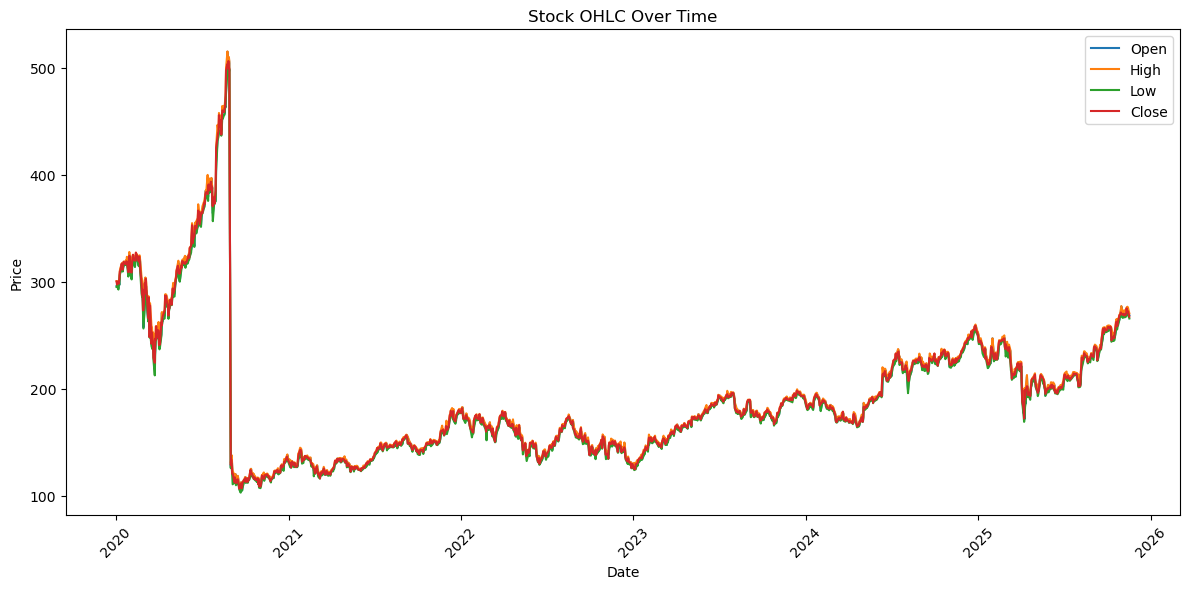

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# stock_df must contain:
# index = datetime
# columns = ["open", "high", "low", "close"]
# -----------------------------

# Example: if your stock_df is already loaded
# stock_df = your_dataframe

# Ensure index is datetime
stock.index = pd.to_datetime(stock.index)

plt.figure(figsize=(12,6))

plt.plot(stock.index, stock["open"], label="Open")
plt.plot(stock.index, stock["high"], label="High")
plt.plot(stock.index, stock["low"], label="Low")
plt.plot(stock.index, stock["close"], label="Close")

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock OHLC Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import os

# -------------------------
# Stock lists
# -------------------------
large_caps = [
    "AAPL","MSFT","AMZN","GOOGL","GOOG","META","NVDA","TSLA","BRK.B","JNJ",
    "JPM","V","MA","PG","XOM","CVX","HD","WMT","KO","PEP","ABBV","AVGO",
    "LLY","UNH","MRK","CSCO","ORCL","NFLX","CRM","COST","DIS","ACN",
    "TXN","INTC","NKE","UPS","IBM","QCOM","DHR","AMGN","GE","CAT","HON",
    "LIN","BLK","ADBE","SPGI","MS","BAC"
]

mid_caps = [
    "ALGN","FICO","WDAY","OKTA","MTCH","ETSY","CHRW","SWKS","DKNG","TDOC",
    "DOCU","Z","PINS","HUBS", "DDOG","NET", "MDB",
    "ZS","TEAM","LULU","RH","ENPH","FSLR","ROKU","CPRI","BURL","MHK","HAS",
    "ALV","HELE","AAP","CNP","GNRC","RHI","HOLX","BRO","WEX","FFIV","MAN",
    "AER","AOS","CAR","CORT","TPR","MAS","SEE"
]

small_caps = [
    "PLUG","FUBO","EXAS","NTLA","WKHS", "CHPT","FSLY","TLRY","NIO",
    "JMIA","COHR","CPIX", "BLNK","AEO","FLGT",
    "VRDN","TGNA","KLIC","BLMN","SONO","MGNI","WK",
    "CORT","CALM","TRUP","TNDM", "IRBT","BYND","PRPL"
]

all_stocks = large_caps + mid_caps + small_caps

# -------------------------
# Load extra column file
# -------------------------
extra_df = pd.read_excel("Date.csv.xlsx")   # Update with your actual file path

# This should be a single column; rename it if needed
extra_df.columns = ["Date"]

# -------------------------
# Function to update a single stock CSV
# -------------------------
def update_stock_csv(symbol):
    filename = f"{symbol}.csv"

    if not os.path.exists(filename):
        print(f"❌ File not found: {filename}")
        return

    # Load stock file
    df = pd.read_csv(filename)

    # Ensure row count matches
    if len(extra_df) != len(df):
        print(f"⚠ Length mismatch for {filename} (stock rows={len(df)}, extra rows={len(extra_df)})")
        return

    # Concatenate the extra column
    df["Date"] = extra_df["Date"]

    # Save updated file
    output_file = f"{symbol}.csv"
    df.to_csv(output_file, index=False)

    #print(f"✅ Updated: {output_file}")

# -------------------------
# Process all stocks
# -------------------------



In [7]:
for stock in small_caps :
    update_stock_csv(f"Stock\Small_Cap\{stock}")

⚠ Length mismatch for Stock\Small_Cap\VERV.csv (stock rows=1031, extra rows=1481)
⚠ Length mismatch for Stock\Small_Cap\DNA.csv (stock rows=1156, extra rows=1481)
⚠ Length mismatch for Stock\Small_Cap\OPEN.csv (stock rows=1365, extra rows=1481)
⚠ Length mismatch for Stock\Small_Cap\SOFI.csv (stock rows=1251, extra rows=1481)
⚠ Length mismatch for Stock\Small_Cap\LCID.csv (stock rows=1301, extra rows=1481)
⚠ Length mismatch for Stock\Small_Cap\SANA.csv (stock rows=1206, extra rows=1481)
⚠ Length mismatch for Stock\Small_Cap\NOVA.csv (stock rows=1366, extra rows=1481)
⚠ Length mismatch for Stock\Small_Cap\UPST.csv (stock rows=1239, extra rows=1481)
⚠ Length mismatch for Stock\Small_Cap\ARRY.csv (stock rows=1282, extra rows=1481)
⚠ Length mismatch for Stock\Small_Cap\AI.csv (stock rows=1244, extra rows=1481)
⚠ Length mismatch for Stock\Small_Cap\SMAR.csv (stock rows=1271, extra rows=1481)
⚠ Length mismatch for Stock\Small_Cap\SKLZ.csv (stock rows=1402, extra rows=1481)
⚠ Length mismatch f

Epoch 1/20


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0165
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0046
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0037
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0030
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0028
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0025
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0026
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0021
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0019
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0019
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0016
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0019
Epoch 13/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0016    
Epoch 14/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0017
Epoch 15/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0013    
Epoch 1

C:\Users\roshn\AppData\Local\Temp\ipykernel_12792\2048833259.py:62: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(pd.date_range(df.index[-1], periods=8)[1:], predictions, label="Forecast")


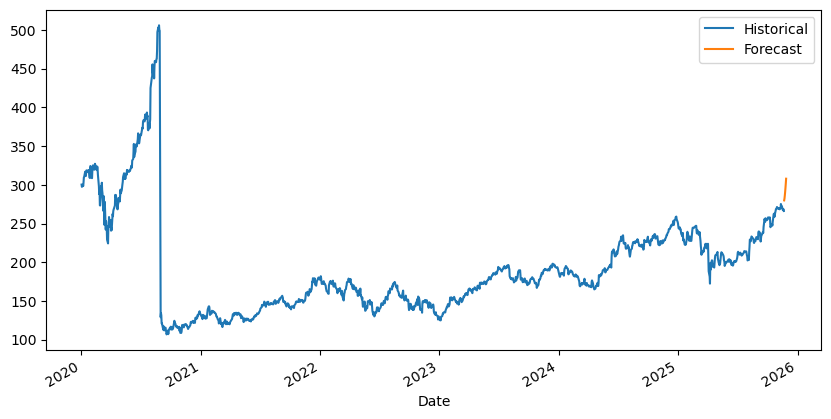

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("Stock\Large_Cap\AAPL.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'close']]
df.set_index('Date', inplace=True)

# Scale data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['close']])

# Create sequences
def create_sequences(data, seq=60):
    X, y = [], []
    for i in range(seq, len(data)):
        X.append(data[i-seq:i])
        y.append(data[i])
    return np.array(X), np.array(y)

SEQ_LEN = 60
X, y = create_sequences(scaled, SEQ_LEN)

# Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Predict next 7 days
last_seq = scaled[-SEQ_LEN:]
predictions = []
current = last_seq.reshape(1, SEQ_LEN, 1)

for _ in range(7):
    next_val = model.predict(current)[0]
    predictions.append(next_val)
    current = np.append(current[:, 1:, :], [[next_val]], axis=1)

# Inverse transform
predictions = scaler.inverse_transform(predictions)

print("Next 7-Day Forecast:")
print(predictions)

# Plot
df['close'].plot(label="Historical", figsize=(10,5))
plt.plot(pd.date_range(df.index[-1], periods=8)[1:], predictions, label="Forecast")
plt.legend()
plt.show()


14:46:20 - cmdstanpy - INFO - Chain [1] start processing
14:46:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


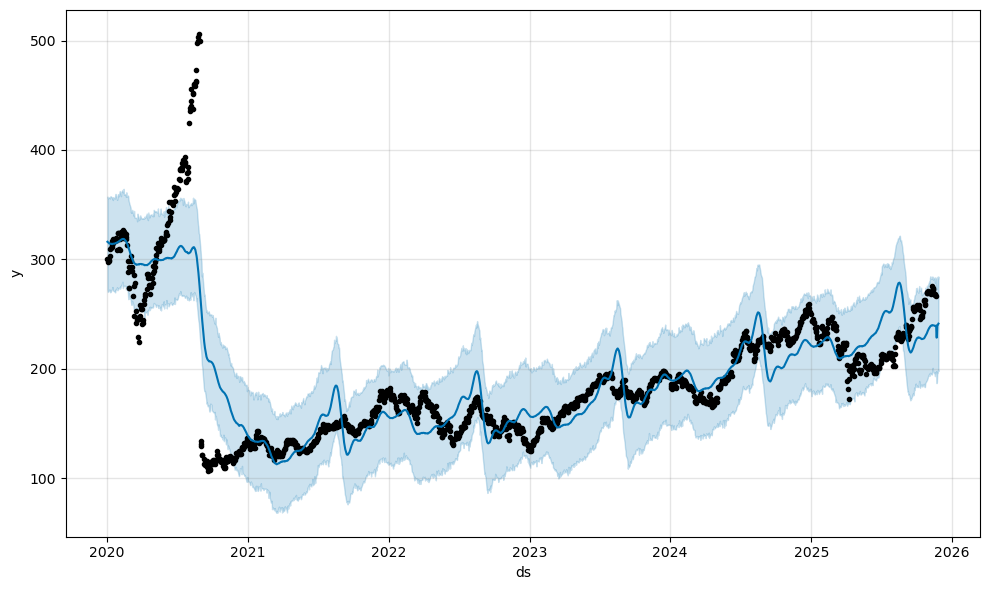

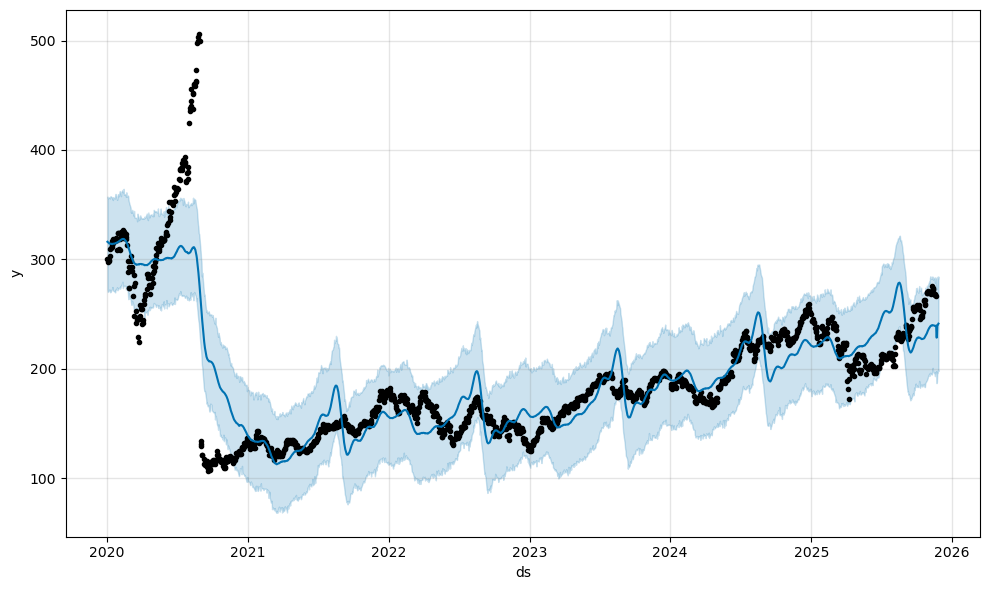

In [23]:
from prophet import Prophet
import pandas as pd

df = pd.read_csv("Stock\Large_Cap\AAPL.csv")
df = df.rename(columns={'Date': 'ds', 'close': 'y'})

model = Prophet()
model.fit(df)

future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)

model.plot(forecast)


In [24]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv("Stock\Large_Cap\AAPL.csv")
close = df['close']

model = ARIMA(close, order=(5,1,2))
fit = model.fit()
forecast = fit.forecast(steps=7)

print(forecast)


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1481    266.266944
1482    265.976497
1483    266.204038
1484    266.127358
1485    265.955218
1486    266.123791
1487    266.072804
Name: predicted_mean, dtype: float64


In [26]:
from autots import AutoTS
import pandas as pd

df = pd.read_csv("Stock\Large_Cap\AAPL.csv")
df = df[['Date','close']]

model = AutoTS(
    forecast_length=7,
    frequency='infer',
    ensemble='all'
)

model.fit(df, date_col='Date', value_col='close')
pred = model.predict()
print(pred.forecast)


Using 5 cpus for n_jobs.
Data frequency is: B, used frequency is: B
Model Number: 1 with model AverageValueNaive in generation 0 of 25
Model Number: 2 with model AverageValueNaive in generation 0 of 25
Model Number: 3 with model AverageValueNaive in generation 0 of 25
Model Number: 4 with model DatepartRegression in generation 0 of 25
Model Number: 5 with model DatepartRegression in generation 0 of 25
Model Number: 6 with model DatepartRegression in generation 0 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 7 with model DatepartRegression in generation 0 of 25

Epoch 1/50


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4212
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4205
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4193
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4207
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4184
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4187
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4185
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4176
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4183
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4164
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4169
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4170
Epoch 13/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4169
Epoch 14/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4166
Epoch 15/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4155
Epoch 16/50
48/48 ━━━━━━━━━━━━

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 25 with model FBProphet in generation 0 of 25
Model Number: 26 with model DatepartRegression in generation 0 of 25
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Model Number: 27 with model SeasonalNaive in generation 0 of 25
Model Number: 28 with model DatepartRegression in generation 0 of 25
Model Number: 29 with model ETS in generation 0 of 25
Model Number: 30 with model ARDL in generation 0 of 25
Model Number: 31 with model UnivariateMotif in generation 0 of 25
Model Number: 32 with model UnivariateMotif in generation 0 of 25
Model Number: 33 with model SectionalMotif in generation 0 of 25
Model Number: 34 with model SectionalMotif in generation 0 of 25
Model Number: 35 with model FBProphet in generation 0 of 25
Model Number: 36 with model SeasonalNaive in generation 0 of 25
Model Number: 37 with model DatepartRegression in generation 0 of 25
Model Number: 38 with model ARCH in g

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 41 with model Cassandra in generation 0 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 42 with model Cassandra in generation 0 of 25
Model Number: 43 with model Cassandra in generation 0 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 44 with model SectionalMotif in generation 0 of 25
Model Number: 45 with model FBProphet in generation 0 of 25


14:50:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Model Number: 46 with model ARDL in generation 0 of 25
Model Number: 47 with model FFT in generation 0 of 25
Model Number: 48 with model BasicLinearModel in generation 0 of 25
Template Eval Error: ValueError('matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1529 is different from 2433)') in model 48 in generation 0: BasicLinearModel
Model Number: 49 with model BasicLinearModel in generation 0 of 25
Model Number: 50 with model SeasonalityMotif in generation 0 of 25
Model Number: 51 with model BasicLinearModel in generation 0 of 25
Model Number: 52 with model FBProphet in generation 0 of 25
Model Number: 53 with model ETS in generation 0 of 25
Model Number: 54 with model FBProphet in generation 0 of 25
Model Number: 55 with model GLM in generation 0 of 25
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 55 in generation 0: GLM
Model Number: 56 with model Univ

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 57 with model ARDL in generation 0 of 25
Model Number: 58 with model ARCH in generation 0 of 25
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 58 in generation 0: ARCH
Model Number: 59 with model ConstantNaive in generation 0 of 25
Model Number: 60 with model LastValueNaive in generation 0 of 25
Model Number: 61 with model AverageValueNaive in generation 0 of 25
Model Number: 62 with model GLS in generation 0 of 25
Model Number: 63 with model SeasonalNaive in generation 0 of 25
Model Number: 64 with model VAR in generation 0 of 25
Model Number: 65 with model WindowRegression in generation 0 of 25
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 65 in generation 0: WindowRegression
Model Number: 66 with model DatepartRegression in generation 0 of 25
Model Number: 67 with model SectionalMotif in generation 0 of 25
Model Number: 68 with model RRVAR in generation 0 of 25
Model Number: 69 

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 72 with model FFT in generation 0 of 25
Model Number: 73 with model BasicLinearModel in generation 0 of 25
Model Number: 74 with model AverageValueNaive in generation 0 of 25
Model Number: 75 with model ConstantNaive in generation 0 of 25
Model Number: 76 with model LastValueNaive in generation 0 of 25
Model Number: 77 with model DatepartRegression in generation 0 of 25
Model Number: 78 with model SeasonalNaive in generation 0 of 25
Model Number: 79 with model MetricMotif in generation 0 of 25
Model Number: 80 with model ETS in generation 0 of 25
2025-11-12 00:00:00
2025-11-12 00:00:00
2025-11-12 00:00:00
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'ffill_mean_biased', 'transformations': {'0': 'AnomalyRemoval', '1': 'Slice', '2': 'FFTDecomposition', '3': 'UpscaleDownscaleTransformer', '4': 'LevelShiftTransformer'}, 'transformation_params': {'0': {'method': 'IQR', 'method_params': {'iqr_threshold': 3.0, 'iqr_quantiles':

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 99 with model ARCH in generation 0 of 25
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 99 in generation 0: ARCH
Model Number: 100 with model GLM in generation 0 of 25
Model Number: 101 with model VAR in generation 0 of 25
Template Eval Error: ValueError('Only gave one variable to VAR') in model 101 in generation 0: VAR
Model Number: 102 with model FBProphet in generation 0 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
14:51:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Model Number: 103 with model LastValueNaive in generation 0 of 25
Model Number: 104 with model RRVAR in generation 0 of 25
Model Number: 105 with model AverageValueNaive in generation 0 of 25
2025-11-12 00:00:00
2025-11-12 00:00:00
2025-11-12 00:00:00
Model Number: 106 with model SeasonalityMotif in generation 0 of 25
Model Number: 107 with model SectionalMotif in generation 0 of 25
Model Number: 108 with model VAR in generation 0 of 25
Template Eval Error: ValueError('Only gave one variable to VAR') in model 108 in generation 0: VAR
Model Number: 109 with model ARCH in generation 0 of 25
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 109 in generation 0: ARCH
Model Number: 110 with model SeasonalityMotif in generation 0 of 25
Model Number: 111 with model FFT in generation 0 of 25
Model Number: 112 with model AverageValueNaive in generation 0 of 25
Model Number: 113 with model ConstantNaive in generation 0 of 25
Model Number: 114 with model ETS i

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),


Model Number: 154 with model SectionalMotif in generation 0 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),


Model Number: 155 with model SeasonalNaive in generation 0 of 25
Template Eval Error: Exception("Transformer FIRFilter failed on fit from params mean {'0': {'method': 'IQR', 'method_params': {'iqr_threshold': 2.0, 'iqr_quantiles': [0.25, 0.75]}, 'fillna': 'rolling_mean_24', 'transform_dict': None, 'isolated_only': False, 'on_inverse': False}, '1': {'numtaps': 7, 'cutoff_hz': 50, 'window': 'hamming', 'sampling_frequency': 72, 'on_transform': True, 'on_inverse': False, 'bounds_only': False}, '2': {'fixed': True, 'window': 3, 'macro_micro': False, 'center': False}, '3': {'method': 'minmax', 'method_params': {'alpha': 0.05}, 'transform_dict': None, 'reverse_alignment': False, 'isolated_only': False, 'fillna': 'time'}, '4': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 3, 'threshold_method': 'max'}} with error ValueError('Invalid cutoff frequency: frequencies must be greater than 0 and less than fs/2.')") in model 155 in generation 0: S

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 164 with model LastValueNaive in generation 1 of 25
Model Number: 165 with model SeasonalNaive in generation 1 of 25
Model Number: 166 with model SectionalMotif in generation 1 of 25
Model Number: 167 with model Cassandra in generation 1 of 25
Model Number: 168 with model AverageValueNaive in generation 1 of 25
Model Number: 169 with model AverageValueNaive in generation 1 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 170 with model SeasonalNaive in generation 1 of 25
Model Number: 171 with model ETS in generation 1 of 25
Model Number: 172 with model SectionalMotif in generation 1 of 25
Model Number: 173 with model FBProphet in generation 1 of 25
Model Number: 174 with model AverageValueNaive in generation 1 of 25
Model Number: 175 with model SeasonalityMotif in generation 1 of 25
Model Number: 176 with model FBProphet in generation 1 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 177 with model SectionalMotif in generation 1 of 25
Model Number: 178 with model FBProphet in generation 1 of 25
Model Number: 179 with model SectionalMotif in generation 1 of 25
Model Number: 180 with model Cassandra in generation 1 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 181 with model LastValueNaive in generation 1 of 25
Model Number: 182 with model UnivariateMotif in generation 1 of 25
Model Number: 183 with model SectionalMotif in generation 1 of 25
Model Number: 184 with model AverageValueNaive in generation 1 of 25
2025-11-12 00:00:00
2025-11-12 00:00:00
2025-11-12 00:00:00
Model Number: 185 with model FBProphet in generation 1 of 25
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 185 in generation 1: FBProphet
Model Number: 186 with model FFT in generation 1 of 25
Model Number: 187 with model ConstantNaive in generation 1 of 25
Model Number: 188 with model LastValueNaive in generation 1 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params rolling_mean {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'regression_model': {'model': 'LinearRegression', 'model_param

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 202 with model SectionalMotif in generation 1 of 25
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 202 in generation 1: SectionalMotif
Model Number: 203 with model MetricMotif in generation 1 of 25
Model Number: 204 with model AverageValueNaive in generation 1 of 25
Model Number: 205 with model LastValueNaive in generation 1 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params rolling_mean {'0': {}, '1': {'regression_model': {'model': 'LinearRegression', 'model_params': {}}, 'max_lags': 1}, '2': {}} with error ValueError('BTCD only works on multivarate series')") in model 205 in generation 1: LastValueNaive
Model Number: 206 with model ETS in generation 1 of 25
Model Number: 207 with model ETS in generation 1 of 25
Model Number: 208 with model UnivariateMotif in generation 1 of 25
Model Number: 209 with model RRVAR in generation 1 of 25
Model Number: 210 with model GLS in generation 1 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Number: 222 with model SectionalMotif in generation 1 of 25
Model Number: 223 with model SeasonalNaive in generation 1 of 25
Model Number: 224 with model MetricMotif in generation 1 of 25
Model Number: 225 with model UnivariateMotif in generation 1 of 25
Model Number: 226 with model SeasonalityMotif in generation 1 of 25
Template Eval Error: ValueError('Model SeasonalityMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 226 in generation 1: SeasonalityMotif
Model Number: 227 with model ConstantNaive in generation 1 of 25
Model Number: 228 with model SeasonalityMotif in generation 1 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params cubic {'0': {}, '1': {'regression_model': {'model': 'FastRidge', 'model_params': {}}, 'max_lags': 2}, '2': {}, '3': {}, '4': {'method': 'clip', 'std_threshold': 5, 'fillna': None}} with error ValueError('BTCD only works on multivarate series')") in model 228 in generation 1: SeasonalityMotif
Mo

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Model Number: 231 with model MetricMotif in generation 1 of 25
Model Number: 232 with model SectionalMotif in generation 1 of 25
Model Number: 233 with model SectionalMotif in generation 1 of 25
Model Number: 234 with model WindowRegression in generation 1 of 25
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 234 in generation 1: WindowRegression
Model Number: 235 with model SeasonalNaive in generation 1 of 25
Model Number: 236 with model UnivariateMotif in generation 1 of 25
Model Number: 237 with model LastValueNaive in generation 1 of 25
Model Number: 238 with model FFT in generation 1 of 25
Model Number: 239 with model ConstantNaive in generation 1 of 25
Model Number: 240 with model MetricMotif in generation 1 of 25
Model Number: 241 with model GLS in generation 1 of 25
Model Number: 242 with model SectionalMotif in generation 1 of 25
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in mode

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 190.9968
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 185.1358
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 181.3430
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 179.1237
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 177.1704
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 175.3229
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 173.5389
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 171.7916
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 170.0724
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 168.3725
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 166.6904
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 165.0186
Epoch 13/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 163.3577
Epoch 14/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 161.7052
Epoch 15/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 160.0599


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\decomposition\_fastica.py:592: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn("Ignoring n_components with whiten=False.")
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Model Number: 272 with model SectionalMotif in generation 2 of 25
Model Number: 273 with model FFT in generation 2 of 25
Model Number: 274 with model AverageValueNaive in generation 2 of 25
Model Number: 275 with model ConstantNaive in generation 2 of 25
Model Number: 276 with model RRVAR in generation 2 of 25
Model Number: 277 with model Cassandra in generation 2 of 25
Model Number: 278 with model ConstantNaive in generation 2 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 279 with model UnivariateMotif in generation 2 of 25
Model Number: 280 with model SeasonalNaive in generation 2 of 25
Model Number: 281 with model Cassandra in generation 2 of 25
Model Number: 282 with model ETS in generation 2 of 25
Model Number: 283 with model Cassandra in generation 2 of 25
Model Number: 284 with model FFT in generation 2 of 25
Model Number: 285 with model LastValueNaive in generation 2 of 25
Model Number: 286 with model AverageValueNaive in generation 2 of 25
Model Number: 287 with model AverageValueNaive in generation 2 of 25
Model Number: 288 with model Cassandra in generation 2 of 25
Template Eval Error: Exception('Transformer PCA failed on fit from params zero {\'0\': {\'whiten\': True, \'n_components\': 100}, \'1\': {\'method\': \'savgol_filter\', \'method_args\': {\'window_length\': 31, \'polyorder\': 4, \'deriv\': 0, \'mode\': \'nearest\'}}, \'2\': {}} with error ValueError("n_components=100 must be between 0 and min(n_samples, n_features)=1 wi

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 291 with model DatepartRegression in generation 2 of 25
Model Number: 292 with model BasicLinearModel in generation 2 of 25
Model Number: 293 with model ARDL in generation 2 of 25
Model Number: 294 with model GLM in generation 2 of 25
Model Number: 295 with model SeasonalityMotif in generation 2 of 25
Model Number: 296 with model ARDL in generation 2 of 25
Model Number: 297 with model SectionalMotif in generation 2 of 25
Model Number: 298 with model SeasonalityMotif in generation 2 of 25
Model Number: 299 with model AverageValueNaive in generation 2 of 25
Template Eval Error: Exception("Transformer Cointegration failed on fit from params ffill {'0': {'rows': 7}, '1': {}, '2': {'part': 'trend', 'lamb': 129600}, '3': {'det_order': 1, 'k_ar_diff': 2}} with error ValueError('Coint only works on multivarate series')") in model 299 in generation 2: AverageValueNaive
Model Number: 300 with model SectionalMotif in generation 2 of 25
Model Number: 301 with model SectionalMotif in 

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 336 with model FFT in generation 2 of 25
Model Number: 337 with model FBProphet in generation 2 of 25
Model Number: 338 with model ETS in generation 2 of 25
Model Number: 339 with model SectionalMotif in generation 2 of 25
Model Number: 340 with model LastValueNaive in generation 2 of 25
Model Number: 341 with model RRVAR in generation 2 of 25
Model Number: 342 with model BasicLinearModel in generation 2 of 25
Model Number: 343 with model ETS in generation 2 of 25
Model Number: 344 with model SectionalMotif in generation 2 of 25
Model Number: 345 with model ARDL in generation 2 of 25
Model Number: 346 with model VAR in generation 2 of 25
Template Eval Error: ValueError('Only gave one variable to VAR') in model 346 in generation 2: VAR
Model Number: 347 with model Cassandra in generation 2 of 25
Model Number: 348 with model LastValueNaive in generation 2 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 349 with model SeasonalityMotif in generation 2 of 25
Template Eval Error: ValueError('Model SeasonalityMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 349 in generation 2: SeasonalityMotif
Model Number: 350 with model AverageValueNaive in generation 2 of 25
Model Number: 351 with model ETS in generation 2 of 25
Model Number: 352 with model SeasonalNaive in generation 2 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params ffill_mean_biased {'0': {'regression_model': {'model': 'LinearRegression', 'model_params': {}}, 'max_lags': 2}, '1': {'rows': 7, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'max'}, '2': {'lag': 1, 'fill': 'bfill'}} with error ValueError('BTCD only works on multivarate series')") in model 352 in generation 2: SeasonalNaive
Model Number: 353 with model SeasonalityMotif in generation 2 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\models\basics.py:2966: RuntimeWarning: All-NaN slice encountered
  forecast = np.nanmedian(results, axis=0)


Model Number: 354 with model ETS in generation 2 of 25
Model Number: 355 with model SeasonalNaive in generation 2 of 25
Model Number: 356 with model AverageValueNaive in generation 2 of 25
Template Eval Error: ValueError('operands could not be broadcast together with shapes (69,1) (7,1) ') in model 356 in generation 2: AverageValueNaive
Model Number: 357 with model ConstantNaive in generation 2 of 25
Model Number: 358 with model FBProphet in generation 2 of 25
Template Eval Error: Exception("Transformer Detrend failed on fit from params rolling_mean_24 {'0': {}, '1': {'model': 'Linear', 'phi': 1, 'window': None, 'transform_dict': {'fillna': None, 'transformations': {'0': 'AnomalyRemoval'}, 'transformation_params': {'0': {'method': 'zscore', 'transform_dict': {'transformations': {'0': 'DatepartRegression'}, 'transformation_params': {'0': {'datepart_method': 'simple_3', 'regression_model': {'model': 'ElasticNet', 'model_params': {}}}}}, 'method_params': {'distribution': 'uniform', 'alpha

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 363 with model SectionalMotif in generation 2 of 25
Model Number: 364 with model SeasonalNaive in generation 2 of 25
Model Number: 365 with model MetricMotif in generation 2 of 25
Model Number: 366 with model GLS in generation 2 of 25
Model Number: 367 with model Cassandra in generation 2 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


New Generation: 3 of 25
Model Number: 368 with model FBProphet in generation 3 of 25
Model Number: 369 with model MetricMotif in generation 3 of 25
Model Number: 370 with model LastValueNaive in generation 3 of 25
Model Number: 371 with model ARDL in generation 3 of 25
Model Number: 372 with model SeasonalNaive in generation 3 of 25
Template Eval Error: Exception("Transformer Cointegration failed on fit from params ffill {'0': {}, '1': {'det_order': 0, 'k_ar_diff': 0}, '2': {'lag_1': 7, 'method': 5}, '3': {}, '4': {'decomp_type': 'STL', 'part': 'trend', 'seasonal': 363}} with error ValueError('Coint only works on multivarate series')") in model 372 in generation 3: SeasonalNaive
Model Number: 373 with model RRVAR in generation 3 of 25
Model Number: 374 with model SeasonalityMotif in generation 3 of 25
Model Number: 375 with model ARDL in generation 3 of 25
Model Number: 376 with model AverageValueNaive in generation 3 of 25
Model Number: 377 with model AverageValueNaive in generation 3

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 386 with model SectionalMotif in generation 3 of 25
Model Number: 387 with model LastValueNaive in generation 3 of 25
Model Number: 388 with model AverageValueNaive in generation 3 of 25
Model Number: 389 with model FFT in generation 3 of 25
Model Number: 390 with model SeasonalityMotif in generation 3 of 25
Model Number: 391 with model BasicLinearModel in generation 3 of 25
Model Number: 392 with model MetricMotif in generation 3 of 25
Model Number: 393 with model FFT in generation 3 of 25
Model Number: 394 with model SeasonalityMotif in generation 3 of 25
Model Number: 395 with model ConstantNaive in generation 3 of 25
Model Number: 396 with model Cassandra in generation 3 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 397 with model ETS in generation 3 of 25
Model Number: 398 with model ConstantNaive in generation 3 of 25
Template Eval Error: ValueError('operands could not be broadcast together with shapes (69,1) (7,1) ') in model 398 in generation 3: ConstantNaive
Model Number: 399 with model SeasonalityMotif in generation 3 of 25
Model Number: 400 with model SectionalMotif in generation 3 of 25
Model Number: 401 with model ARDL in generation 3 of 25
Model Number: 402 with model BasicLinearModel in generation 3 of 25
Model Number: 403 with model MetricMotif in generation 3 of 25
Model Number: 404 with model SeasonalityMotif in generation 3 of 25
Model Number: 405 with model UnivariateMotif in generation 3 of 25
Model Number: 406 with model DatepartRegression in generation 3 of 25
Model Number: 407 with model SeasonalityMotif in generation 3 of 25
Model Number: 408 with model GLS in generation 3 of 25
Model Number: 409 with model ARDL in generation 3 of 25
Model Number: 410 with model 

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 46.8304
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45.9243
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.3286
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.1378
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.0694
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.0284
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.9998
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.9813
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.9739
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.9636
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.9631
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.9509
Epoch 13/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.9552
Epoch 14/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.9566
Epoch 15/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.9485
Epoch 16/50
48/

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 416 in generation 3: Cassandra
Model Number: 417 with model AverageValueNaive in generation 3 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 418 with model FBProphet in generation 3 of 25
No anomalies detected.


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),


Model Number: 419 with model ARDL in generation 3 of 25
Model Number: 420 with model GLS in generation 3 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),


Model Number: 421 with model FFT in generation 3 of 25
Model Number: 422 with model ETS in generation 3 of 25
Model Number: 423 with model MetricMotif in generation 3 of 25
Model Number: 424 with model SeasonalityMotif in generation 3 of 25
Model Number: 425 with model UnivariateMotif in generation 3 of 25
Model Number: 426 with model MetricMotif in generation 3 of 25
Model Number: 427 with model SectionalMotif in generation 3 of 25
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 427 in generation 3: SectionalMotif
Model Number: 428 with model MetricMotif in generation 3 of 25
Model Number: 429 with model AverageValueNaive in generation 3 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 430 with model UnivariateMotif in generation 3 of 25
Model Number: 431 with model AverageValueNaive in generation 3 of 25
Model Number: 432 with model UnivariateMotif in generation 3 of 25
Template Eval Error: Exception("Transformer Cointegration failed on fit from params ffill {'0': {'det_order': -1, 'k_ar_diff': 1}, '1': {'lag': 1, 'fill': 'bfill'}, '2': {}, '3': {'lag_1': 61, 'method': 'Mean'}} with error ValueError('Coint only works on multivarate series')") in model 432 in generation 3: UnivariateMotif
Model Number: 433 with model MetricMotif in generation 3 of 25
Model Number: 434 with model MetricMotif in generation 3 of 25
Model Number: 435 with model LastValueNaive in generation 3 of 25
Model Number: 436 with model Cassandra in generation 3 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 437 with model FBProphet in generation 3 of 25
Model Number: 438 with model LastValueNaive in generation 3 of 25
Model Number: 439 with model MetricMotif in generation 3 of 25
Model Number: 440 with model GLM in generation 3 of 25
Template Eval Error: Exception("Transformer Detrend failed on fit from params mean {'0': {'model': 'Tweedie', 'phi': 1, 'window': 900, 'transform_dict': None}, '1': {'output_distribution': 'uniform', 'n_quantiles': 1000}, '2': {'lag_1': 96, 'method': 'LastValue'}} with error ValueError('Found input variables with inconsistent numbers of samples: [900, 1529]')") in model 440 in generation 3: GLM
Model Number: 441 with model Cassandra in generation 3 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)


Model Number: 442 with model GLM in generation 3 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 443 with model SectionalMotif in generation 3 of 25
Model Number: 444 with model LastValueNaive in generation 3 of 25
Model Number: 445 with model FBProphet in generation 3 of 25
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 445 in generation 3: FBProphet
Model Number: 446 with model SectionalMotif in generation 3 of 25
Model Number: 447 with model ARDL in generation 3 of 25
Model Number: 448 with model AverageValueNaive in generation 3 of 25
Model Number: 449 with model BasicLinearModel in generation 3 of 25
Model Number: 450 with model RRVAR in generation 3 of 25
Model Number: 451 with model SeasonalNaive in generation 3 of 25
Model Number: 452 with model Cassandra in generation 3 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 453 with model UnivariateMotif in generation 3 of 25
Model Number: 454 with model AverageValueNaive in generation 3 of 25
Model Number: 455 with model SectionalMotif in generation 3 of 25
Model Number: 456 with model SeasonalityMotif in generation 3 of 25
Model Number: 457 with model ConstantNaive in generation 3 of 25
Model Number: 458 with model MetricMotif in generation 3 of 25
Model Number: 459 with model DatepartRegression in generation 3 of 25
Model Number: 460 with model SectionalMotif in generation 3 of 25
Model Number: 461 with model UnivariateMotif in generation 3 of 25
Model Number: 462 with model Cassandra in generation 3 of 25
Model Number: 463 with model UnivariateMotif in generation 3 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 464 with model FBProphet in generation 3 of 25
Model Number: 465 with model AverageValueNaive in generation 3 of 25
Model Number: 466 with model FBProphet in generation 3 of 25
No anomalies detected.


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
14:52:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat

Model Number: 467 with model Cassandra in generation 3 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 468 with model SectionalMotif in generation 3 of 25
Model Number: 469 with model SeasonalityMotif in generation 3 of 25
Model Number: 470 with model SectionalMotif in generation 3 of 25
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 470 in generation 3: SectionalMotif
Model Number: 471 with model RRVAR in generation 3 of 25
Model Number: 472 with model ConstantNaive in generation 3 of 25
New Generation: 4 of 25
Model Number: 473 with model AverageValueNaive in generation 4 of 25
Model Number: 474 with model AverageValueNaive in generation 4 of 25
Model Number: 475 with model LastValueNaive in generation 4 of 25
Model Number: 476 with model BasicLinearModel in generation 4 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 477 with model Cassandra in generation 4 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 478 with model DatepartRegression in generation 4 of 25
Model Number: 479 with model FFT in generation 4 of 25
Model Number: 480 with model UnivariateMotif in generation 4 of 25
2025-11-12 00:00:00
2025-11-12 00:00:00
2025-11-12 00:00:00
Template Eval Error: ValueError('Model UnivariateMotif returned improper forecast_length. Returned: 3 and requested: 7') in model 480 in generation 4: UnivariateMotif
Model Number: 481 with model SeasonalityMotif in generation 4 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 482 with model LastValueNaive in generation 4 of 25
Model Number: 483 with model ConstantNaive in generation 4 of 25
Model Number: 484 with model Cassandra in generation 4 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params ffill {'0': {'method': 'EE', 'method_params': {'contamination': 0.1, 'assume_centered': False, 'support_fraction': None}, 'fillna': 'linear', 'transform_dict': None, 'isolated_only': False, 'on_inverse': False}, '1': {}, '2': {'rows': 1, 'lag': 1, 'method': 'multiplicative', 'strength': 1.0, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'mean'}, '3': {'regression_model': {'model': 'FastRidge', 'model_params': {}}, 'max_lags': 1}} with error ValueError('BTCD only works on multivarate series')") in model 484 in generation 4: Cassandra
Model Number: 485 with model ARDL in generation 4 of 25
Model Number: 486 with model RRVAR in generation 4 of 25
Model Number: 487 with model ConstantNaive in generation 4 of 25

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 489 with model AverageValueNaive in generation 4 of 25
Model Number: 490 with model MetricMotif in generation 4 of 25
Model Number: 491 with model ARDL in generation 4 of 25
Model Number: 492 with model GLS in generation 4 of 25
Model Number: 493 with model DatepartRegression in generation 4 of 25
Model Number: 494 with model UnivariateMotif in generation 4 of 25
Model Number: 495 with model FBProphet in generation 4 of 25
Model Number: 496 with model AverageValueNaive in generation 4 of 25
Model Number: 497 with model AverageValueNaive in generation 4 of 25
Model Number: 498 with model MetricMotif in generation 4 of 25
Model Number: 499 with model SeasonalNaive in generation 4 of 25
Model Number: 500 with model GLM in generation 4 of 25
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 500 in generation 4: GLM
Model Number: 501 with model BasicLinearModel in gene

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 502 with model Cassandra in generation 4 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 503 with model Cassandra in generation 4 of 25
Template Eval Error: IndexError('positional indexers are out-of-bounds') in model 503 in generation 4: Cassandra
Model Number: 504 with model SeasonalityMotif in generation 4 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 505 with model FBProphet in generation 4 of 25
Model Number: 506 with model SeasonalityMotif in generation 4 of 25
Model Number: 507 with model RRVAR in generation 4 of 25
Model Number: 508 with model UnivariateMotif in generation 4 of 25
Model Number: 509 with model FFT in generation 4 of 25
Model Number: 510 with model FBProphet in generation 4 of 25
Model Number: 511 with model RRVAR in generation 4 of 25
Model Number: 512 with model FFT in generation 4 of 25
Model Number: 513 with model Cassandra in generation 4 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 514 with model ARDL in generation 4 of 25
Model Number: 515 with model MetricMotif in generation 4 of 25
Template Eval Error: ValueError('Shape of passed values is (7, 2), indices imply (7, 1)') in model 515 in generation 4: MetricMotif
Model Number: 516 with model SeasonalNaive in generation 4 of 25
Model Number: 517 with model AverageValueNaive in generation 4 of 25
Model Number: 518 with model MetricMotif in generation 4 of 25
Model Number: 519 with model ConstantNaive in generation 4 of 25
Model Number: 520 with model GLM in generation 4 of 25
Model Number: 521 with model SectionalMotif in generation 4 of 25
Template Eval Error: ValueError('Model SectionalMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 521 in generation 4: SectionalMotif
Model Number: 522 with model AverageValueNaive in generation 4 of 25
Model Number: 523 with model MetricMotif in generation 4 of 25
Model Number: 524 with model LastValueNaive in generation 4 of 25
Temp

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:553: RuntimeWarning: invalid value encountered in divide
  avg = avg_as_array = np.multiply(a, wgt,
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 529 with model SeasonalityMotif in generation 4 of 25
Model Number: 530 with model AverageValueNaive in generation 4 of 25
Model Number: 531 with model LastValueNaive in generation 4 of 25
Template Eval Error: ValueError('operands could not be broadcast together with shapes (38,1) (7,1) ') in model 531 in generation 4: LastValueNaive
Model Number: 532 with model FBProphet in generation 4 of 25
Model Number: 533 with model ETS in generation 4 of 25
Model Number: 534 with model GLM in generation 4 of 25
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 534 in generation 4: GLM
Model Number: 535 with model Cassandra in generation 4 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 536 with model ConstantNaive in generation 4 of 25
Model Number: 537 with model LastValueNaive in generation 4 of 25
Model Number: 538 with model ConstantNaive in generation 4 of 25
Model Number: 539 with model LastValueNaive in generation 4 of 25
Model Number: 540 with model ARDL in generation 4 of 25
Model Number: 541 with model ConstantNaive in generation 4 of 25
Model Number: 542 with model ETS in generation 4 of 25
Model Number: 543 with model SeasonalityMotif in generation 4 of 25
Model Number: 544 with model ConstantNaive in generation 4 of 25
Model Number: 545 with model FBProphet in generation 4 of 25
Model Number: 546 with model DatepartRegression in generation 4 of 25
Model Number: 547 with model FBProphet in generation 4 of 25
Model Number: 548 with model ARDL in generation 4 of 25
Model Number: 549 with model SeasonalityMotif in generation 4 of 25
Model Number: 550 with model AverageValueNaive in generation 4 of 25
Model Number: 551 with model Cassandra in ge

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 553 with model SeasonalNaive in generation 4 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params ffill {'0': {'constraint_method': 'historic_growth', 'constraint_direction': 'lower', 'constraint_regularization': 0.9, 'constraint_value': {'threshold': 0.5, 'window': 10, 'quantile': 0.98}, 'bounds_only': False, 'fillna': None}, '1': {'regression_model': {'model': 'FastRidge', 'model_params': {}}, 'max_lags': 2}, '2': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': True, 'threshold': 10, 'threshold_method': 'max'}, '3': {'output_distribution': 'uniform', 'n_quantiles': 1000}} with error ValueError('BTCD only works on multivarate series')") in model 553 in generation 4: SeasonalNaive
Model Number: 554 with model ARDL in generation 4 of 25
Model Number: 555 with model SeasonalNaive in generation 4 of 25
Model Number: 556 with model AverageValueNaive in generation 4 of 25
Model Number: 557 with model SectionalMotif i

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted 

Model Number: 570 with model ConstantNaive in generation 4 of 25
Model Number: 571 with model ConstantNaive in generation 4 of 25
Model Number: 572 with model LastValueNaive in generation 4 of 25
Model Number: 573 with model ARDL in generation 4 of 25
Model Number: 574 with model UnivariateMotif in generation 4 of 25
Model Number: 575 with model SectionalMotif in generation 4 of 25
Template Eval Error: ValueError('Model SectionalMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 575 in generation 4: SectionalMotif
Model Number: 576 with model SectionalMotif in generation 4 of 25
Model Number: 577 with model ETS in generation 4 of 25
New Generation: 5 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:553: RuntimeWarning: invalid value encountered in divide
  avg = avg_as_array = np.multiply(a, wgt,


Model Number: 578 with model UnivariateMotif in generation 5 of 25
Template Eval Error: Exception("Transformer FIRFilter failed on fit from params mean {'0': {'decimals': 0, 'on_transform': True, 'on_inverse': False}, '1': {'rows': 1, 'lag': 2, 'method': 'additive', 'strength': 1.0, 'first_value_only': False}, '2': {'method': 'butter', 'method_args': {'N': 7, 'btype': 'highpass', 'analog': False, 'output': 'sos', 'Wn': 0.041666666666666664}}, '3': {'numtaps': 12, 'cutoff_hz': 10, 'window': 'blackman', 'sampling_frequency': 7, 'on_transform': True, 'on_inverse': False, 'bounds_only': False}} with error ValueError('Invalid cutoff frequency: frequencies must be greater than 0 and less than fs/2.')") in model 578 in generation 5: UnivariateMotif
Model Number: 579 with model SectionalMotif in generation 5 of 25
Template Eval Error: Exception("Transformer AnomalyRemoval failed on fit from params fake_date {'0': {}, '1': {'discretization': 'sklearn-uniform', 'n_bins': 50}, '2': {'method': 'EE

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),


Model Number: 586 with model RRVAR in generation 5 of 25
Model Number: 587 with model LastValueNaive in generation 5 of 25
Model Number: 588 with model ConstantNaive in generation 5 of 25
Model Number: 589 with model AverageValueNaive in generation 5 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),


Model Number: 590 with model SeasonalityMotif in generation 5 of 25
Model Number: 591 with model SeasonalityMotif in generation 5 of 25
Model Number: 592 with model SectionalMotif in generation 5 of 25
Model Number: 593 with model UnivariateMotif in generation 5 of 25
Model Number: 594 with model MetricMotif in generation 5 of 25
Model Number: 595 with model AverageValueNaive in generation 5 of 25
Model Number: 596 with model MetricMotif in generation 5 of 25
Model Number: 597 with model WindowRegression in generation 5 of 25
Model Number: 598 with model ConstantNaive in generation 5 of 25
Model Number: 599 with model SeasonalNaive in generation 5 of 25
Model Number: 600 with model FBProphet in generation 5 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Number: 601 with model Cassandra in generation 5 of 25
Template Eval Error: Exception("Transformer STLFilter failed on fit from params rolling_mean_24 {'0': {}, '1': {'mode': 'downscale', 'factor': 2, 'down_method': 'decimate', 'fill_method': 'cubic'}, '2': {}, '3': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'mean'}, '4': {'rows': 2, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'mean'}, '5': {'decomp_type': 'STL', 'part': 'trend', 'seasonal': 7}} with error ValueError('Unable to determine period from endog')") in model 601 in generation 5: Cassandra
Model Number: 602 with model MetricMotif in generation 5 of 25
Model Number: 603 with model RRVAR in generation 5 of 25
Model Number: 604 with model RRVAR in generation 5 of 25
Model Number: 605 with model SeasonalityMotif in generation 5 of 25
Model Number: 606 with model SeasonalityMotif

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),


Model Number: 609 with model GLM in generation 5 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Nega

Model Number: 610 with model ARDL in generation 5 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params mean {'0': {'lag_1': 7, 'method': 'Median'}, '1': {'rows': 1, 'lag': 2, 'method': 'additive', 'strength': 1.0, 'first_value_only': False}, '2': {}, '3': {}, '4': {'regression_model': {'model': 'LinearRegression', 'model_params': {}}, 'max_lags': 2}} with error ValueError('BTCD only works on multivarate series')") in model 610 in generation 5: ARDL
Model Number: 611 with model Cassandra in generation 5 of 25
Model Number: 612 with model AverageValueNaive in generation 5 of 25
Model Number: 613 with model FBProphet in generation 5 of 25
Model Number: 614 with model ETS in generation 5 of 25
Model Number: 615 with model SeasonalNaive in generation 5 of 25
Model Number: 616 with model SeasonalNaive in generation 5 of 25
Model Number: 617 with model FBProphet in generation 5 of 25
Model Number: 618 with model AverageValueNaive in generation 5 of 25
Model Number:

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 627 with model DatepartRegression in generation 5 of 25
Model Number: 628 with model RRVAR in generation 5 of 25
Model Number: 629 with model BasicLinearModel in generation 5 of 25
Model Number: 630 with model ConstantNaive in generation 5 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params ffill_mean_biased {'0': {'lag_1': 7, 'method': 'Median'}, '1': {'regression_model': {'model': 'FastRidge', 'model_params': {}}, 'max_lags': 2}, '2': {'whiten': False, 'n_components': None}, '3': {}} with error ValueError('BTCD only works on multivarate series')") in model 630 in generation 5: ConstantNaive
Model Number: 631 with model SeasonalNaive in generation 5 of 25
Model Number: 632 with model DatepartRegression in generation 5 of 25
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 632 in generation 5: DatepartRegression
Model Number: 633 with model ARDL in generation 5 of 25
Template Eval Error: ValueEr

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


New Generation: 6 of 25
Model Number: 662 with model MetricMotif in generation 6 of 25
Template Eval Error: ValueError('operands could not be broadcast together with shapes (29,1) (7,1) ') in model 662 in generation 6: MetricMotif
Model Number: 663 with model Cassandra in generation 6 of 25
Model Number: 664 with model ConstantNaive in generation 6 of 25
Model Number: 665 with model SeasonalityMotif in generation 6 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 666 with model SeasonalityMotif in generation 6 of 25
SVD did not converge, attempting more robust approach...
Template Eval Error: Exception("Transformer KalmanSmoothing failed on fit from params pchip {'0': {'model_name': 'local linear hidden state with seasonal 7', 'state_transition': [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]], 'process_noise': [[0.0016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\fast_kalman.py:1142: RuntimeWarning: overflow encountered in cast
  result.smoothed.states.cov[:, j, :, :] = Ps
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\fast_kalman.py:1148: RuntimeWarning: overflow encountered in cast
  result.smoothed.observations.cov[:, j, :, :] = obs_cov
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\fast_kalman.py:1359: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(A, np.swapaxes(B, -1, -2))
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\fast_kalman.py:1346: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(A, B)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.1718e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 669 with model SeasonalityMotif in generation 6 of 25
Model Number: 670 with model ConstantNaive in generation 6 of 25
Model Number: 671 with model SeasonalityMotif in generation 6 of 25
Model Number: 672 with model ETS in generation 6 of 25
Model Number: 673 with model LastValueNaive in generation 6 of 25
Model Number: 674 with model WindowRegression in generation 6 of 25
Template Eval Error: ModuleNotFoundError("No module named 'lightgbm'") in model 674 in generation 6: WindowRegression
Model Number: 675 with model GLM in generation 6 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 676 with model SectionalMotif in generation 6 of 25
Model Number: 677 with model AverageValueNaive in generation 6 of 25
Template Eval Error: Exception('Transformer ChangepointDetrend failed on fit from params ffill {\'0\': {\'lag_1\': 7, \'method\': \'Median\'}, \'1\': {\'method\': \'butter\', \'method_args\': {\'N\': 5, \'btype\': \'lowpass\', \'analog\': False, \'output\': \'sos\', \'Wn\': 0.041666666666666664}}, \'2\': {\'rows\': 1, \'lag\': 1, \'method\': \'additive\', \'strength\': 1.0, \'first_value_only\': False, \'threshold\': 10, \'threshold_method\': \'mean\'}, \'3\': {\'model\': \'Poisson\', \'changepoint_spacing\': 6, \'changepoint_distance_end\': 90, \'datepart_method\': [\'weekdayofmonth\', \'common_fourier\']}, \'4\': {}} with error ValueError("Some value(s) of y are out of the valid range of the loss \'HalfPoissonLoss\'.")') in model 677 in generation 6: AverageValueNaive
Model Number: 678 with model Cassandra in generation 6 of 25
Model Number: 679 with 

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\fast_kalman.py:1142: RuntimeWarning: overflow encountered in cast
  result.smoothed.states.cov[:, j, :, :] = Ps
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\fast_kalman.py:1148: RuntimeWarning: overflow encountered in cast
  result.smoothed.observations.cov[:, j, :, :] = obs_cov
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\fast_kalman.py:1359: RuntimeWarning: overflow encountered in matmul
  return np.matmul(A, np.swapaxes(B, -1, -2))
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\fast_kalman.py:1346: RuntimeWarning: overflow e

SVD did not converge, attempting more robust approach...
Template Eval Error: Exception("Transformer KalmanSmoothing failed on fit from params ffill {'0': {}, '1': {'model_name': 'randomly generated_original', 'state_transition': [[1, 1, 0, 0, -1, 1, 1, 0], [0, 0, 0, 1, 0, 0, 0, 1], [0, 0, 0, 0, -1, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 1, -1, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, -1, 0, 0]], 'process_noise': [[0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], 'observation_model': [[1, 1, 0, 0, 0, 0, 0, 0]], 'observation_noise': 1.0, 'em_iter': 10, 'on_transform': True, 'on_inverse': False}, '2': {}, '3': {'sigma': 1, 'rolling_window': 90, 'run_order': 'se

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 690 with model ARDL in generation 6 of 25
Model Number: 691 with model MetricMotif in generation 6 of 25
Model Number: 692 with model SectionalMotif in generation 6 of 25
Model Number: 693 with model SeasonalNaive in generation 6 of 25
Model Number: 694 with model AverageValueNaive in generation 6 of 25
Model Number: 695 with model MetricMotif in generation 6 of 25
Model Number: 696 with model FBProphet in generation 6 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.43478e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),


Model Number: 697 with model AverageValueNaive in generation 6 of 25
Template Eval Error: Exception("Transformer Cointegration failed on fit from params ffill {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'lag_1': 2, 'method': 20}, '2': {'decimals': -1, 'on_transform': False, 'on_inverse': True}, '3': {'det_order': 0, 'k_ar_diff': 2}} with error ValueError('Coint only works on multivarate series')") in model 697 in generation 6: AverageValueNaive
Model Number: 698 with model GLS in generation 6 of 25
Model Number: 699 with model GLM in generation 6 of 25
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 699 in generation 6: GLM
Model Number: 700 with model SectionalMotif in generation 6 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Nega

Model Number: 701 with model RRVAR in generation 6 of 25
Model Number: 702 with model SeasonalityMotif in generation 6 of 25
Model Number: 703 with model RRVAR in generation 6 of 25
Model Number: 704 with model LastValueNaive in generation 6 of 25
Model Number: 705 with model SectionalMotif in generation 6 of 25
Model Number: 706 with model ARDL in generation 6 of 25
Template Eval Error: Exception('Transformer FIRFilter failed on fit from params ffill {\'0\': {\'numtaps\': 1024, \'cutoff_hz\': 0.1, \'window\': [\'gaussian\', 1.0], \'sampling_frequency\': 4, \'on_transform\': True, \'on_inverse\': False, \'bounds_only\': False}, \'1\': {\'fixed\': True, \'window\': 10, \'macro_micro\': False, \'center\': True}} with error ValueError("<class \'list\'> as window type is not supported.")') in model 706 in generation 6: ARDL
Model Number: 707 with model SectionalMotif in generation 6 of 25
Model Number: 708 with model SeasonalNaive in generation 6 of 25
Model Number: 709 with model FFT in g

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 729 with model SectionalMotif in generation 6 of 25
Model Number: 730 with model BasicLinearModel in generation 6 of 25
Model Number: 731 with model LastValueNaive in generation 6 of 25
Model Number: 732 with model ETS in generation 6 of 25
2025-11-12 00:00:00
2025-11-12 00:00:00
2025-11-12 00:00:00
Model Number: 733 with model AverageValueNaive in generation 6 of 25
Model Number: 734 with model ConstantNaive in generation 6 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params ffill {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'mean'}, '1': {'regression_model': {'model': 'RandomForest', 'model_params': {'n_estimators': 4, 'min_samples_leaf': 4, 'bootstrap': True}}, 'datepart_method': 'simple', 'polynomial_degree': None, 'transform_dict': None, 'holiday_countries_used': False, 'lags': None, 'forward_lags': None}, '2': {'regression_model': {'model': 'LinearRegres

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 739 with model Cassandra in generation 6 of 25
Model Number: 740 with model FBProphet in generation 6 of 25
Model Number: 741 with model FBProphet in generation 6 of 25
Model Number: 742 with model ARDL in generation 6 of 25
Model Number: 743 with model FBProphet in generation 6 of 25
Model Number: 744 with model SeasonalityMotif in generation 6 of 25
Model Number: 745 with model RRVAR in generation 6 of 25
New Generation: 7 of 25
Model Number: 746 with model GLS in generation 7 of 25
Model Number: 747 with model RRVAR in generation 7 of 25
Model Number: 748 with model FBProphet in generation 7 of 25
Model Number: 749 with model Cassandra in generation 7 of 25
Model Number: 750 with model SeasonalityMotif in generation 7 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 751 with model Cassandra in generation 7 of 25
Template Eval Error: ValueError('Found array with 1 feature(s) (shape=(1529, 1)) while a minimum of 2 is required by FeatureAgglomeration.') in model 751 in generation 7: Cassandra
Model Number: 752 with model AverageValueNaive in generation 7 of 25
Model Number: 753 with model FBProphet in generation 7 of 25
Model Number: 754 with model ARDL in generation 7 of 25
Model Number: 755 with model AverageValueNaive in generation 7 of 25
Template Eval Error: Exception('Transformer FIRFilter failed on fit from params rolling_mean {\'0\': {\'numtaps\': 128, \'cutoff_hz\': 0.1, \'window\': [\'kaiser\', 4.0], \'sampling_frequency\': 7, \'on_transform\': True, \'on_inverse\': False, \'bounds_only\': False}, \'1\': {}, \'2\': {\'part\': \'trend\', \'lamb\': 129600}, \'3\': {\'model\': \'GLS\', \'phi\': 1, \'window\': None, \'transform_dict\': None}} with error ValueError("<class \'list\'> as window type is not supported.")') in model 755

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 757 with model ARDL in generation 7 of 25
Model Number: 758 with model SectionalMotif in generation 7 of 25
Model Number: 759 with model ConstantNaive in generation 7 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill 

Model Number: 760 with model AverageValueNaive in generation 7 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1294: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp.replace(replace_dict).astype(float).fillna(0),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1294: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp.replace(replace_dict).astype(float).fillna(0),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1294: FutureWarning: Downcasting behavior in `replace` is deprecated a

Model Number: 761 with model SeasonalityMotif in generation 7 of 25
Model Number: 762 with model MetricMotif in generation 7 of 25
Model Number: 763 with model ConstantNaive in generation 7 of 25
Model Number: 764 with model ETS in generation 7 of 25
Model Number: 765 with model SeasonalityMotif in generation 7 of 25
Model Number: 766 with model SectionalMotif in generation 7 of 25
Model Number: 767 with model UnivariateMotif in generation 7 of 25
Model Number: 768 with model MetricMotif in generation 7 of 25
Model Number: 769 with model RRVAR in generation 7 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params piecewise_polynomial {'0': {'method': 'savgol_filter', 'method_args': {'window_length': 7, 'polyorder': 1, 'deriv': 0, 'mode': 'mirror'}}, '1': {'rows': 1, 'lag': 1, 'method': 'multiplicative', 'strength': 1.0, 'first_value_only': False, 'threshold': None, 'threshold_method': 'mean'}, '2': {'regression_model': {'model': 'ElasticNet', 'model_params': {

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 775 with model MetricMotif in generation 7 of 25
Template Eval Error: Exception("Transformer Cointegration failed on fit from params linear {'0': {'method': 'rolling_zscore', 'method_params': {'distribution': 'norm', 'alpha': 0.05, 'rolling_periods': 28, 'center': False}, 'fillna': 'linear', 'transform_dict': None, 'isolated_only': False, 'on_inverse': False}, '1': {'constant': 0, 'reintroduction_model': None, 'fillna': 'linear'}, '2': {'output_distribution': 'uniform', 'n_quantiles': 1000}, '3': {'det_order': -1, 'k_ar_diff': 1}, '4': {'model_name': 'local linear stochastic seasonal dummy', 'state_transition': [[1, 0, 0, 0], [0, -1, -1, -1], [0, 1, 0, 0], [0, 0, 1, 0]], 'process_noise': [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], 'observation_model': [[1, 1, 0, 0]], 'observation_noise': 0.04, 'em_iter': 10, 'on_transform': True, 'on_inverse': False}} with error ValueError('Coint only works on multivarate series')") in model 775 in generation 7: MetricMotif


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

Model Number: 792 with model FBProphet in generation 7 of 25
Model Number: 793 with model ARDL in generation 7 of 25
Model Number: 794 with model FFT in generation 7 of 25
Model Number: 795 with model SectionalMotif in generation 7 of 25
Model Number: 796 with model RRVAR in generation 7 of 25
Model Number: 797 with model ARDL in generation 7 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params mean {'0': {'rows': 1, 'lag': 28, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': None, 'threshold_method': 'max'}, '1': {'fixed': True, 'window': 10, 'macro_micro': False, 'center': True}, '2': {'regression_model': {'model': 'FastRidge', 'model_params': {}}, 'max_lags': 2}, '3': {'window_size': 30, 'alpha': 2.0, 'grouping_forward_limit': 4, 'max_level_shifts': 10, 'alignment': 'average'}, '4': {'decimals': 1, 'on_transform': False, 'on_inverse': True}} with error ValueError('BTCD only works on multivarate series')") in model 797 in gene

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 804 with model ConstantNaive in generation 7 of 25
Model Number: 805 with model GLS in generation 7 of 25
Model Number: 806 with model ARDL in generation 7 of 25
Model Number: 807 with model ARDL in generation 7 of 25
Model Number: 808 with model Cassandra in generation 7 of 25
Model Number: 809 with model RRVAR in generation 7 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params ffill {'0': {'lag': 1, 'fill': 'bfill'}, '1': {'rows': 1, 'lag': 1, 'method': 'multiplicative', 'strength': 1.0, 'first_value_only': False, 'threshold': None, 'threshold_method': 'mean'}, '2': {'regression_model': {'model': 'ElasticNet', 'model_params': {'l1_ratio': 0.5, 'fit_intercept': False, 'selection': 'cyclic', 'max_iter': 1000}}, 'datepart_method': 'common_fourier', 'polynomial_degree': None, 'transform_dict': None, 'holiday_countries_used': False, 'lags': None, 'forward_lags': None}, '3': {'regression_model': {'model': 'FastRidge', 'model_params': {}}, 'max_lag

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 812 with model SeasonalityMotif in generation 7 of 25
Template Eval Error: ValueError('Model SeasonalityMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 812 in generation 7: SeasonalityMotif
Model Number: 813 with model ConstantNaive in generation 7 of 25
Model Number: 814 with model FFT in generation 7 of 25
Model Number: 815 with model Cassandra in generation 7 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 816 with model UnivariateMotif in generation 7 of 25
Model Number: 817 with model SectionalMotif in generation 7 of 25
Model Number: 818 with model AverageValueNaive in generation 7 of 25
Model Number: 819 with model RRVAR in generation 7 of 25
Model Number: 820 with model UnivariateMotif in generation 7 of 25
Model Number: 821 with model ConstantNaive in generation 7 of 25
Model Number: 822 with model ETS in generation 7 of 25
Model Number: 823 with model MetricMotif in generation 7 of 25
Template Eval Error: Exception("Transformer ReplaceConstant failed on fit from params pchip {'0': {'constraint_method': 'historic_growth', 'constraint_direction': 'lower', 'constraint_regularization': 0.9, 'constraint_value': {'threshold': 0.5, 'window': 10, 'quantile': 0.98}, 'bounds_only': False, 'fillna': None}, '1': {'fixed': True, 'window': 10, 'macro_micro': False, 'center': True}, '2': {'constant': 0, 'reintroduction_model': {'model': 'xgboost', 'model_params': {'booster': 'gbtre

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 838 with model ETS in generation 8 of 25
Model Number: 839 with model RRVAR in generation 8 of 25
Model Number: 840 with model RRVAR in generation 8 of 25
Model Number: 841 with model AverageValueNaive in generation 8 of 25
Model Number: 842 with model ETS in generation 8 of 25
Model Number: 843 with model Cassandra in generation 8 of 25
Model Number: 844 with model RRVAR in generation 8 of 25
Model Number: 845 with model SectionalMotif in generation 8 of 25
Model Number: 846 with model Cassandra in generation 8 of 25
Model Number: 847 with model LastValueNaive in generation 8 of 25
Model Number: 848 with model RRVAR in generation 8 of 25
Model Number: 849 with model SeasonalityMotif in generation 8 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 850 with model SectionalMotif in generation 8 of 25
Model Number: 851 with model MetricMotif in generation 8 of 25
Model Number: 852 with model FFT in generation 8 of 25
Model Number: 853 with model AverageValueNaive in generation 8 of 25
Model Number: 854 with model AverageValueNaive in generation 8 of 25
Model Number: 855 with model ARDL in generation 8 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 855 in generation 8: ARDL
Model Number: 856 with model RRVAR in generation 8 of 25
Model Number: 857 with model BasicLinearModel in generation 8 of 25
Model Number: 858 with model ConstantNaive in generation 8 of 25
Model Number: 859 with model ETS in generation 8 of 25
Model Number: 860 with model Cassandra in generation 8 of 25
Model Number: 861 with model SeasonalityMotif in generation 8 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 862 with model SeasonalityMotif in generation 8 of 25
Model Number: 863 with model SeasonalityMotif in generation 8 of 25
Model Number: 864 with model RRVAR in generation 8 of 25
Model Number: 865 with model ARDL in generation 8 of 25
Model Number: 866 with model SectionalMotif in generation 8 of 25
Model Number: 867 with model FBProphet in generation 8 of 25
Model Number: 868 with model Cassandra in generation 8 of 25
Template Eval Error: AttributeError("'NoneType' object has no attribute 'scores'") in model 868 in generation 8: Cassandra
Model Number: 869 with model FBProphet in generation 8 of 25
Model Number: 870 with model FBProphet in generation 8 of 25
Model Number: 871 with model GLS in generation 8 of 25
Model Number: 872 with model Cassandra in generation 8 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 873 with model MetricMotif in generation 8 of 25
Model Number: 874 with model ConstantNaive in generation 8 of 25
Model Number: 875 with model LastValueNaive in generation 8 of 25
Model Number: 876 with model FBProphet in generation 8 of 25
Model Number: 877 with model LastValueNaive in generation 8 of 25
Template Eval Error: Exception("Transformer Detrend failed on fit from params mean {'0': {'lag_1': 7, 'method': 'Median'}, '1': {'rows': 1, 'lag': 2, 'method': 'additive', 'strength': 1.0, 'first_value_only': False}, '2': {'lag': 2, 'fill': 'zero'}, '3': {'window_size': 30, 'alpha': 2.0, 'grouping_forward_limit': 4, 'max_level_shifts': 10, 'alignment': 'average'}, '4': {'model': 'Gamma', 'phi': 1, 'window': 365, 'transform_dict': None}, '5': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 0.5, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'max'}} with error ValueError('Found input variables with inconsistent numbers of samples: [365, 1529]')") in

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 891 with model SeasonalityMotif in generation 8 of 25
Template Eval Error: ValueError('Model SeasonalityMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 891 in generation 8: SeasonalityMotif
Model Number: 892 with model ConstantNaive in generation 8 of 25
Model Number: 893 with model ARDL in generation 8 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Model Number: 894 with model GLM in generation 8 of 25
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 894 in generation 8: GLM
Model Number: 895 with model AverageValueNaive in generation 8 of 25
Model Number: 896 with model LastValueNaive in generation 8 of 25
Model Number: 897 with model Cassandra in generation 8 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 898 with model Cassandra in generation 8 of 25
Model Number: 899 with model SeasonalityMotif in generation 8 of 25
Model Number: 900 with model AverageValueNaive in generation 8 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 901 with model UnivariateMotif in generation 8 of 25
Model Number: 902 with model SeasonalityMotif in generation 8 of 25
Model Number: 903 with model MetricMotif in generation 8 of 25
Model Number: 904 with model Cassandra in generation 8 of 25
Model Number: 905 with model BasicLinearModel in generation 8 of 25
Template Eval Error: ValueError('maximum supported dimension for an ndarray is 32, found 1529') in model 905 in generation 8: BasicLinearModel
Model Number: 906 with model SectionalMotif in generation 8 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 907 with model MetricMotif in generation 8 of 25
Model Number: 908 with model ConstantNaive in generation 8 of 25
Model Number: 909 with model ARDL in generation 8 of 25
Model Number: 910 with model UnivariateMotif in generation 8 of 25
Model Number: 911 with model AverageValueNaive in generation 8 of 25
Model Number: 912 with model GLS in generation 8 of 25
Model Number: 913 with model BasicLinearModel in generation 8 of 25
New Generation: 9 of 25
Model Number: 914 with model ARDL in generation 9 of 25
Model Number: 915 with model Cassandra in generation 9 of 25
Model Number: 916 with model SectionalMotif in generation 9 of 25
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 916 in generation 9: SectionalMotif
Model Number: 917 with model ARDL in generation 9 of 25
Model Number: 918 with model AverageValueNaive in generation 9 of 25
Model Number: 919 with model GLM in generation 9 of 25
Template Eval Error: ValueError('

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 921 with model DatepartRegression in generation 9 of 25
Model Number: 922 with model ARDL in generation 9 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 922 in generation 9: ARDL
Model Number: 923 with model SectionalMotif in generation 9 of 25
Model Number: 924 with model ConstantNaive in generation 9 of 25
Model Number: 925 with model ETS in generation 9 of 25
Model Number: 926 with model FFT in generation 9 of 25
Model Number: 927 with model UnivariateMotif in generation 9 of 25
Model Number: 928 with model ARDL in generation 9 of 25
Model Number: 929 with model RRVAR in generation 9 of 25
Model Number: 930 with model RRVAR in generation 9 of 25
Model Number: 931 with model AverageValueNaive in generation 9 of 25
Model Number: 932 with model SeasonalityMotif in generation 9 of 25
Model Number: 933 with model Cassandra in generation 9 of 25
Model Number: 934 with model UnivariateMotif in generation 9 of 25
Mode

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 937 with model ConstantNaive in generation 9 of 25
Model Number: 938 with model MetricMotif in generation 9 of 25
Model Number: 939 with model LastValueNaive in generation 9 of 25
Model Number: 940 with model ARDL in generation 9 of 25
Model Number: 941 with model FBProphet in generation 9 of 25
Model Number: 942 with model AverageValueNaive in generation 9 of 25
Model Number: 943 with model ARDL in generation 9 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 943 in generation 9: ARDL
Model Number: 944 with model ARDL in generation 9 of 25
Model Number: 945 with model AverageValueNaive in generation 9 of 25
Model Number: 946 with model BasicLinearModel in generation 9 of 25
Model Number: 947 with model Cassandra in generation 9 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 948 with model RRVAR in generation 9 of 25
Model Number: 949 with model UnivariateMotif in generation 9 of 25
Model Number: 950 with model SeasonalityMotif in generation 9 of 25
Model Number: 951 with model LastValueNaive in generation 9 of 25
Model Number: 952 with model FBProphet in generation 9 of 25
Model Number: 953 with model BasicLinearModel in generation 9 of 25
Model Number: 954 with model RRVAR in generation 9 of 25
Model Number: 955 with model SeasonalNaive in generation 9 of 25
Model Number: 956 with model Cassandra in generation 9 of 25
Model Number: 957 with model LastValueNaive in generation 9 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params ffill {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': None, 'threshold_method': 'mean'}, '1': {'fixed': True, 'window': 10, 'macro_micro': False, 'center': True}, '2': {'regression_model': {'model': 'FastRidge', 'model_params': {}

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 979 with model AverageValueNaive in generation 9 of 25
Model Number: 980 with model Cassandra in generation 9 of 25
Model Number: 981 with model SeasonalityMotif in generation 9 of 25
Model Number: 982 with model SeasonalityMotif in generation 9 of 25
Model Number: 983 with model LastValueNaive in generation 9 of 25
Model Number: 984 with model Cassandra in generation 9 of 25
Model Number: 985 with model AverageValueNaive in generation 9 of 25
Model Number: 986 with model ConstantNaive in generation 9 of 25
Model Number: 987 with model Cassandra in generation 9 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 988 with model BasicLinearModel in generation 9 of 25
Model Number: 989 with model AverageValueNaive in generation 9 of 25
Model Number: 990 with model LastValueNaive in generation 9 of 25
Model Number: 991 with model RRVAR in generation 9 of 25
Model Number: 992 with model MetricMotif in generation 9 of 25
Model Number: 993 with model MetricMotif in generation 9 of 25
Model Number: 994 with model SeasonalNaive in generation 9 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params rolling_mean_24 {'0': {}, '1': {'model': 'Tweedie', 'changepoint_spacing': None, 'changepoint_distance_end': 180, 'datepart_method': 'expanded_binarized'}, '2': {'method': 'clip', 'std_threshold': 3.5, 'fillna': None}, '3': {}, '4': {'regression_model': {'model': 'FastRidge', 'model_params': {}}, 'max_lags': 1}} with error ValueError('BTCD only works on multivarate series')") in model 994 in generation 9: SeasonalNaive
Model Number: 995 with model SeasonalityMotif in ge

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\linear_model\_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


Model Number: 996 with model FBProphet in generation 9 of 25
Model Number: 997 with model MetricMotif in generation 9 of 25
Template Eval Error: Exception("Transformer Detrend failed on fit from params pchip {'0': {'cutoff': 7, 'reverse': False, 'on_transform': True, 'on_inverse': False}, '1': {'model': 'Poisson', 'phi': 1, 'window': 30, 'transform_dict': {'fillna': None, 'transformations': {'0': 'EWMAFilter'}, 'transformation_params': {'0': {'span': 2}}}}, '2': {'constraint_method': 'historic_growth', 'constraint_direction': 'upper', 'constraint_regularization': 1.0, 'constraint_value': {'threshold': 1.0, 'window': 10, 'quantile': 0.99}, 'bounds_only': True, 'fillna': None}, '3': {'threshold': 0.8, 'splash_threshold': None, 'use_dayofmonth_holidays': True, 'use_wkdom_holidays': True, 'use_wkdeom_holidays': False, 'use_lunar_holidays': False, 'use_lunar_weekday': False, 'use_islamic_holidays': False, 'use_hebrew_holidays': False, 'use_hindu_holidays': True, 'anomaly_detector_params': {

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),


Model Number: 1004 with model Cassandra in generation 10 of 25
Model Number: 1005 with model ConstantNaive in generation 10 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),


Model Number: 1006 with model Cassandra in generation 10 of 25
Model Number: 1007 with model RRVAR in generation 10 of 25
Model Number: 1008 with model ARDL in generation 10 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1009 with model AverageValueNaive in generation 10 of 25
Model Number: 1010 with model ARDL in generation 10 of 25
Template Eval Error: Exception("Transformer Detrend failed on fit from params median {'0': {'model': 'Poisson', 'phi': 1, 'window': 30, 'transform_dict': {'fillna': 'fake_date', 'transformations': {'0': 'PositiveShift'}, 'transformation_params': {'0': {}}}}, '1': {}, '2': {'lag': 7, 'fill': 'bfill'}} with error ValueError('Found input variables with inconsistent numbers of samples: [30, 1529]')") in model 1010 in generation 10: ARDL
Model Number: 1011 with model SectionalMotif in generation 10 of 25
Template Eval Error: Exception("Transformer ReplaceConstant failed on fit from params ffill {'0': {'constant': 0, 'reintroduction_model': {'model': 'xgboost', 'model_params': {'booster': 'gbtree', 'colsample_bylevel': 0.54, 'learning_rate': 0.0125, 'max_depth': 11, 'min_child_weight': 0.0127203, 'n_estimators': 319}, 'datepart_method': 'common_fourier_rw'}, 'filln

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1021 with model AverageValueNaive in generation 10 of 25
Model Number: 1022 with model FBProphet in generation 10 of 25
Model Number: 1023 with model ARDL in generation 10 of 25
Model Number: 1024 with model Cassandra in generation 10 of 25
Model Number: 1025 with model MetricMotif in generation 10 of 25
Model Number: 1026 with model SeasonalityMotif in generation 10 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 1027 with model RRVAR in generation 10 of 25
Model Number: 1028 with model MetricMotif in generation 10 of 25
Model Number: 1029 with model ConstantNaive in generation 10 of 25
Model Number: 1030 with model FBProphet in generation 10 of 25
Model Number: 1031 with model DatepartRegression in generation 10 of 25
Model Number: 1032 with model Cassandra in generation 10 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1033 with model SeasonalityMotif in generation 10 of 25
Model Number: 1034 with model SectionalMotif in generation 10 of 25
Model Number: 1035 with model ARDL in generation 10 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1035 in generation 10: ARDL
Model Number: 1036 with model DatepartRegression in generation 10 of 25
Model Number: 1037 with model ETS in generation 10 of 25
Model Number: 1038 with model ARDL in generation 10 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1038 in generation 10: ARDL
Model Number: 1039 with model SectionalMotif in generation 10 of 25
Model Number: 1040 with model AverageValueNaive in generation 10 of 25
Model Number: 1041 with model SectionalMotif in generation 10 of 25
Template Eval Error: ValueError('operands could not be broadcast together with shapes (49,1) (7,1) ') in model 1041 in generation 10: SectionalMotif
Mod

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1048 with model SeasonalityMotif in generation 10 of 25
Model Number: 1049 with model SeasonalityMotif in generation 10 of 25
Model Number: 1050 with model RRVAR in generation 10 of 25
Model Number: 1051 with model ARDL in generation 10 of 25
Model Number: 1052 with model ARDL in generation 10 of 25
Model Number: 1053 with model SeasonalityMotif in generation 10 of 25
Model Number: 1054 with model RRVAR in generation 10 of 25
Model Number: 1055 with model ConstantNaive in generation 10 of 25
Model Number: 1056 with model Cassandra in generation 10 of 25
Model Number: 1057 with model LastValueNaive in generation 10 of 25
Model Number: 1058 with model SectionalMotif in generation 10 of 25
Model Number: 1059 with model SeasonalityMotif in generation 10 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1060 with model Cassandra in generation 10 of 25
New Generation: 11 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1061 with model SeasonalityMotif in generation 11 of 25
Model Number: 1062 with model AverageValueNaive in generation 11 of 25
Model Number: 1063 with model ARDL in generation 11 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1063 in generation 11: ARDL
Model Number: 1064 with model RRVAR in generation 11 of 25
Model Number: 1065 with model ARDL in generation 11 of 25
Template Eval Error: ValueError("ARDL series close failed with error ValueError('integer orders must be at least 1 when causal is True.') exog train             HolidayFlag_US\nDate                      \n2020-01-02             0.0\n2020-01-03             0.0\n2020-01-06             0.0\n2020-01-07             0.0\n2020-01-08             0.0\n...                    ...\n2025-11-05             0.0\n2025-11-06             0.0\n2025-11-07             0.0\n2025-11-10             0.0\n2025-11-11             1.0\n\n[1529 rows x 1 columns] and predict     

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1070 with model SeasonalityMotif in generation 11 of 25
Model Number: 1071 with model ConstantNaive in generation 11 of 25
Model Number: 1072 with model MetricMotif in generation 11 of 25
Model Number: 1073 with model RRVAR in generation 11 of 25
Model Number: 1074 with model FFT in generation 11 of 25
Model Number: 1075 with model SectionalMotif in generation 11 of 25
Model Number: 1076 with model ARDL in generation 11 of 25
Model Number: 1077 with model MetricMotif in generation 11 of 25
Model Number: 1078 with model FBProphet in generation 11 of 25
Model Number: 1079 with model SectionalMotif in generation 11 of 25
Model Number: 1080 with model MetricMotif in generation 11 of 25
Model Number: 1081 with model LastValueNaive in generation 11 of 25
Model Number: 1082 with model SectionalMotif in generation 11 of 25
Model Number: 1083 with model AverageValueNaive in generation 11 of 25
Model Number: 1084 with model UnivariateMotif in generation 11 of 25
Model Number: 1085 

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1104 with model AverageValueNaive in generation 11 of 25
Model Number: 1105 with model RRVAR in generation 11 of 25
Model Number: 1106 with model MetricMotif in generation 11 of 25
Model Number: 1107 with model SectionalMotif in generation 11 of 25
Model Number: 1108 with model ARDL in generation 11 of 25
Model Number: 1109 with model FBProphet in generation 11 of 25
Model Number: 1110 with model AverageValueNaive in generation 11 of 25
Model Number: 1111 with model UnivariateMotif in generation 11 of 25
Model Number: 1112 with model RRVAR in generation 11 of 25
Model Number: 1113 with model ARDL in generation 11 of 25
Model Number: 1114 with model AverageValueNaive in generation 11 of 25
Template Eval Error: Exception('Transformer ChangepointDetrend failed on fit from params rolling_mean_24 {\'0\': {\'output_distribution\': \'normal\', \'n_quantiles\': 1000}, \'1\': {\'method\': \'butter\', \'method_args\': {\'N\': 5, \'btype\': \'lowpass\', \'analog\': False, \'output\'

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1119 with model SeasonalityMotif in generation 11 of 25
Model Number: 1120 with model SeasonalityMotif in generation 11 of 25
Model Number: 1121 with model FBProphet in generation 11 of 25
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1121 in generation 11: FBProphet
Model Number: 1122 with model Cassandra in generation 11 of 25
Model Number: 1123 with model FBProphet in generation 11 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.1718e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows 

Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1123 in generation 11: FBProphet
New Generation: 12 of 25
Model Number: 1124 with model SeasonalityMotif in generation 12 of 25
Model Number: 1125 with model SeasonalityMotif in generation 12 of 25
Model Number: 1126 with model MetricMotif in generation 12 of 25
Model Number: 1127 with model ConstantNaive in generation 12 of 25
Model Number: 1128 with model SectionalMotif in generation 12 of 25
Template Eval Error: ValueError('kth(=10) out of bounds (10)') in model 1128 in generation 12: SectionalMotif
Model Number: 1129 with model UnivariateMotif in generation 12 of 25
Model Number: 1130 with model RRVAR in generation 12 of 25
Model Number: 1131 with model SectionalMotif in generation 12 of 25
Model Number: 1132 with model SectionalMotif in generation 12 of 25
Model Number: 1133 with model SectionalMotif in generation 12 of 25
Model Number: 1134 with model RRVAR in generation 12 of 25
Mod

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1145 with model AverageValueNaive in generation 12 of 25
Model Number: 1146 with model ARDL in generation 12 of 25
Model Number: 1147 with model SeasonalityMotif in generation 12 of 25
Model Number: 1148 with model SectionalMotif in generation 12 of 25
Model Number: 1149 with model ConstantNaive in generation 12 of 25
2025-11-12 00:00:00
2025-11-12 00:00:00
2025-11-12 00:00:00
Model Number: 1150 with model Cassandra in generation 12 of 25
Model Number: 1151 with model ConstantNaive in generation 12 of 25
Model Number: 1152 with model SectionalMotif in generation 12 of 25
Model Number: 1153 with model SectionalMotif in generation 12 of 25
Model Number: 1154 with model AverageValueNaive in generation 12 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1155 with model GLS in generation 12 of 25
Model Number: 1156 with model UnivariateMotif in generation 12 of 25
Model Number: 1157 with model ConstantNaive in generation 12 of 25
Model Number: 1158 with model AverageValueNaive in generation 12 of 25
Model Number: 1159 with model FBProphet in generation 12 of 25
Model Number: 1160 with model FBProphet in generation 12 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill 

Template Eval Error: ValueError('Found infinity in column y.') in model 1160 in generation 12: FBProphet
Model Number: 1161 with model SeasonalityMotif in generation 12 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1283: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp.replace(replace_dict).astype(float).fillna(0),


Model Number: 1162 with model DatepartRegression in generation 12 of 25
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1162 in generation 12: DatepartRegression
Model Number: 1163 with model FBProphet in generation 12 of 25
Model Number: 1164 with model SeasonalityMotif in generation 12 of 25
Model Number: 1165 with model UnivariateMotif in generation 12 of 25
Model Number: 1166 with model SectionalMotif in generation 12 of 25
Model Number: 1167 with model MetricMotif in generation 12 of 25
Model Number: 1168 with model ConstantNaive in generation 12 of 25
Model Number: 1169 with model Cassandra in generation 12 of 25
Model Number: 1170 with model UnivariateMotif in generation 12 of 25
Model Number: 1171 with model SeasonalityMotif in generation 12 of 25
Model Number: 1172 with model Cassandra in generation 12 of 25
Model Number: 1173 with model ARDL in generation 12 of 25
Model Number: 1174 with model RRVAR in generation 12 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1175 with model FBProphet in generation 12 of 25
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1175 in generation 12: FBProphet
Model Number: 1176 with model ARDL in generation 12 of 25
Model Number: 1177 with model SeasonalityMotif in generation 12 of 25
SVD did not converge, attempting more robust approach...
Template Eval Error: Exception("Transformer KalmanSmoothing failed on fit from params linear {'0': {'model_name': 'factor', 'state_transition': [[1, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]], 'process_noise': [[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0]], 'observation_model': [[1, 0, 0, 0, 0, 0]], 'observation_noise': 0.04, 'em_iter': 30, 'on_transform': False, 'on_inverse': True}, '1': {}, '2': {}, '3': {'mode': 'upscale', 'factor': 1, 'down_method': 'decimate', 'fil

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\fast_kalman.py:1096: RuntimeWarning: overflow encountered in cast
  filtered_states.cov[:, j, :, :] = P
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\fast_kalman.py:1359: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(A, np.swapaxes(B, -1, -2))
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\fast_kalman.py:1346: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(A, B)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1181 with model Cassandra in generation 12 of 25
Model Number: 1182 with model SeasonalityMotif in generation 12 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params rolling_mean_24 {'0': {'lag': 1, 'fill': 'bfill'}, '1': {'method': 'clip', 'std_threshold': 4, 'fillna': None}, '2': {'regression_model': {'model': 'LinearRegression', 'model_params': {}}, 'max_lags': 2}, '3': {'window': None}} with error ValueError('BTCD only works on multivarate series')") in model 1182 in generation 12: SeasonalityMotif
Model Number: 1183 with model AverageValueNaive in generation 12 of 25
Model Number: 1184 with model FBProphet in generation 12 of 25
Model Number: 1185 with model LastValueNaive in generation 12 of 25
Model Number: 1186 with model MetricMotif in generation 12 of 25
Template Eval Error: Exception('Transformer PCA failed on fit from params zero {\'0\': {\'lag\': 1, \'fill\': \'bfill\'}, \'1\': {\'whiten\': False, \'n_components\': 10}, \'2\': {\'m

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1201 with model SectionalMotif in generation 13 of 25
Model Number: 1202 with model SectionalMotif in generation 13 of 25
Model Number: 1203 with model SeasonalityMotif in generation 13 of 25
Model Number: 1204 with model ARDL in generation 13 of 25
Template Eval Error: ValueError("ARDL series close failed with error IndexError('tuple index out of range') exog train None and predict None") in model 1204 in generation 13: ARDL
Model Number: 1205 with model SectionalMotif in generation 13 of 25
Model Number: 1206 with model Cassandra in generation 13 of 25
Model Number: 1207 with model FBProphet in generation 13 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1208 with model FBProphet in generation 13 of 25
Model Number: 1209 with model ConstantNaive in generation 13 of 25
Model Number: 1210 with model SeasonalityMotif in generation 13 of 25
Model Number: 1211 with model SectionalMotif in generation 13 of 25
Model Number: 1212 with model UnivariateMotif in generation 13 of 25
Model Number: 1213 with model SeasonalityMotif in generation 13 of 25
Model Number: 1214 with model MetricMotif in generation 13 of 25
Model Number: 1215 with model SectionalMotif in generation 13 of 25
Model Number: 1216 with model UnivariateMotif in generation 13 of 25
Model Number: 1217 with model MetricMotif in generation 13 of 25
Model Number: 1218 with model RRVAR in generation 13 of 25
Model Number: 1219 with model UnivariateMotif in generation 13 of 25
Model Number: 1220 with model FBProphet in generation 13 of 25
Model Number: 1221 with model SectionalMotif in generation 13 of 25
Model Number: 1222 with model SeasonalityMotif in generation 13 of 

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Template Eval Error: ValueError('Model SeasonalityMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 1234 in generation 13: SeasonalityMotif
Model Number: 1235 with model SectionalMotif in generation 13 of 25
Model Number: 1236 with model SectionalMotif in generation 13 of 25
Model Number: 1237 with model AverageValueNaive in generation 13 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Model Number: 1238 with model SeasonalityMotif in generation 13 of 25
Model Number: 1239 with model ARDL in generation 13 of 25
Model Number: 1240 with model ETS in generation 13 of 25
Model Number: 1241 with model SectionalMotif in generation 13 of 25
Model Number: 1242 with model ARDL in generation 13 of 25
Model Number: 1243 with model FBProphet in generation 13 of 25
Model Number: 1244 with model ARDL in generation 13 of 25
Model Number: 1245 with model SeasonalityMotif in generation 13 of 25
Model Number: 1246 with model RRVAR in generation 13 of 25
Model Number: 1247 with model Cassandra in generation 13 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1247 in generation 13: Cassandra
Model Number: 1248 with model UnivariateMotif in generation 13 of 25
Template Eval Error: Exception("Transformer StandardScaler failed on inverse from params zero {'0': {}, '1': {'rows': 1, 'lag': 7, 'method': 'additive', 'strength': 1.0, 'fi

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


New Generation: 14 of 25
Model Number: 1250 with model SeasonalityMotif in generation 14 of 25
Model Number: 1251 with model Cassandra in generation 14 of 25
Model Number: 1252 with model SeasonalityMotif in generation 14 of 25
Model Number: 1253 with model LastValueNaive in generation 14 of 25
Model Number: 1254 with model RRVAR in generation 14 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1255 with model Cassandra in generation 14 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

Model Number: 1256 with model RRVAR in generation 14 of 25
Model Number: 1257 with model SectionalMotif in generation 14 of 25
Model Number: 1258 with model SeasonalityMotif in generation 14 of 25
Model Number: 1259 with model RRVAR in generation 14 of 25
Model Number: 1260 with model ARDL in generation 14 of 25
Model Number: 1261 with model UnivariateMotif in generation 14 of 25
Model Number: 1262 with model BasicLinearModel in generation 14 of 25
Model Number: 1263 with model ARDL in generation 14 of 25
Model Number: 1264 with model Cassandra in generation 14 of 25
Model Number: 1265 with model AverageValueNaive in generation 14 of 25
Template Eval Error: Exception("Transformer Cointegration failed on fit from params ffill {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 0.2, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'det_order': -1, 'k_ar_diff': 2}, '2': {'method': 'butter', 'method_args': {'N': 6, 'btype': 'lowpass', 'analog': False

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1268 with model SectionalMotif in generation 14 of 25
Model Number: 1269 with model ConstantNaive in generation 14 of 25
Model Number: 1270 with model FFT in generation 14 of 25
Template Eval Error: Exception("Transformer HolidayTransformer failed on fit from params ffill {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'mean'}, '1': {'model': 'Linear', 'phi': 1, 'window': None, 'transform_dict': {'fillna': None, 'transformations': {'0': 'EWMAFilter'}, 'transformation_params': {'0': {'span': 7}}}}, '2': {'threshold': 0.9, 'splash_threshold': 0.4, 'use_dayofmonth_holidays': False, 'use_wkdom_holidays': True, 'use_wkdeom_holidays': False, 'use_lunar_holidays': False, 'use_lunar_weekday': False, 'use_islamic_holidays': False, 'use_hebrew_holidays': True, 'use_hindu_holidays': False, 'anomaly_detector_params': {'method': 'minmax', 'method_params': {'alpha': 0.05}, 'fillna': 'fake_date', 'transfor

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.508e+02, tolerance: 1.529e-01
  model = cd_fast.enet_coordinate_descent(


Model Number: 1294 with model UnivariateMotif in generation 14 of 25
Model Number: 1295 with model Cassandra in generation 14 of 25
Model Number: 1296 with model SeasonalityMotif in generation 14 of 25
Template Eval Error: Exception("Transformer Cointegration failed on fit from params mean {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'mean'}, '1': {'lag_1': 7, 'method': 'Mean'}, '2': {'det_order': 0, 'k_ar_diff': 0}, '3': {}, '4': {}, '5': {'method': 'savgol_filter', 'method_args': {'window_length': 7, 'polyorder': 4, 'deriv': 0, 'mode': 'mirror'}}} with error ValueError('Coint only works on multivarate series')") in model 1296 in generation 14: SeasonalityMotif
Model Number: 1297 with model Cassandra in generation 14 of 25
Template Eval Error: TypeError('Cannot infer number of levels from empty list') in model 1297 in generation 14: Cassandra
Model Number: 1298 with model Cassandra in generation 14 of

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1299 with model FBProphet in generation 14 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),


Model Number: 1300 with model MetricMotif in generation 14 of 25
Model Number: 1301 with model MetricMotif in generation 14 of 25
Model Number: 1302 with model UnivariateMotif in generation 14 of 25
Model Number: 1303 with model AverageValueNaive in generation 14 of 25
Model Number: 1304 with model SeasonalityMotif in generation 14 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),


Model Number: 1305 with model ConstantNaive in generation 14 of 25
Model Number: 1306 with model FBProphet in generation 14 of 25
Model Number: 1307 with model MetricMotif in generation 14 of 25
Model Number: 1308 with model ARDL in generation 14 of 25
Model Number: 1309 with model AverageValueNaive in generation 14 of 25
Model Number: 1310 with model SectionalMotif in generation 14 of 25
Model Number: 1311 with model ARDL in generation 14 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1311 in generation 14: ARDL
Model Number: 1312 with model ConstantNaive in generation 14 of 25
New Generation: 15 of 25
Model Number: 1313 with model ARDL in generation 15 of 25
Model Number: 1314 with model Cassandra in generation 15 of 25
Model Number: 1315 with model SeasonalityMotif in generation 15 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1316 with model ARDL in generation 15 of 25
Model Number: 1317 with model GLS in generation 15 of 25
Model Number: 1318 with model ARDL in generation 15 of 25
Model Number: 1319 with model SeasonalityMotif in generation 15 of 25
Model Number: 1320 with model AverageValueNaive in generation 15 of 25
Model Number: 1321 with model UnivariateMotif in generation 15 of 25
Model Number: 1322 with model Cassandra in generation 15 of 25
Template Eval Error: ValueError('seasonality daysinmonth creation error') in model 1322 in generation 15: Cassandra
Model Number: 1323 with model MetricMotif in generation 15 of 25
Model Number: 1324 with model SeasonalityMotif in generation 15 of 25
Model Number: 1325 with model SectionalMotif in generation 15 of 25
Model Number: 1326 with model SectionalMotif in generation 15 of 25
Model Number: 1327 with model SectionalMotif in generation 15 of 25
Template Eval Error: Exception('Transformer PCA failed on fit from params mean {\'0\': {\'method\':

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1334 with model ARDL in generation 15 of 25
Model Number: 1335 with model SectionalMotif in generation 15 of 25
Model Number: 1336 with model AverageValueNaive in generation 15 of 25
Model Number: 1337 with model FBProphet in generation 15 of 25
Model Number: 1338 with model SectionalMotif in generation 15 of 25
Model Number: 1339 with model UnivariateMotif in generation 15 of 25
Model Number: 1340 with model ConstantNaive in generation 15 of 25
Model Number: 1341 with model Cassandra in generation 15 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


Model Number: 1342 with model ARDL in generation 15 of 25
Model Number: 1343 with model AverageValueNaive in generation 15 of 25
Model Number: 1344 with model FBProphet in generation 15 of 25
Template Eval Error: Exception('Transformer FIRFilter failed on fit from params ffill {\'0\': {\'lag\': 1, \'fill\': \'bfill\'}, \'1\': {\'rows\': 1, \'lag\': 7, \'method\': \'additive\', \'strength\': 1.0, \'first_value_only\': False, \'threshold\': 10, \'threshold_method\': \'max\'}, \'2\': {\'method\': \'butter\', \'method_args\': {\'N\': 5, \'btype\': \'lowpass\', \'analog\': False, \'output\': \'sos\', \'Wn\': 0.03571428571428571}}, \'3\': {\'numtaps\': 128, \'cutoff_hz\': 0.5, \'window\': [\'exponential\', None, 3.0], \'sampling_frequency\': 7, \'on_transform\': True, \'on_inverse\': False, \'bounds_only\': False}} with error ValueError("<class \'list\'> as window type is not supported.")') in model 1344 in generation 15: FBProphet
Model Number: 1345 with model ConstantNaive in generation 15

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1357 with model SeasonalityMotif in generation 15 of 25
Model Number: 1358 with model UnivariateMotif in generation 15 of 25
Model Number: 1359 with model RRVAR in generation 15 of 25
Model Number: 1360 with model MetricMotif in generation 15 of 25
Template Eval Error: Exception("Transformer BKBandpassFilter failed on inverse from params nearest {'0': {'lag': 1, 'fill': 'bfill'}, '1': {'rows': 84, 'lag': 1, 'method': 'additive', 'strength': 0.5, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'mean'}, '2': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'max'}, '3': {'output_distribution': 'normal', 'n_quantiles': 1000}, '4': {'low': 6, 'high': 32, 'K': 12, 'lanczos_factor': False, 'return_diff': False, 'on_transform': False, 'on_inverse': True}} with ValueError('Shape of passed values is (19, 1), indices imply (7, 1)')") in model 1360 in generation 15: MetricMotif
Model Number: 13

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


Model Number: 1370 with model MetricMotif in generation 15 of 25
Model Number: 1371 with model SeasonalityMotif in generation 15 of 25
Model Number: 1372 with model ETS in generation 15 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 1373 with model RRVAR in generation 15 of 25
Model Number: 1374 with model AverageValueNaive in generation 15 of 25
Template Eval Error: Exception('Transformer DatepartRegression failed on fit from params ffill {\'0\': {}, \'1\': {\'model\': \'GLS\', \'phi\': 1, \'window\': 900, \'transform_dict\': None}, \'2\': {\'lag\': 1, \'fill\': \'zero\'}, \'3\': {\'method\': \'IQR\', \'method_params\': {\'iqr_threshold\': 2.0, \'iqr_quantiles\': [0.25, 0.75]}, \'transform_dict\': None, \'reverse_alignment\': False, \'isolated_only\': False, \'fillna\': \'rolling_mean_24\'}, \'4\': {\'lag_1\': 12, \'method\': \'Mean\'}, \'5\': {\'regression_model\': {\'model\': \'MLP\', \'model_params\': {\'hidden_layer_sizes\': [72, 36, 72], \'max_iter\': 250, \'activation\': \'relu\', \'solver\': \'lbfgs\', \'early_stopping\': False, \'learning_rate_init\': 0.001, \'alpha\': None}}, \'datepart_method\': [\'weekdaymonthofyear\', \'quarter\', \'dayofweek\'], \'polynomial_degree\': None, \'transform_

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1382 with model ConstantNaive in generation 16 of 25
Model Number: 1383 with model SeasonalityMotif in generation 16 of 25
Model Number: 1384 with model BasicLinearModel in generation 16 of 25
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 1384 in generation 16: BasicLinearModel
Model Number: 1385 with model UnivariateMotif in generation 16 of 25
Model Number: 1386 with model FBProphet in generation 16 of 25
Model Number: 1387 with model FBProphet in generation 16 of 25
Model Number: 1388 with model ARDL in generation 16 of 25
Model Number: 1389 with model AverageValueNaive in generation 16 of 25
Model Number: 1390 with model BasicLinearModel in generation 16 of 25
Model Number: 1391 with model ARDL in generation 16 of 25
Model Number: 1392 with model RRVAR in generation 16 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params piecewise_polynomial {'0': {'regression_model': {'model': 'FastRid

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1406 with model SeasonalityMotif in generation 16 of 25
Model Number: 1407 with model RRVAR in generation 16 of 25
Model Number: 1408 with model FBProphet in generation 16 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1294: FutureWarning: Downcasting behavior in `replace` is deprecated and will be

Model Number: 1409 with model ARDL in generation 16 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1262: FutureWarning: The behavior of Index.insert with object-dtype is deprecated, in a future version this will return an object-dtype Index instead of inferring a non-object dtype. To retain the old behavior, do `idx.insert(loc, item).infer_objects(copy=False)`
  temp = populated_holidays.pivot(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1262: FutureWarning: The behavior of Index.insert with object-dtype is deprecated, in a future version this will return an object-dtype Index instead of inferring a non-object dtype. To retain the old behavior, do `idx.insert(loc, item).infer_objects(copy=False)`
  temp = populated_holidays.pivot(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1262: FutureWarning: The behavior of Index.insert with object-dtype is deprecated, in a future version this will return an object-dtype Index in

Model Number: 1410 with model Cassandra in generation 16 of 25
Model Number: 1411 with model Cassandra in generation 16 of 25
Template Eval Error: ValueError('Only gave one variable to VAR') in model 1411 in generation 16: Cassandra
Model Number: 1412 with model MetricMotif in generation 16 of 25
Model Number: 1413 with model ARDL in generation 16 of 25
Model Number: 1414 with model Cassandra in generation 16 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1415 with model AverageValueNaive in generation 16 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1416 with model SectionalMotif in generation 16 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_regression.py:508: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_regression.py:508: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_regression.py:508: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'ffill_mean_biased', 'transformations': {'0': 'DatepartRegression', '1': 'MinMaxScaler', '2': 'RobustScaler'}, 'transformation_params': {'0': {'regression_model': {'model': 'RadiusRegressor', 'model_params': {}}, 'datepart_method': 'common_fourier_rw', 'polynomial_degree': None, 'transform_dict': {'fillna': None, 'transformations': {'0': 'EWMAFilter'}, 'transformation_params': {'0': {'span': 7}}}, 'holiday_countries_used': True, 'lags': None, 'forward_lags': None}, '1': {}, '2': {}}}. fail_on_forecast_nan=True") in model 1416 in generation 16: SectionalMotif
Model Number: 1417 with model FBProphet in generation 16 of 25
Model Number: 1418 with model ARDL in generation 16 of 25
Model Number: 1419 with model AverageValueNaive in generation 16 of 25
Model Number: 1420 with model AverageValueNaive in generation 16 of 25
Model Number: 1421 with model ConstantNaive in generation 16 of 25
Model N

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1430 with model FBProphet in generation 16 of 25
Model Number: 1431 with model UnivariateMotif in generation 16 of 25
Model Number: 1432 with model LastValueNaive in generation 16 of 25
Model Number: 1433 with model RRVAR in generation 16 of 25
Model Number: 1434 with model SectionalMotif in generation 16 of 25
Model Number: 1435 with model UnivariateMotif in generation 16 of 25
Model Number: 1436 with model FBProphet in generation 16 of 25
Model Number: 1437 with model AverageValueNaive in generation 16 of 25
Model Number: 1438 with model ETS in generation 16 of 25
New Generation: 17 of 25
Model Number: 1439 with model SeasonalityMotif in generation 17 of 25
Model Number: 1440 with model GLS in generation 17 of 25
Model Number: 1441 with model MetricMotif in generation 17 of 25
Model Number: 1442 with model Cassandra in generation 17 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill 

Model Number: 1443 with model FBProphet in generation 17 of 25
Model Number: 1444 with model FBProphet in generation 17 of 25
Model Number: 1445 with model Cassandra in generation 17 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1446 with model FBProphet in generation 17 of 25
Model Number: 1447 with model Cassandra in generation 17 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1448 with model ARDL in generation 17 of 25
Model Number: 1449 with model ConstantNaive in generation 17 of 25
Model Number: 1450 with model SeasonalityMotif in generation 17 of 25
Model Number: 1451 with model ARDL in generation 17 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1451 in generation 17: ARDL
Model Number: 1452 with model SectionalMotif in generation 17 of 25
Model Number: 1453 with model ConstantNaive in generation 17 of 25
Model Number: 1454 with model Cassandra in generation 17 of 25
Model Number: 1455 with model AverageValueNaive in generation 17 of 25
Model Number: 1456 with model Cassandra in generation 17 of 25
Model Number: 1457 with model ConstantNaive in generation 17 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1458 with model RRVAR in generation 17 of 25
Model Number: 1459 with model ARDL in generation 17 of 25
Model Number: 1460 with model Cassandra in generation 17 of 25
k too large for size of data in motif
Template Eval Error: ValueError('kth(=84) out of bounds (84)') in model 1460 in generation 17: Cassandra
Model Number: 1461 with model BasicLinearModel in generation 17 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1462 with model Cassandra in generation 17 of 25
Model Number: 1463 with model SeasonalityMotif in generation 17 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1464 with model SectionalMotif in generation 17 of 25
Template Eval Error: Exception("Transformer Cointegration failed on fit from params ffill {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'mean'}, '1': {'model': 'Linear', 'phi': 1, 'window': None, 'transform_dict': None}, '2': {'rows': 7, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': None, 'threshold_method': 'max'}, '3': {'det_order': -1, 'k_ar_diff': 0}} with error ValueError('Coint only works on multivarate series')") in model 1464 in generation 17: SectionalMotif
Model Number: 1465 with model Cassandra in generation 17 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1466 with model FBProphet in generation 17 of 25
2025-11-12 00:00:00
2025-11-12 00:00:00
2025-11-12 00:00:00
Template Eval Error: ValueError('Model FBProphet returned improper forecast_length. Returned: 6 and requested: 7') in model 1466 in generation 17: FBProphet
Model Number: 1467 with model FBProphet in generation 17 of 25
Model Number: 1468 with model ARDL in generation 17 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1468 in generation 17: ARDL
Model Number: 1469 with model ARDL in generation 17 of 25
Model Number: 1470 with model SectionalMotif in generation 17 of 25
Model Number: 1471 with model AverageValueNaive in generation 17 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params rolling_mean_24 {'0': {'rows': 5}, '1': {'rows': 1, 'lag': 7, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 3, 'threshold_method': 'mean'}, '2': {'rows': 1, 'lag': 1

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1476 with model BasicLinearModel in generation 17 of 25
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 1476 in generation 17: BasicLinearModel
Model Number: 1477 with model SeasonalityMotif in generation 17 of 25
Model Number: 1478 with model RRVAR in generation 17 of 25
Model Number: 1479 with model SectionalMotif in generation 17 of 25
Model Number: 1480 with model SectionalMotif in generation 17 of 25
Model Number: 1481 with model Cassandra in generation 17 of 25
k too large for size of data in motif
Template Eval Error: ValueError('kth(=84) out of bounds (84)') in model 1481 in generation 17: Cassandra
Model Number: 1482 with model Cassandra in generation 17 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) 

Model Number: 1483 with model SectionalMotif in generation 17 of 25
Model Number: 1484 with model LastValueNaive in generation 17 of 25
Model Number: 1485 with model RRVAR in generation 17 of 25
Model Number: 1486 with model SectionalMotif in generation 17 of 25
Model Number: 1487 with model MetricMotif in generation 17 of 25
Model Number: 1488 with model FBProphet in generation 17 of 25
Model Number: 1489 with model AverageValueNaive in generation 17 of 25
Model Number: 1490 with model SeasonalityMotif in generation 17 of 25
Model Number: 1491 with model Cassandra in generation 17 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Template Eval Error: ValueError('The covariance matrix of the support data is equal to 0, try to increase support_fraction') in model 1491 in generation 17: Cassandra
Model Number: 1492 with model ARDL in generation 17 of 25
Model Number: 1493 with model ARDL in generation 17 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1493 in generation 17: ARDL
Model Number: 1494 with model LastValueNaive in generation 17 of 25
Model Number: 1495 with model LastValueNaive in generation 17 of 25
Model Number: 1496 with model SeasonalityMotif in generation 17 of 25
Model Number: 1497 with model SectionalMotif in generation 17 of 25
Model Number: 1498 with model MetricMotif in generation 17 of 25
Model Number: 1499 with model FBProphet in generation 17 of 25
Model Number: 1500 with model MetricMotif in generation 17 of 25
Model Number: 1501 with model SectionalMotif in generation 17 of 25
Template Eval Error: ValueError("regression_type=='Us

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.1718e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 1509 with model UnivariateMotif in generation 18 of 25
Model Number: 1510 with model ARDL in generation 18 of 25
Model Number: 1511 with model SectionalMotif in generation 18 of 25
Model Number: 1512 with model SectionalMotif in generation 18 of 25
Model Number: 1513 with model BasicLinearModel in generation 18 of 25
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 1513 in generation 18: BasicLinearModel
Model Number: 1514 with model SeasonalityMotif in generation 18 of 25
Model Number: 1515 with model Cassandra in generation 18 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1516 with model RRVAR in generation 18 of 25
Model Number: 1517 with model FBProphet in generation 18 of 25
Model Number: 1518 with model FBProphet in generation 18 of 25
Model Number: 1519 with model Cassandra in generation 18 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.179e+06, tolerance: 6.483e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


Model Number: 1520 with model FBProphet in generation 18 of 25
Model Number: 1521 with model RRVAR in generation 18 of 25
Model Number: 1522 with model SectionalMotif in generation 18 of 25
Model Number: 1523 with model FBProphet in generation 18 of 25
Model Number: 1524 with model Cassandra in generation 18 of 25
Template Eval Error: Exception("Transformer Cointegration failed on fit from params ffill {'0': {'det_order': -1, 'k_ar_diff': 2}, '1': {'rows': 1, 'lag': 7, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'max'}, '2': {'rows': 1, 'lag': 7, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 3, 'threshold_method': 'max'}} with error ValueError('Coint only works on multivarate series')") in model 1524 in generation 18: Cassandra
Model Number: 1525 with model ConstantNaive in generation 18 of 25
Model Number: 1526 with model SectionalMotif in generation 18 of 25
Model Number: 1527 with model Secti

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1533 with model UnivariateMotif in generation 18 of 25
Model Number: 1534 with model FBProphet in generation 18 of 25
Model Number: 1535 with model FBProphet in generation 18 of 25
Model Number: 1536 with model UnivariateMotif in generation 18 of 25
Model Number: 1537 with model UnivariateMotif in generation 18 of 25
Model Number: 1538 with model AverageValueNaive in generation 18 of 25
Model Number: 1539 with model Cassandra in generation 18 of 25
Model Number: 1540 with model ConstantNaive in generation 18 of 25
Model Number: 1541 with model SectionalMotif in generation 18 of 25
Model Number: 1542 with model RRVAR in generation 18 of 25
Model Number: 1543 with model AverageValueNaive in generation 18 of 25
Model Number: 1544 with model MetricMotif in generation 18 of 25
Model Number: 1545 with model FBProphet in generation 18 of 25
Model Number: 1546 with model LastValueNaive in generation 18 of 25
Model Number: 1547 with model SeasonalityMotif in generation 18 of 25
Mo

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

Model Number: 1550 with model ConstantNaive in generation 18 of 25
Model Number: 1551 with model ARDL in generation 18 of 25
Model Number: 1552 with model SectionalMotif in generation 18 of 25
Model Number: 1553 with model ConstantNaive in generation 18 of 25
Model Number: 1554 with model ARDL in generation 18 of 25
Model Number: 1555 with model UnivariateMotif in generation 18 of 25
Model Number: 1556 with model BasicLinearModel in generation 18 of 25
Template Eval Error: ValueError('operands could not be broadcast together with remapped shapes [original->remapped]: (7,62)->(7,62,newaxis) (54,1)->(54,1) ') in model 1556 in generation 18: BasicLinearModel
Model Number: 1557 with model AverageValueNaive in generation 18 of 25
Model Number: 1558 with model Cassandra in generation 18 of 25
Model Number: 1559 with model SeasonalityMotif in generation 18 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


Model Number: 1560 with model Cassandra in generation 18 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1561 with model AverageValueNaive in generation 18 of 25
Model Number: 1562 with model FBProphet in generation 18 of 25
Model Number: 1563 with model SectionalMotif in generation 18 of 25
Model Number: 1564 with model SectionalMotif in generation 18 of 25
New Generation: 19 of 25
Model Number: 1565 with model SectionalMotif in generation 19 of 25
Template Eval Error: ValueError('operands could not be broadcast together with shapes (29,1) (7,1) ') in model 1565 in generation 19: SectionalMotif
Model Number: 1566 with model SectionalMotif in generation 19 of 25
Model Number: 1567 with model FBProphet in generation 19 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),


Model Number: 1568 with model LastValueNaive in generation 19 of 25
Model Number: 1569 with model ConstantNaive in generation 19 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),


Model Number: 1570 with model ARDL in generation 19 of 25
Model Number: 1571 with model ARDL in generation 19 of 25
Model Number: 1572 with model UnivariateMotif in generation 19 of 25
Model Number: 1573 with model DatepartRegression in generation 19 of 25
Model Number: 1574 with model ARDL in generation 19 of 25
Model Number: 1575 with model LastValueNaive in generation 19 of 25
Model Number: 1576 with model Cassandra in generation 19 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1577 with model SectionalMotif in generation 19 of 25
Model Number: 1578 with model LastValueNaive in generation 19 of 25
Model Number: 1579 with model Cassandra in generation 19 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1580 with model ARDL in generation 19 of 25
Template Eval Error: Exception('Transformer PCA failed on fit from params time {\'0\': {\'lag\': 1, \'fill\': \'bfill\'}, \'1\': {\'sigma\': 0.5, \'rolling_window\': 90, \'run_order\': \'season_first\', \'regression_params\': {\'regression_model\': {\'model\': \'ElasticNet\', \'model_params\': {\'l1_ratio\': 0.5, \'fit_intercept\': True, \'selection\': \'cyclic\', \'max_iter\': 1000}}, \'datepart_method\': \'recurring\', \'polynomial_degree\': None, \'transform_dict\': None, \'holiday_countries_used\': True, \'lags\': None, \'forward_lags\': None}, \'holiday_params\': {\'threshold\': 0.9, \'splash_threshold\': None, \'use_dayofmonth_holidays\': True, \'use_wkdom_holidays\': True, \'use_wkdeom_holidays\': False, \'use_lunar_holidays\': False, \'use_lunar_weekday\': False, \'use_islamic_holidays\': False, \'use_hebrew_holidays\': False, \'use_hindu_holidays\': False, \'anomaly_detector_params\': {\'method\': \'zscore\', \'method_p

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1585 with model SeasonalityMotif in generation 19 of 25
Model Number: 1586 with model FBProphet in generation 19 of 25
Model Number: 1587 with model UnivariateMotif in generation 19 of 25
Model Number: 1588 with model FBProphet in generation 19 of 25
Model Number: 1589 with model AverageValueNaive in generation 19 of 25
Model Number: 1590 with model ARDL in generation 19 of 25
Model Number: 1591 with model ARDL in generation 19 of 25
Model Number: 1592 with model ConstantNaive in generation 19 of 25
Model Number: 1593 with model SectionalMotif in generation 19 of 25
Model Number: 1594 with model Cassandra in generation 19 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1595 with model UnivariateMotif in generation 19 of 25
Model Number: 1596 with model UnivariateMotif in generation 19 of 25
Model Number: 1597 with model UnivariateMotif in generation 19 of 25
Model Number: 1598 with model SectionalMotif in generation 19 of 25
Model Number: 1599 with model SectionalMotif in generation 19 of 25
Model Number: 1600 with model FBProphet in generation 19 of 25
Model Number: 1601 with model Cassandra in generation 19 of 25
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 1601 in generation 19: Cassandra
Model Number: 1602 with model SectionalMotif in generation 19 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1603 with model FBProphet in generation 19 of 25
Model Number: 1604 with model SeasonalityMotif in generation 19 of 25
Model Number: 1605 with model ConstantNaive in generation 19 of 25
Model Number: 1606 with model ARDL in generation 19 of 25
Model Number: 1607 with model LastValueNaive in generation 19 of 25
Model Number: 1608 with model BasicLinearModel in generation 19 of 25
Model Number: 1609 with model SeasonalityMotif in generation 19 of 25
Model Number: 1610 with model UnivariateMotif in generation 19 of 25
Model Number: 1611 with model RRVAR in generation 19 of 25
Model Number: 1612 with model AverageValueNaive in generation 19 of 25
Model Number: 1613 with model Cassandra in generation 19 of 25
Template Eval Error: Exception('Transformer FIRFilter failed on fit from params ffill {\'0\': {\'numtaps\': 4, \'cutoff_hz\': 0.1, \'window\': [\'chebwin\', 100], \'sampling_frequency\': 7, \'on_transform\': True, \'on_inverse\': False, \'bounds_only\': False}, \'1\': {\'

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill 

Model Number: 1619 with model MetricMotif in generation 19 of 25
Model Number: 1620 with model Cassandra in generation 19 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1621 with model SectionalMotif in generation 19 of 25
Model Number: 1622 with model ARDL in generation 19 of 25
Model Number: 1623 with model UnivariateMotif in generation 19 of 25
Model Number: 1624 with model SectionalMotif in generation 19 of 25
Model Number: 1625 with model MetricMotif in generation 19 of 25
Model Number: 1626 with model MetricMotif in generation 19 of 25
Model Number: 1627 with model FBProphet in generation 19 of 25
No anomalies detected.


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of Data

New Generation: 20 of 25
Model Number: 1628 with model UnivariateMotif in generation 20 of 25
Model Number: 1629 with model ARDL in generation 20 of 25
Model Number: 1630 with model ARDL in generation 20 of 25
Model Number: 1631 with model ARDL in generation 20 of 25
Model Number: 1632 with model UnivariateMotif in generation 20 of 25
Model Number: 1633 with model ARDL in generation 20 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1633 in generation 20: ARDL
Model Number: 1634 with model ARDL in generation 20 of 25
Model Number: 1635 with model Cassandra in generation 20 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.1718e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1636 with model SeasonalityMotif in generation 20 of 25
Model Number: 1637 with model ARDL in generation 20 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)


Model Number: 1638 with model UnivariateMotif in generation 20 of 25
Model Number: 1639 with model SectionalMotif in generation 20 of 25
Model Number: 1640 with model SectionalMotif in generation 20 of 25
Model Number: 1641 with model Cassandra in generation 20 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1642 with model FBProphet in generation 20 of 25
Template Eval Error: Exception("Transformer Cointegration failed on fit from params zero {'0': {'det_order': 0, 'k_ar_diff': 1}} with error ValueError('Coint only works on multivarate series')") in model 1642 in generation 20: FBProphet
Model Number: 1643 with model SeasonalityMotif in generation 20 of 25
Model Number: 1644 with model SectionalMotif in generation 20 of 25
Template Eval Error: ValueError('Model SectionalMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 1644 in generation 20: SectionalMotif
Model Number: 1645 with model SectionalMotif in generation 20 of 25
Model Number: 1646 with model Cassandra in generation 20 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:553: RuntimeWarning: invalid value encountered in divide
  avg = avg_as_array = np.multiply(a, wgt,
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1647 with model ConstantNaive in generation 20 of 25
Model Number: 1648 with model Cassandra in generation 20 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1649 with model RRVAR in generation 20 of 25
Model Number: 1650 with model Cassandra in generation 20 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1651 with model SeasonalityMotif in generation 20 of 25
Model Number: 1652 with model MetricMotif in generation 20 of 25
Model Number: 1653 with model ARDL in generation 20 of 25
Model Number: 1654 with model MetricMotif in generation 20 of 25
Model Number: 1655 with model SectionalMotif in generation 20 of 25
Model Number: 1656 with model Cassandra in generation 20 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1657 with model AverageValueNaive in generation 20 of 25
Model Number: 1658 with model UnivariateMotif in generation 20 of 25
Template Eval Error: ValueError('operands could not be broadcast together with shapes (1529,1) (7,1) ') in model 1658 in generation 20: UnivariateMotif
Model Number: 1659 with model SeasonalityMotif in generation 20 of 25
Template Eval Error: ValueError('Model SeasonalityMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 1659 in generation 20: SeasonalityMotif
Model Number: 1660 with model LastValueNaive in generation 20 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Model Number: 1661 with model UnivariateMotif in generation 20 of 25
Template Eval Error: ValueError('operands could not be broadcast together with shapes (1529,1) (7,1) ') in model 1661 in generation 20: UnivariateMotif
Model Number: 1662 with model Cassandra in generation 20 of 25
Model Number: 1663 with model Cassandra in generation 20 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1664 with model UnivariateMotif in generation 20 of 25
Model Number: 1665 with model Cassandra in generation 20 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

Model Number: 1666 with model UnivariateMotif in generation 20 of 25
Model Number: 1667 with model ARDL in generation 20 of 25
Model Number: 1668 with model Cassandra in generation 20 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill 

Cassandra transformed data is all 0.0! Adding noise...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1669 with model ARDL in generation 20 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1669 in generation 20: ARDL
New Generation: 21 of 25
Model Number: 1670 with model ARDL in generation 21 of 25
Model Number: 1671 with model SectionalMotif in generation 21 of 25
Model Number: 1672 with model FBProphet in generation 21 of 25
Model Number: 1673 with model Cassandra in generation 21 of 25
Model Number: 1674 with model UnivariateMotif in generation 21 of 25
Model Number: 1675 with model FBProphet in generation 21 of 25

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Model Number: 1676 with model RRVAR in generation 21 of 25
Model Number: 1677 with model UnivariateMotif in generation 21 of 25
Model Number: 1678 with model ConstantNaive in generation 21 of 25
Model Number: 1679 with model ARDL in generation 21 of 25
Model Number: 1680 with model ARDL in generation 21 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1680 in generation 21: ARDL
Model Number: 1681 with model Cassandra in generation 21 of 25
Model Number: 1682 with model ARDL in generation 21 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1683 with model LastValueNaive in generation 21 of 25
Model Number: 1684 with model SeasonalityMotif in generation 21 of 25
Model Number: 1685 with model SectionalMotif in generation 21 of 25
Model Number: 1686 with model Cassandra in generation 21 of 25
Template Eval Error: Exception("Transformer StandardScaler failed on fit from params ffill {'0': {'low': 6, 'high': 32, 'K': 12, 'lanczos_factor': True, 'return_diff': False, 'on_transform': True, 'on_inverse': False}, '1': {'rows': 1, 'lag': 7, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'max'}, '2': {'constant': 0, 'reintroduction_model': {'model': 'KNN', 'model_params': {'n_neighbors': 5, 'weights': 'uniform', 'p': 2, 'leaf_size': 30}, 'datepart_method': 'recurring'}, 'fillna': 'akima'}, '3': {'method': 'butter', 'method_args': {'N': 6, 'btype': 'lowpass', 'analog': False, 'output': 'sos', 'Wn': 0.0027472527472527475}}, '4': {}} with error ValueError('Shape of 

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\en

Model Number: 1689 with model UnivariateMotif in generation 21 of 25
Model Number: 1690 with model AverageValueNaive in generation 21 of 25
Model Number: 1691 with model Cassandra in generation 21 of 25
Cassandra transformed data is all 0.0! Adding noise...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.1718e-26): result may not b

Model Number: 1692 with model ARDL in generation 21 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1692 in generation 21: ARDL
Model Number: 1693 with model FBProphet in generation 21 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of Data

Model Number: 1694 with model Cassandra in generation 21 of 25
Model Number: 1695 with model SeasonalityMotif in generation 21 of 25
Model Number: 1696 with model ARDL in generation 21 of 25
Model Number: 1697 with model Cassandra in generation 21 of 25
Model Number: 1698 with model UnivariateMotif in generation 21 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

Model Number: 1699 with model LastValueNaive in generation 21 of 25
Model Number: 1700 with model MetricMotif in generation 21 of 25
Model Number: 1701 with model ARDL in generation 21 of 25
Model Number: 1702 with model SectionalMotif in generation 21 of 25
Model Number: 1703 with model SeasonalityMotif in generation 21 of 25
Template Eval Error: ValueError('Model SeasonalityMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 1703 in generation 21: SeasonalityMotif
Model Number: 1704 with model Cassandra in generation 21 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1705 with model RRVAR in generation 21 of 25
Model Number: 1706 with model SeasonalityMotif in generation 21 of 25
Model Number: 1707 with model FBProphet in generation 21 of 25
Model Number: 1708 with model SectionalMotif in generation 21 of 25
Model Number: 1709 with model UnivariateMotif in generation 21 of 25
Model Number: 1710 with model Cassandra in generation 21 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1711 with model ARDL in generation 21 of 25
New Generation: 22 of 25
Model Number: 1712 with model Cassandra in generation 22 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1713 with model AverageValueNaive in generation 22 of 25
Model Number: 1714 with model ARDL in generation 22 of 25
Model Number: 1715 with model ARDL in generation 22 of 25
Model Number: 1716 with model ARDL in generation 22 of 25
Model Number: 1717 with model SeasonalityMotif in generation 22 of 25
Model Number: 1718 with model ARDL in generation 22 of 25
Model Number: 1719 with model ARDL in generation 22 of 25
Model Number: 1720 with model Cassandra in generation 22 of 25
Model Number: 1721 with model Cassandra in generation 22 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1722 with model SeasonalityMotif in generation 22 of 25
Model Number: 1723 with model SectionalMotif in generation 22 of 25
Template Eval Error: Exception("Transformer StandardScaler failed on fit from params piecewise_polynomial {'0': {'method': 'mad', 'method_params': {'distribution': 'gamma', 'alpha': 0.05}, 'fillna': 'fake_date', 'transform_dict': None, 'isolated_only': False, 'on_inverse': False}, '1': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'max'}, '2': {'discretization': 'upper', 'n_bins': 5}, '3': {'method': 'butter', 'method_args': {'N': 6, 'btype': 'lowpass', 'analog': False, 'output': 'sos', 'Wn': 0.0027472527472527475}}, '4': {}} with error ValueError('Shape of passed values is (1428, 1), indices imply (1529, 1)')") in model 1723 in generation 22: SectionalMotif
Model Number: 1724 with model FBProphet in generation 22 of 25
Model Number: 1725 with model UnivariateMotif in gene

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1729 with model UnivariateMotif in generation 22 of 25
Model Number: 1730 with model UnivariateMotif in generation 22 of 25
Model Number: 1731 with model SeasonalityMotif in generation 22 of 25
Model Number: 1732 with model FBProphet in generation 22 of 25
Model Number: 1733 with model SeasonalityMotif in generation 22 of 25
Model Number: 1734 with model UnivariateMotif in generation 22 of 25
Model Number: 1735 with model ARDL in generation 22 of 25
Model Number: 1736 with model RRVAR in generation 22 of 25
Model Number: 1737 with model ARDL in generation 22 of 25
Model Number: 1738 with model ARDL in generation 22 of 25
Template Eval Error: Exception("Transformer ReplaceConstant failed on fit from params rolling_mean {'0': {'constant': 0, 'reintroduction_model': {'model': 'xgboost', 'model_params': {'booster': 'gbtree', 'max_depth': 6, 'eta': 0.03, 'min_child_weight': 2, 'subsample': 1, 'colsample_bylevel': 0.5, 'reg_alpha': 0, 'reg_lambda': 1, 'n_estimators': 100, 'grow

14:59:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Model Number: 1746 with model UnivariateMotif in generation 22 of 25
Model Number: 1747 with model Cassandra in generation 22 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1748 with model Cassandra in generation 22 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

Model Number: 1749 with model Cassandra in generation 22 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

Model Number: 1750 with model SectionalMotif in generation 22 of 25
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 1750 in generation 22: SectionalMotif
Model Number: 1751 with model AverageValueNaive in generation 22 of 25
Model Number: 1752 with model SectionalMotif in generation 22 of 25
Model Number: 1753 with model Cassandra in generation 22 of 25
New Generation: 23 of 25
Model Number: 1754 with model ARDL in generation 23 of 25
Model Number: 1755 with model SectionalMotif in generation 23 of 25
Model Number: 1756 with model UnivariateMotif in generation 23 of 25
Model Number: 1757 with model Cassandra in generation 23 of 25
Template Eval Error: IndexError('positional indexers are out-of-bounds') in model 1757 in generation 23: Cassandra
Model Number: 1758 with model FBProphet in generation 23 of 25
Model Number: 1759 with model Cassandra in generation 23 of 25
Model Number: 1760 with model UnivariateMotif in generation 23 of 2

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1762 with model Cassandra in generation 23 of 25
Model Number: 1763 with model UnivariateMotif in generation 23 of 25
Model Number: 1764 with model UnivariateMotif in generation 23 of 25
Model Number: 1765 with model Cassandra in generation 23 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1766 with model SectionalMotif in generation 23 of 25
Model Number: 1767 with model RRVAR in generation 23 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1768 with model SeasonalityMotif in generation 23 of 25
Model Number: 1769 with model UnivariateMotif in generation 23 of 25
Model Number: 1770 with model Cassandra in generation 23 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1771 with model LastValueNaive in generation 23 of 25
Model Number: 1772 with model SeasonalityMotif in generation 23 of 25
Model Number: 1773 with model SectionalMotif in generation 23 of 25
Model Number: 1774 with model SeasonalityMotif in generation 23 of 25
Model Number: 1775 with model SectionalMotif in generation 23 of 25
Model Number: 1776 with model UnivariateMotif in generation 23 of 25
Model Number: 1777 with model Cassandra in generation 23 of 25
Model Number: 1778 with model SectionalMotif in generation 23 of 25
Model Number: 1779 with model FBProphet in generation 23 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
14:59:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Model Number: 1780 with model Cassandra in generation 23 of 25
Model Number: 1781 with model RRVAR in generation 23 of 25
Model Number: 1782 with model ARDL in generation 23 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1783 with model Cassandra in generation 23 of 25
Model Number: 1784 with model ARDL in generation 23 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1785 with model SeasonalityMotif in generation 23 of 25
Model Number: 1786 with model UnivariateMotif in generation 23 of 25
Model Number: 1787 with model RRVAR in generation 23 of 25
Template Eval Error: Exception("Transformer PowerTransformer failed on inverse from params nearest {'0': {'output_distribution': 'uniform', 'n_quantiles': 1000}, '1': {'lag_1': 49, 'method': 20}, '2': {}, '3': {'method': 'butter', 'method_args': {'N': 2, 'btype': 'highpass', 'analog': False, 'output': 'sos', 'Wn': 0.005952380952380952}}, '4': {'mode': 'downscale', 'factor': 6, 'down_method': 'mean', 'fill_method': 'cubic'}} with ValueError('Shape of passed values is (1529, 1), indices imply (7, 1)')") in model 1787 in generation 23: RRVAR
Model Number: 1788 with model LastValueNaive in generation 23 of 25
Model Number: 1789 with model ARDL in generation 23 of 25
Model Number: 1790 with model Cassandra in generation 23 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

Model Number: 1791 with model RRVAR in generation 23 of 25
Model Number: 1792 with model UnivariateMotif in generation 23 of 25
Model Number: 1793 with model ARDL in generation 23 of 25
Model Number: 1794 with model ARDL in generation 23 of 25
Model Number: 1795 with model ARDL in generation 23 of 25
New Generation: 24 of 25
Model Number: 1796 with model ARDL in generation 24 of 25
Model Number: 1797 with model UnivariateMotif in generation 24 of 25
Model Number: 1798 with model ARDL in generation 24 of 25
Model Number: 1799 with model UnivariateMotif in generation 24 of 25
Model Number: 1800 with model ARDL in generation 24 of 25
Model Number: 1801 with model SectionalMotif in generation 24 of 25
Template Eval Error: ValueError('kth(=100) out of bounds (40)') in model 1801 in generation 24: SectionalMotif
Model Number: 1802 with model ARDL in generation 24 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1802 in generation 24: 

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Template Eval Error: ValueError('Model LastValueNaive returned improper forecast_length. Returned: 5 and requested: 7') in model 1804 in generation 24: Cassandra
Model Number: 1805 with model ARDL in generation 24 of 25
Model Number: 1806 with model Cassandra in generation 24 of 25
Model Number: 1807 with model Cassandra in generation 24 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1808 with model SectionalMotif in generation 24 of 25
Model Number: 1809 with model SectionalMotif in generation 24 of 25
Template Eval Error: Exception("Transformer Cointegration failed on fit from params zero {'0': {'det_order': -1, 'k_ar_diff': 1}, '1': {'rows': 84, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'max'}, '2': {'rows': 7, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'mean'}, '3': {'lag_1': 364, 'method': 20}} with error ValueError('Coint only works on multivarate series')") in model 1809 in generation 24: SectionalMotif
Model Number: 1810 with model SeasonalityMotif in generation 24 of 25
Model Number: 1811 with model Cassandra in generation 24 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1812 with model FBProphet in generation 24 of 25
Model Number: 1813 with model UnivariateMotif in generation 24 of 25
Model Number: 1814 with model FBProphet in generation 24 of 25
Model Number: 1815 with model UnivariateMotif in generation 24 of 25
Model Number: 1816 with model SeasonalityMotif in generation 24 of 25
Model Number: 1817 with model SectionalMotif in generation 24 of 25
Model Number: 1818 with model SectionalMotif in generation 24 of 25
Model Number: 1819 with model Cassandra in generation 24 of 25
Model Number: 1820 with model FBProphet in generation 24 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1821 with model SeasonalityMotif in generation 24 of 25
Model Number: 1822 with model Cassandra in generation 24 of 25
Model Number: 1823 with model RRVAR in generation 24 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1824 with model LastValueNaive in generation 24 of 25
Model Number: 1825 with model UnivariateMotif in generation 24 of 25
Model Number: 1826 with model UnivariateMotif in generation 24 of 25
Model Number: 1827 with model RRVAR in generation 24 of 25
Model Number: 1828 with model AverageValueNaive in generation 24 of 25
Template Eval Error: Exception("Transformer Cointegration failed on fit from params rolling_mean_24 {'0': {'cutoff': 0.8, 'reverse': False, 'on_transform': True, 'on_inverse': False}, '1': {'model': 'Linear', 'phi': 0.998, 'window': None, 'transform_dict': {'fillna': None, 'transformations': {'0': 'EWMAFilter'}, 'transformation_params': {'0': {'span': 7}}}}, '2': {'det_order': -1, 'k_ar_diff': 2}, '3': {'lag': 1, 'fill': 'zero'}} with error ValueError('Coint only works on multivarate series')") in model 1828 in generation 24: AverageValueNaive
Model Number: 1829 with model SectionalMotif in generation 24 of 25
Model Number: 1830 with model Cassandra in gen

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1832 with model UnivariateMotif in generation 24 of 25
Model Number: 1833 with model SeasonalityMotif in generation 24 of 25
Model Number: 1834 with model FBProphet in generation 24 of 25
Model Number: 1835 with model RRVAR in generation 24 of 25
Model Number: 1836 with model RRVAR in generation 24 of 25
Model Number: 1837 with model SectionalMotif in generation 24 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neural_network\_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


New Generation: 25 of 25
Model Number: 1838 with model ARDL in generation 25 of 25
Model Number: 1839 with model ARDL in generation 25 of 25
Model Number: 1840 with model Cassandra in generation 25 of 25
Model Number: 1841 with model Cassandra in generation 25 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1842 with model UnivariateMotif in generation 25 of 25
Model Number: 1843 with model SectionalMotif in generation 25 of 25
Model Number: 1844 with model ARDL in generation 25 of 25
Model Number: 1845 with model FBProphet in generation 25 of 25
Template Eval Error: Exception('Transformer ChangepointDetrend failed on fit from params ffill {\'0\': {\'lag\': 1, \'fill\': \'bfill\'}, \'1\': {\'rows\': 1, \'lag\': 7, \'method\': \'additive\', \'strength\': 1.0, \'first_value_only\': False, \'threshold\': 10, \'threshold_method\': \'max\'}, \'2\': {\'lag\': 1, \'fill\': \'bfill\'}, \'3\': {\'discretization\': \'sklearn-kmeans\', \'n_bins\': 5}, \'4\': {\'model\': \'Poisson\', \'changepoint_spacing\': None, \'changepoint_distance_end\': 360, \'datepart_method\': [\'common_fourier\']}} with error ValueError("Some value(s) of y are out of the valid range of the loss \'HalfPoissonLoss\'.")') in model 1845 in generation 25: FBProphet
Model Number: 1846 with model AverageValueNaive in

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1856 with model Cassandra in generation 25 of 25
Model Number: 1857 with model SectionalMotif in generation 25 of 25
Model Number: 1858 with model FBProphet in generation 25 of 25


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1859 with model SectionalMotif in generation 25 of 25
Model Number: 1860 with model ARDL in generation 25 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params mean {'0': {'threshold': 0.8, 'splash_threshold': 0.85, 'use_dayofmonth_holidays': True, 'use_wkdom_holidays': True, 'use_wkdeom_holidays': False, 'use_lunar_holidays': True, 'use_lunar_weekday': False, 'use_islamic_holidays': False, 'use_hebrew_holidays': True, 'use_hindu_holidays': False, 'anomaly_detector_params': {'method': 'mad', 'method_params': {'distribution': 'uniform', 'alpha': 0.05}, 'fillna': 'linear', 'transform_dict': {'fillna': None, 'transformations': {'0': 'EWMAFilter'}, 'transformation_params': {'0': {'span': 7}}}, 'isolated_only': False, 'on_inverse': False}, 'remove_excess_anomalies': False, 'impact': 'regression', 'regression_params': {}}, '1': {'rows': 7, 'displacement_rows': 1, 'quantile': 0.9, 'decay_span': None}, '2': {'constraint_method': 'last_window', 'constrai

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.1718e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 1870 with model ARDL in generation 25 of 25
Model Number: 1871 with model FBProphet in generation 25 of 25
Model Number: 1872 with model Cassandra in generation 25 of 25
Template Eval Error: ValueError("Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.") in model 1872 in generation 25: Cassandra
Model Number: 1873 with model FBProphet in generation 25 of 25
Model Number: 1874 with model MetricMotif in generation 25 of 25
Model Number: 1875 with model SeasonalityMotif in generation 25 of 25
Model Number: 1876 with model FBProphet in generation 25 of 25
Model Number: 1877 with model SeasonalityMotif in generation 25 of 25
Model Number: 1878 with model Cassandra in generation 25 of 25
Template Eval Error: Exception("Transformer ReplaceConstant failed on fit from params ffill {'0': {}, '1': {'theta_values': [0, 0.5, 1.5, 2]}, '2': {'constant': 0, 'reintroduction_model': {'model': 'xgboost', 'model_params': {'booster': 'gbtree', 'max_depth': 3, 'eta'

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) 

📈 1 - Cassandra with avg smape 1.68: 
Model Number: 2 of 271 with model Cassandra for Validation 1


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


2 - Cassandra with avg smape 1.68: 
Model Number: 3 of 271 with model Cassandra for Validation 1
📈 3 - Cassandra with avg smape 1.67: 
Model Number: 4 of 271 with model Cassandra for Validation 1


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) 

4 - Cassandra with avg smape 1.69: 
Model Number: 5 of 271 with model Cassandra for Validation 1


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


5 - Cassandra with avg smape 1.68: 
Model Number: 6 of 271 with model SeasonalityMotif for Validation 1
6 - SeasonalityMotif with avg smape 1.68: 
Model Number: 7 of 271 with model SeasonalityMotif for Validation 1
7 - SeasonalityMotif with avg smape 1.68: 
Model Number: 8 of 271 with model SeasonalityMotif for Validation 1
8 - SeasonalityMotif with avg smape 1.68: 
Model Number: 9 of 271 with model Cassandra for Validation 1


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

9 - Cassandra with avg smape 1.69: 
Model Number: 10 of 271 with model Cassandra for Validation 1


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

10 - Cassandra with avg smape 1.69: 
Model Number: 11 of 271 with model Cassandra for Validation 1
11 - Cassandra with avg smape 1.68: 
Model Number: 12 of 271 with model Cassandra for Validation 1


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


12 - Cassandra with avg smape 1.68: 
Model Number: 13 of 271 with model Cassandra for Validation 1


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


13 - Cassandra with avg smape 1.68: 
Model Number: 14 of 271 with model Cassandra for Validation 1


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


14 - Cassandra with avg smape 1.68: 
Model Number: 15 of 271 with model Cassandra for Validation 1


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

15 - Cassandra with avg smape 1.68: 
Model Number: 16 of 271 with model Cassandra for Validation 1
Cassandra transformed data is all 0.0! Adding noise...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.20528e-26): result may not 

16 - Cassandra with avg smape 1.7: 
Model Number: 17 of 271 with model Cassandra for Validation 1
17 - Cassandra with avg smape 1.71: 
Model Number: 18 of 271 with model Cassandra for Validation 1
18 - Cassandra with avg smape 1.68: 
Model Number: 19 of 271 with model SectionalMotif for Validation 1
19 - SectionalMotif with avg smape 1.68: 
Model Number: 20 of 271 with model SectionalMotif for Validation 1


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


20 - SectionalMotif with avg smape 1.68: 
Model Number: 21 of 271 with model FBProphet for Validation 1


15:00:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


📈 21 - FBProphet with avg smape 1.58: 
Model Number: 22 of 271 with model FBProphet for Validation 1
22 - FBProphet with avg smape 1.63: 
Model Number: 23 of 271 with model UnivariateMotif for Validation 1
23 - UnivariateMotif with avg smape 1.69: 
Model Number: 24 of 271 with model UnivariateMotif for Validation 1
24 - UnivariateMotif with avg smape 1.67: 
Model Number: 25 of 271 with model MetricMotif for Validation 1
25 - MetricMotif with avg smape 1.7: 
Model Number: 26 of 271 with model UnivariateMotif for Validation 1
26 - UnivariateMotif with avg smape 1.67: 
Model Number: 27 of 271 with model SeasonalityMotif for Validation 1
27 - SeasonalityMotif with avg smape 1.59: 
Model Number: 28 of 271 with model UnivariateMotif for Validation 1
28 - UnivariateMotif with avg smape 1.67: 
Model Number: 29 of 271 with model UnivariateMotif for Validation 1
29 - UnivariateMotif with avg smape 1.67: 
Model Number: 30 of 271 with model UnivariateMotif for Validation 1
30 - UnivariateMotif wit

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of Data

65 - FBProphet with avg smape 1.68: 
Model Number: 66 of 271 with model FBProphet for Validation 1
66 - FBProphet with avg smape 1.68: 
Model Number: 67 of 271 with model FBProphet for Validation 1
67 - FBProphet with avg smape 1.68: 
Model Number: 68 of 271 with model UnivariateMotif for Validation 1
68 - UnivariateMotif with avg smape 1.68: 
Model Number: 69 of 271 with model SectionalMotif for Validation 1
69 - SectionalMotif with avg smape 1.68: 
Model Number: 70 of 271 with model SectionalMotif for Validation 1
70 - SectionalMotif with avg smape 1.68: 
Model Number: 71 of 271 with model UnivariateMotif for Validation 1
71 - UnivariateMotif with avg smape 1.68: 
Model Number: 72 of 271 with model UnivariateMotif for Validation 1
72 - UnivariateMotif with avg smape 1.68: 
Model Number: 73 of 271 with model SectionalMotif for Validation 1
73 - SectionalMotif with avg smape 1.68: 
Model Number: 74 of 271 with model LastValueNaive for Validation 1
74 - LastValueNaive with avg smape 1.6

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.594e+02, tolerance: 1.522e-01
  model = cd_fast.enet_coordinate_descent(


177 - DatepartRegression with avg smape 0.68: 
Model Number: 178 of 271 with model FFT for Validation 1
178 - FFT with avg smape 2.83: 
Model Number: 179 of 271 with model ETS for Validation 1
179 - ETS with avg smape 3.31: 
Model Number: 180 of 271 with model ETS for Validation 1
180 - ETS with avg smape 0.89: 
Model Number: 181 of 271 with model GLS for Validation 1
181 - GLS with avg smape 1.17: 
Model Number: 182 of 271 with model GLS for Validation 1
182 - GLS with avg smape 1.17: 
Model Number: 183 of 271 with model FFT for Validation 1
183 - FFT with avg smape 3.78: 
Model Number: 184 of 271 with model FFT for Validation 1
184 - FFT with avg smape 3.86: 
Model Number: 185 of 271 with model BasicLinearModel for Validation 1
185 - BasicLinearModel with avg smape 1.66: 
Model Number: 186 of 271 with model SeasonalNaive for Validation 1
186 - SeasonalNaive with avg smape 3.39: 
Model Number: 187 of 271 with model FFT for Validation 1
187 - FFT with avg smape 3.56: 
Model Number: 188

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


216 - GLM with avg smape 0.47: 
Model Number: 217 of 271 with model GLM for Validation 1
217 - GLM with avg smape 0.47: 
Model Number: 218 of 271 with model SeasonalNaive for Validation 1
218 - SeasonalNaive with avg smape 1.16: 
Model Number: 219 of 271 with model FFT for Validation 1
219 - FFT with avg smape 1.42: 
Model Number: 220 of 271 with model GLM for Validation 1


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


220 - GLM with avg smape 0.84: 
Model Number: 221 of 271 with model SeasonalNaive for Validation 1
221 - SeasonalNaive with avg smape 0.96: 
Model Number: 222 of 271 with model GLS for Validation 1


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


222 - GLS with avg smape 2.69: 
Model Number: 223 of 271 with model SeasonalNaive for Validation 1
223 - SeasonalNaive with avg smape 5.76: 
Model Number: 224 of 271 with model WindowRegression for Validation 1
224 - WindowRegression with avg smape 0.91: 
Model Number: 225 of 271 with model DatepartRegression for Validation 1


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titan

225 - DatepartRegression with avg smape 3.12: 
Model Number: 226 of 271 with model GLS for Validation 1
226 - GLS with avg smape 0.84: 
Model Number: 227 of 271 with model ETS for Validation 1
227 - ETS with avg smape 0.49: 
Model Number: 228 of 271 with model GLS for Validation 1
228 - GLS with avg smape 0.54: 
Model Number: 229 of 271 with model FFT for Validation 1
229 - FFT with avg smape 0.87: 
Model Number: 230 of 271 with model SeasonalNaive for Validation 1
230 - SeasonalNaive with avg smape 3.96: 
Model Number: 231 of 271 with model FFT for Validation 1
231 - FFT with avg smape 6.39: 
Model Number: 232 of 271 with model DatepartRegression for Validation 1
232 - DatepartRegression with avg smape 7.3: 
Model Number: 233 of 271 with model ETS for Validation 1
233 - ETS with avg smape 5.68: 
Model Number: 234 of 271 with model SeasonalNaive for Validation 1
234 - SeasonalNaive with avg smape 5.02: 
Model Number: 235 of 271 with model FFT for Validation 1
235 - FFT with avg smape 0

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


248 - GLM with avg smape 0.47: 
Model Number: 249 of 271 with model WindowRegression for Validation 1
249 - WindowRegression with avg smape 2.85: 
Model Number: 250 of 271 with model DatepartRegression for Validation 1


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


250 - DatepartRegression with avg smape 1.42: 
Model Number: 251 of 271 with model DatepartRegression for Validation 1
📈 251 - DatepartRegression with avg smape 0.36: 
Model Number: 252 of 271 with model GLM for Validation 1
252 - GLM with avg smape 0.47: 
Model Number: 253 of 271 with model FFT for Validation 1
253 - FFT with avg smape 2.31: 
Model Number: 254 of 271 with model FFT for Validation 1


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


254 - FFT with avg smape 2.75: 
Model Number: 255 of 271 with model FFT for Validation 1
255 - FFT with avg smape 1.68: 
Model Number: 256 of 271 with model GLM for Validation 1
256 - GLM with avg smape 0.54: 
Model Number: 257 of 271 with model FFT for Validation 1
257 - FFT with avg smape 1.63: 
Model Number: 258 of 271 with model GLS for Validation 1
258 - GLS with avg smape 6.35: 
Model Number: 259 of 271 with model FFT for Validation 1
259 - FFT with avg smape 1.12: 
Model Number: 260 of 271 with model DatepartRegression for Validation 1
Epoch 1/50


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 190.2719
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 184.6475
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 180.9300
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 178.6418
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 176.6693
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 174.8146
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 173.0223
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 171.2731
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 169.5516
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 167.8507
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 166.1654
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 164.4918
Epoch 13/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 162.8303
Epoch 14/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 161.1760
Epoch 15/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 159.5281


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


266 - GLM with avg smape 23.53: 
Model Number: 267 of 271 with model GLS for Validation 1
267 - GLS with avg smape 24.42: 
Model Number: 268 of 271 with model GLM for Validation 1
268 - GLM with avg smape 37.38: 
Model Number: 269 of 271 with model GLM for Validation 1


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


269 - GLM with avg smape 41.86: 
Model Number: 270 of 271 with model GLM for Validation 1
270 - GLM with avg smape 41.21: 
Model Number: 271 of 271 with model GLM for Validation 1
271 - GLM with avg smape 164.45: 


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Validation Round: 2
Model Number: 1 of 271 with model Cassandra for Validation 2
📈 1 - Cassandra with avg smape 3.22: 
Model Number: 2 of 271 with model Cassandra for Validation 2


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

2 - Cassandra with avg smape 3.23: 
Model Number: 3 of 271 with model Cassandra for Validation 2
📈 3 - Cassandra with avg smape 3.21: 
Model Number: 4 of 271 with model Cassandra for Validation 2


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) 

4 - Cassandra with avg smape 3.22: 
Model Number: 5 of 271 with model Cassandra for Validation 2
5 - Cassandra with avg smape 3.22: 
Model Number: 6 of 271 with model SeasonalityMotif for Validation 2
6 - SeasonalityMotif with avg smape 3.22: 
Model Number: 7 of 271 with model SeasonalityMotif for Validation 2


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


7 - SeasonalityMotif with avg smape 3.22: 
Model Number: 8 of 271 with model SeasonalityMotif for Validation 2
8 - SeasonalityMotif with avg smape 3.22: 
Model Number: 9 of 271 with model Cassandra for Validation 2


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

9 - Cassandra with avg smape 3.22: 
Model Number: 10 of 271 with model Cassandra for Validation 2


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

10 - Cassandra with avg smape 3.21: 
Model Number: 11 of 271 with model Cassandra for Validation 2
11 - Cassandra with avg smape 3.22: 
Model Number: 12 of 271 with model Cassandra for Validation 2


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


📈 12 - Cassandra with avg smape 3.19: 
Model Number: 13 of 271 with model Cassandra for Validation 2


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


13 - Cassandra with avg smape 3.19: 
Model Number: 14 of 271 with model Cassandra for Validation 2


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


14 - Cassandra with avg smape 3.3: 
Model Number: 15 of 271 with model Cassandra for Validation 2


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

15 - Cassandra with avg smape 3.21: 
Model Number: 16 of 271 with model Cassandra for Validation 2
Cassandra transformed data is all 0.0! Adding noise...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.23835e-26): result may not 

16 - Cassandra with avg smape 3.21: 
Model Number: 17 of 271 with model Cassandra for Validation 2
17 - Cassandra with avg smape 3.22: 
Model Number: 18 of 271 with model Cassandra for Validation 2
18 - Cassandra with avg smape 3.2: 
Model Number: 19 of 271 with model SectionalMotif for Validation 2
19 - SectionalMotif with avg smape 3.22: 
Model Number: 20 of 271 with model SectionalMotif for Validation 2
20 - SectionalMotif with avg smape 3.22: 
Model Number: 21 of 271 with model FBProphet for Validation 2


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
15:01:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


📈 21 - FBProphet with avg smape 3.16: 
Model Number: 22 of 271 with model FBProphet for Validation 2
📈 22 - FBProphet with avg smape 3.13: 
Model Number: 23 of 271 with model UnivariateMotif for Validation 2
23 - UnivariateMotif with avg smape 3.2: 
Model Number: 24 of 271 with model UnivariateMotif for Validation 2
24 - UnivariateMotif with avg smape 3.23: 
Model Number: 25 of 271 with model MetricMotif for Validation 2
25 - MetricMotif with avg smape 3.23: 
Model Number: 26 of 271 with model UnivariateMotif for Validation 2
26 - UnivariateMotif with avg smape 3.23: 
Model Number: 27 of 271 with model SeasonalityMotif for Validation 2
📈 27 - SeasonalityMotif with avg smape 3.11: 
Model Number: 28 of 271 with model UnivariateMotif for Validation 2
28 - UnivariateMotif with avg smape 3.23: 
Model Number: 29 of 271 with model UnivariateMotif for Validation 2
29 - UnivariateMotif with avg smape 3.23: 
Model Number: 30 of 271 with model UnivariateMotif for Validation 2
30 - UnivariateMotif

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of Data

65 - FBProphet with avg smape 3.21: 
Model Number: 66 of 271 with model FBProphet for Validation 2
66 - FBProphet with avg smape 3.21: 
Model Number: 67 of 271 with model FBProphet for Validation 2
67 - FBProphet with avg smape 3.21: 
Model Number: 68 of 271 with model UnivariateMotif for Validation 2
68 - UnivariateMotif with avg smape 3.22: 
Model Number: 69 of 271 with model SectionalMotif for Validation 2
69 - SectionalMotif with avg smape 3.22: 
Model Number: 70 of 271 with model SectionalMotif for Validation 2
70 - SectionalMotif with avg smape 3.22: 
Model Number: 71 of 271 with model UnivariateMotif for Validation 2
71 - UnivariateMotif with avg smape 3.22: 
Model Number: 72 of 271 with model UnivariateMotif for Validation 2
72 - UnivariateMotif with avg smape 3.22: 
Model Number: 73 of 271 with model SectionalMotif for Validation 2
73 - SectionalMotif with avg smape 3.22: 
Model Number: 74 of 271 with model LastValueNaive for Validation 2
74 - LastValueNaive with avg smape 3.2

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


216 - GLM with avg smape 3.21: 
Model Number: 217 of 271 with model GLM for Validation 2
217 - GLM with avg smape 3.21: 
Model Number: 218 of 271 with model SeasonalNaive for Validation 2
218 - SeasonalNaive with avg smape 1.42: 
Model Number: 219 of 271 with model FFT for Validation 2
219 - FFT with avg smape 8.0: 
Model Number: 220 of 271 with model GLM for Validation 2


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


220 - GLM with avg smape 2.85: 
Model Number: 221 of 271 with model SeasonalNaive for Validation 2
221 - SeasonalNaive with avg smape 2.53: 
Model Number: 222 of 271 with model GLS for Validation 2
222 - GLS with avg smape 5.43: 
Model Number: 223 of 271 with model SeasonalNaive for Validation 2
223 - SeasonalNaive with avg smape 8.94: 
Model Number: 224 of 271 with model WindowRegression for Validation 2
224 - WindowRegression with avg smape 2.16: 
Model Number: 225 of 271 with model DatepartRegression for Validation 2


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titan

225 - DatepartRegression with avg smape 5.93: 
Model Number: 226 of 271 with model GLS for Validation 2
226 - GLS with avg smape 2.85: 
Model Number: 227 of 271 with model ETS for Validation 2
227 - ETS with avg smape 3.55: 
Model Number: 228 of 271 with model GLS for Validation 2
228 - GLS with avg smape 3.37: 
Model Number: 229 of 271 with model FFT for Validation 2
229 - FFT with avg smape 0.84: 
Model Number: 230 of 271 with model SeasonalNaive for Validation 2
230 - SeasonalNaive with avg smape 4.9: 
Model Number: 231 of 271 with model FFT for Validation 2
231 - FFT with avg smape 9.45: 
Model Number: 232 of 271 with model DatepartRegression for Validation 2


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


232 - DatepartRegression with avg smape 5.09: 
Model Number: 233 of 271 with model ETS for Validation 2
233 - ETS with avg smape 8.94: 
Model Number: 234 of 271 with model SeasonalNaive for Validation 2
234 - SeasonalNaive with avg smape 5.26: 
Model Number: 235 of 271 with model FFT for Validation 2
235 - FFT with avg smape 2.14: 
Model Number: 236 of 271 with model SeasonalNaive for Validation 2
236 - SeasonalNaive with avg smape 2.33: 
Model Number: 237 of 271 with model SeasonalNaive for Validation 2
237 - SeasonalNaive with avg smape 2.9: 
Model Number: 238 of 271 with model ETS for Validation 2
238 - ETS with avg smape 2.08: 
Model Number: 239 of 271 with model SeasonalNaive for Validation 2
239 - SeasonalNaive with avg smape 3.87: 
Model Number: 240 of 271 with model ETS for Validation 2
2025-10-23 00:00:00
2025-10-23 00:00:00
2025-10-23 00:00:00
240 - ETS with avg smape 2.08: 
Model Number: 241 of 271 with model SeasonalNaive for Validation 2
241 - SeasonalNaive with avg smape 

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


248 - GLM with avg smape 3.28: 
Model Number: 249 of 271 with model WindowRegression for Validation 2
249 - WindowRegression with avg smape 5.47: 
Model Number: 250 of 271 with model DatepartRegression for Validation 2


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


250 - DatepartRegression with avg smape 1.17: 
Model Number: 251 of 271 with model DatepartRegression for Validation 2
251 - DatepartRegression with avg smape 3.19: 
Model Number: 252 of 271 with model GLM for Validation 2
252 - GLM with avg smape 3.2: 
Model Number: 253 of 271 with model FFT for Validation 2
253 - FFT with avg smape 2.13: 
Model Number: 254 of 271 with model FFT for Validation 2
254 - FFT with avg smape 6.04: 
Model Number: 255 of 271 with model FFT for Validation 2
255 - FFT with avg smape 2.39: 
Model Number: 256 of 271 with model GLM for Validation 2


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


256 - GLM with avg smape 3.39: 
Model Number: 257 of 271 with model FFT for Validation 2
257 - FFT with avg smape 0.93: 
Model Number: 258 of 271 with model GLS for Validation 2
258 - GLS with avg smape 9.59: 
Model Number: 259 of 271 with model FFT for Validation 2
259 - FFT with avg smape 1.98: 
Model Number: 260 of 271 with model DatepartRegression for Validation 2
Epoch 1/50


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 189.9924
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 184.5705
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 181.0168
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 178.7879
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 176.8257
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 174.9757
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 173.1918
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 171.4413
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 169.7205
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 168.0219
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 166.3385
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 164.6652
Epoch 13/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 163.0036
Epoch 14/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 161.3501
Epoch 15/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 159.7044


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


266 - GLM with avg smape 23.6: 
Model Number: 267 of 271 with model GLS for Validation 2
267 - GLS with avg smape 24.6: 
Model Number: 268 of 271 with model GLM for Validation 2
268 - GLM with avg smape 35.5: 
Model Number: 269 of 271 with model GLM for Validation 2


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


269 - GLM with avg smape 48.5: 
Model Number: 270 of 271 with model GLM for Validation 2
270 - GLM with avg smape 40.34: 
Model Number: 271 of 271 with model GLM for Validation 2
271 - GLM with avg smape 157.57: 
Validation Round: 3
Model Number: 1 of 271 with model Cassandra for Validation 3


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


📈 1 - Cassandra with avg smape 1.64: 
Model Number: 2 of 271 with model Cassandra for Validation 3


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

2 - Cassandra with avg smape 1.64: 
Model Number: 3 of 271 with model Cassandra for Validation 3
3 - Cassandra with avg smape 1.64: 
Model Number: 4 of 271 with model Cassandra for Validation 3


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) 

4 - Cassandra with avg smape 1.64: 
Model Number: 5 of 271 with model Cassandra for Validation 3
📈 5 - Cassandra with avg smape 1.63: 
Model Number: 6 of 271 with model SeasonalityMotif for Validation 3
6 - SeasonalityMotif with avg smape 1.64: 
Model Number: 7 of 271 with model SeasonalityMotif for Validation 3
7 - SeasonalityMotif with avg smape 1.64: 
Model Number: 8 of 271 with model SeasonalityMotif for Validation 3


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


8 - SeasonalityMotif with avg smape 1.64: 
Model Number: 9 of 271 with model Cassandra for Validation 3


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

9 - Cassandra with avg smape 1.63: 
Model Number: 10 of 271 with model Cassandra for Validation 3


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


10 - Cassandra with avg smape 1.63: 
Model Number: 11 of 271 with model Cassandra for Validation 3
11 - Cassandra with avg smape 1.63: 
Model Number: 12 of 271 with model Cassandra for Validation 3


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


12 - Cassandra with avg smape 1.65: 
Model Number: 13 of 271 with model Cassandra for Validation 3
13 - Cassandra with avg smape 1.66: 
Model Number: 14 of 271 with model Cassandra for Validation 3


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


14 - Cassandra with avg smape 1.69: 
Model Number: 15 of 271 with model Cassandra for Validation 3


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:

15 - Cassandra with avg smape 1.63: 
Model Number: 16 of 271 with model Cassandra for Validation 3
Cassandra transformed data is all 0.0! Adding noise...
16 - Cassandra with avg smape 1.65: 
Model Number: 17 of 271 with model Cassandra for Validation 3


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.27245e-26): result may not 

17 - Cassandra with avg smape 1.74: 
Model Number: 18 of 271 with model Cassandra for Validation 3
18 - Cassandra with avg smape 1.63: 
Model Number: 19 of 271 with model SectionalMotif for Validation 3
19 - SectionalMotif with avg smape 1.64: 
Model Number: 20 of 271 with model SectionalMotif for Validation 3
20 - SectionalMotif with avg smape 1.64: 
Model Number: 21 of 271 with model FBProphet for Validation 3


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
15:02:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


21 - FBProphet with avg smape 1.88: 
Model Number: 22 of 271 with model FBProphet for Validation 3


15:03:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


22 - FBProphet with avg smape 1.87: 
Model Number: 23 of 271 with model UnivariateMotif for Validation 3
📈 23 - UnivariateMotif with avg smape 1.62: 
Model Number: 24 of 271 with model UnivariateMotif for Validation 3
24 - UnivariateMotif with avg smape 1.65: 
Model Number: 25 of 271 with model MetricMotif for Validation 3
25 - MetricMotif with avg smape 1.63: 
Model Number: 26 of 271 with model UnivariateMotif for Validation 3
26 - UnivariateMotif with avg smape 1.65: 
Model Number: 27 of 271 with model SeasonalityMotif for Validation 3
27 - SeasonalityMotif with avg smape 1.66: 
Model Number: 28 of 271 with model UnivariateMotif for Validation 3
28 - UnivariateMotif with avg smape 1.65: 
Model Number: 29 of 271 with model UnivariateMotif for Validation 3
29 - UnivariateMotif with avg smape 1.65: 
Model Number: 30 of 271 with model UnivariateMotif for Validation 3
30 - UnivariateMotif with avg smape 1.65: 
Model Number: 31 of 271 with model UnivariateMotif for Validation 3
31 - Univar

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_holidays = pd.concat((all_holidays, country_holidays_df),
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\prophet\forecaster.py:533: FutureWarning: The behavior of Data

65 - FBProphet with avg smape 1.63: 
Model Number: 66 of 271 with model FBProphet for Validation 3
66 - FBProphet with avg smape 1.63: 
Model Number: 67 of 271 with model FBProphet for Validation 3
67 - FBProphet with avg smape 1.64: 
Model Number: 68 of 271 with model UnivariateMotif for Validation 3
68 - UnivariateMotif with avg smape 1.64: 
Model Number: 69 of 271 with model SectionalMotif for Validation 3
69 - SectionalMotif with avg smape 1.64: 
Model Number: 70 of 271 with model SectionalMotif for Validation 3
70 - SectionalMotif with avg smape 1.64: 
Model Number: 71 of 271 with model UnivariateMotif for Validation 3
71 - UnivariateMotif with avg smape 1.63: 
Model Number: 72 of 271 with model UnivariateMotif for Validation 3
72 - UnivariateMotif with avg smape 1.63: 
Model Number: 73 of 271 with model SectionalMotif for Validation 3
73 - SectionalMotif with avg smape 1.63: 
Model Number: 74 of 271 with model LastValueNaive for Validation 3
74 - LastValueNaive with avg smape 1.6

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.872e+02, tolerance: 1.508e-01
  model = cd_fast.enet_coordinate_descent(


177 - DatepartRegression with avg smape 2.49: 
Model Number: 178 of 271 with model FFT for Validation 3
178 - FFT with avg smape 3.01: 
Model Number: 179 of 271 with model ETS for Validation 3
179 - ETS with avg smape 2.3: 
Model Number: 180 of 271 with model ETS for Validation 3
180 - ETS with avg smape 3.48: 
Model Number: 181 of 271 with model GLS for Validation 3
181 - GLS with avg smape 1.91: 
Model Number: 182 of 271 with model GLS for Validation 3
182 - GLS with avg smape 1.91: 
Model Number: 183 of 271 with model FFT for Validation 3
183 - FFT with avg smape 6.1: 
Model Number: 184 of 271 with model FFT for Validation 3
184 - FFT with avg smape 6.25: 
Model Number: 185 of 271 with model BasicLinearModel for Validation 3
185 - BasicLinearModel with avg smape 2.0: 
Model Number: 186 of 271 with model SeasonalNaive for Validation 3
186 - SeasonalNaive with avg smape 2.43: 
Model Number: 187 of 271 with model FFT for Validation 3
187 - FFT with avg smape 5.74: 
Model Number: 188 of

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


216 - GLM with avg smape 2.25: 
Model Number: 217 of 271 with model GLM for Validation 3
217 - GLM with avg smape 2.25: 
Model Number: 218 of 271 with model SeasonalNaive for Validation 3
218 - SeasonalNaive with avg smape 5.96: 


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 219 of 271 with model FFT for Validation 3
219 - FFT with avg smape 9.38: 
Model Number: 220 of 271 with model GLM for Validation 3


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


220 - GLM with avg smape 2.08: 
Model Number: 221 of 271 with model SeasonalNaive for Validation 3
221 - SeasonalNaive with avg smape 3.57: 
Model Number: 222 of 271 with model GLS for Validation 3
222 - GLS with avg smape 6.52: 
Model Number: 223 of 271 with model SeasonalNaive for Validation 3
223 - SeasonalNaive with avg smape 7.94: 
Model Number: 224 of 271 with model WindowRegression for Validation 3
224 - WindowRegression with avg smape 4.52: 
Model Number: 225 of 271 with model DatepartRegression for Validation 3


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\roshn\anaconda3\envs\titan

225 - DatepartRegression with avg smape 2.99: 
Model Number: 226 of 271 with model GLS for Validation 3
226 - GLS with avg smape 2.87: 
Model Number: 227 of 271 with model ETS for Validation 3
227 - ETS with avg smape 2.74: 
Model Number: 228 of 271 with model GLS for Validation 3
228 - GLS with avg smape 2.64: 
Model Number: 229 of 271 with model FFT for Validation 3
229 - FFT with avg smape 4.02: 
Model Number: 230 of 271 with model SeasonalNaive for Validation 3
230 - SeasonalNaive with avg smape 1.67: 
Model Number: 231 of 271 with model FFT for Validation 3
231 - FFT with avg smape 3.08: 
Model Number: 232 of 271 with model DatepartRegression for Validation 3
232 - DatepartRegression with avg smape 2.25: 
Model Number: 233 of 271 with model ETS for Validation 3
233 - ETS with avg smape 8.04: 
Model Number: 234 of 271 with model SeasonalNaive for Validation 3
234 - SeasonalNaive with avg smape 2.8: 
Model Number: 235 of 271 with model FFT for Validation 3
235 - FFT with avg smape 3

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


248 - GLM with avg smape 2.44: 
Model Number: 249 of 271 with model WindowRegression for Validation 3
249 - WindowRegression with avg smape 6.22: 
Model Number: 250 of 271 with model DatepartRegression for Validation 3


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


250 - DatepartRegression with avg smape 4.37: 
Model Number: 251 of 271 with model DatepartRegression for Validation 3
251 - DatepartRegression with avg smape 2.7: 
Model Number: 252 of 271 with model GLM for Validation 3
252 - GLM with avg smape 2.24: 
Model Number: 253 of 271 with model FFT for Validation 3
253 - FFT with avg smape 6.15: 
Model Number: 254 of 271 with model FFT for Validation 3
254 - FFT with avg smape 3.19: 
Model Number: 255 of 271 with model FFT for Validation 3
255 - FFT with avg smape 1.89: 
Model Number: 256 of 271 with model GLM for Validation 3
256 - GLM with avg smape 2.65: 
Model Number: 257 of 271 with model FFT for Validation 3


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


257 - FFT with avg smape 2.25: 
Model Number: 258 of 271 with model GLS for Validation 3
258 - GLS with avg smape 8.67: 
Model Number: 259 of 271 with model FFT for Validation 3
259 - FFT with avg smape 1.69: 
Model Number: 260 of 271 with model DatepartRegression for Validation 3
Epoch 1/50


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 189.7059
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 183.8343
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 179.8302
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 177.4845
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 175.4830
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 173.6073
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 171.8005
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 170.0394
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 168.3073
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 166.5994
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 164.9064
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 163.2274
Epoch 13/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 161.5612
Epoch 14/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 159.9038
Epoch 15/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 158.2528


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


265 - GLS with avg smape 11.61: 
Model Number: 266 of 271 with model GLM for Validation 3
266 - GLM with avg smape 19.6: 
Model Number: 267 of 271 with model GLS for Validation 3
267 - GLS with avg smape 20.8: 
Model Number: 268 of 271 with model GLM for Validation 3
268 - GLM with avg smape 33.12: 
Model Number: 269 of 271 with model GLM for Validation 3


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


269 - GLM with avg smape 45.95: 
Model Number: 270 of 271 with model GLM for Validation 3
270 - GLM with avg smape 35.57: 
Model Number: 271 of 271 with model GLM for Validation 3
271 - GLM with avg smape 14.21: 


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\evaluator\auto_model.py:3068: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_results.model_results = validation_results.model_results.replace(


subsample ensembling failed with error: ValueError('empty range for randrange() (1, 1, 0)')
Model Number: 2693 with model Ensemble in generation 27 of Ensembles
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 2698 in generation 27: Ensemble
Model Number: 2699 with model MLEnsemble in generation 27 of Ensembles
Model Number: 2700 with model Ensemble in generation 27 of Ensembles
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 2705 in generation 27: Ensemble
Model Number: 2706 with model Ensemble in generatio

15:04:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 2742 in generation 27: Ensemble
Model Number: 2743 with model Ensemble in generation 27 of Ensembles


15:04:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 2748 in generation 27: Ensemble
Model Number: 2749 with model Ensemble in generation 27 of Ensembles
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 2754 in generation 27: Ensemble
Model Number: 2755 with model MLEnsemble in generation 27 of Ensembles
Template Eval Error: ValueError('all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 1 and the array at index 1 has size 21') 

15:04:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


45 - Ensemble with avg smape 0.95: 
46 - Ensemble with avg smape 0.97: 
47 - Ensemble with avg smape 1.11: 
48 - Ensemble with avg smape 1.49: 
49 - Ensemble with avg smape 1.17: 
50 - Ensemble with avg smape 23.23: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 50 in generation 0: Ensemble
Model Number: 51 of 15 with model Ensemble for Validation 1


15:04:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


51 - Ensemble with avg smape 0.95: 
52 - Ensemble with avg smape 0.97: 
53 - Ensemble with avg smape 1.11: 
54 - Ensemble with avg smape 1.49: 
55 - Ensemble with avg smape 1.17: 
56 - Ensemble with avg smape 23.23: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 56 in generation 0: Ensemble
Model Number: 57 of 15 with model Ensemble for Validation 1
57 - Ensemble with avg smape 1.41: 
58 - Ensemble with avg smape 1.36: 
59 - Ensemble with avg smape 0.7: 
60 - Ensemble with avg smape 1.54: 
61 - Ensemble with avg smape 1.17: 
62 - Ensemble with avg smape 23.23: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': Fals

15:05:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


45 - Ensemble with avg smape 3.22: 
46 - Ensemble with avg smape 3.25: 
47 - Ensemble with avg smape 5.51: 
48 - Ensemble with avg smape 2.19: 
49 - Ensemble with avg smape 5.4: 
50 - Ensemble with avg smape 22.14: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 50 in generation 0: Ensemble
Model Number: 51 of 15 with model Ensemble for Validation 2


15:05:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


51 - Ensemble with avg smape 3.22: 
52 - Ensemble with avg smape 3.25: 
53 - Ensemble with avg smape 5.51: 
54 - Ensemble with avg smape 2.19: 
55 - Ensemble with avg smape 5.4: 
56 - Ensemble with avg smape 22.14: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 56 in generation 0: Ensemble
Model Number: 57 of 15 with model Ensemble for Validation 2
57 - Ensemble with avg smape 2.51: 
58 - Ensemble with avg smape 2.55: 
59 - Ensemble with avg smape 4.89: 
60 - Ensemble with avg smape 1.87: 
61 - Ensemble with avg smape 5.38: 
62 - Ensemble with avg smape 22.14: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': Fals

15:05:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


45 - Ensemble with avg smape 2.1: 
46 - Ensemble with avg smape 2.06: 
47 - Ensemble with avg smape 2.85: 
48 - Ensemble with avg smape 2.43: 
49 - Ensemble with avg smape 3.21: 
50 - Ensemble with avg smape 17.17: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 50 in generation 0: Ensemble
Model Number: 51 of 15 with model Ensemble for Validation 3


15:05:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


51 - Ensemble with avg smape 2.1: 
52 - Ensemble with avg smape 2.06: 
53 - Ensemble with avg smape 2.85: 
54 - Ensemble with avg smape 2.43: 
55 - Ensemble with avg smape 3.21: 
56 - Ensemble with avg smape 17.17: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 56 in generation 0: Ensemble
Model Number: 57 of 15 with model Ensemble for Validation 3
57 - Ensemble with avg smape 1.92: 
58 - Ensemble with avg smape 1.82: 
59 - Ensemble with avg smape 3.06: 
60 - Ensemble with avg smape 2.25: 
61 - Ensemble with avg smape 3.22: 
62 - Ensemble with avg smape 17.17: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': Fals

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\evaluator\auto_model.py:3068: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_results.model_results = validation_results.model_results.replace(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\evaluator\auto_model.py:3068: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_results.model_results = validation_results.model_results.replace(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\models\ensemble.py:1858: FutureWarning: D

Validation Round: 0
Model Number: 1 of 4 with model Ensemble for Validation 1 horizontal ensemble validations


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\models\ensemble.py:1858: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(df_wide.mean())
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\models\ensemble.py:1858: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(df_wide.mean())
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\models\ensemble.py:1858: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(cop

📈 1 - Ensemble with avg smape 0.8: 
2 - Ensemble with avg smape 0.81: 
3 - Ensemble with avg smape 1.25: 
4 - Ensemble with avg smape 0.8: 
5 - Ensemble with avg smape 1.71: 
6 - Ensemble with avg smape 23.72: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 6 in generation 0: Ensemble
Model Number: 7 of 4 with model Ensemble for Validation 1 horizontal ensemble validations
7 - Ensemble with avg smape 0.98: 
8 - Ensemble with avg smape 0.98: 
9 - Ensemble with avg smape 1.79: 
10 - Ensemble with avg smape 0.89: 
11 - Ensemble with avg smape 1.76: 
12 - Ensemble with avg smape 23.72: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'fi

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


13 - Ensemble with avg smape 0.82: 
14 - Ensemble with avg smape 0.83: 
15 - Ensemble with avg smape 1.58: 
16 - Ensemble with avg smape 0.84: 
17 - Ensemble with avg smape 1.74: 
18 - Ensemble with avg smape 23.72: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 18 in generation 0: Ensemble
Model Number: 19 of 4 with model Ensemble for Validation 1 horizontal ensemble validations


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


📈 19 - Ensemble with avg smape 0.78: 
📈 20 - Ensemble with avg smape 0.76: 
21 - Ensemble with avg smape 1.43: 
22 - Ensemble with avg smape 0.83: 
23 - Ensemble with avg smape 1.73: 
24 - Ensemble with avg smape 23.72: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 24 in generation 0: Ensemble
Validation Round: 1
Model Number: 1 of 4 with model Ensemble for Validation 2 horizontal ensemble validations
📈 1 - Ensemble with avg smape 2.71: 
📈 2 - Ensemble with avg smape 2.66: 
3 - Ensemble with avg smape 3.63: 
📈 4 - Ensemble with avg smape 0.77: 
5 - Ensemble with avg smape 2.17: 
6 - Ensemble with avg smape 23.14: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method'

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


13 - Ensemble with avg smape 1.7: 
14 - Ensemble with avg smape 1.65: 
15 - Ensemble with avg smape 3.01: 
16 - Ensemble with avg smape 0.45: 
17 - Ensemble with avg smape 2.25: 
18 - Ensemble with avg smape 23.14: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 18 in generation 0: Ensemble
Model Number: 19 of 4 with model Ensemble for Validation 2 horizontal ensemble validations


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


19 - Ensemble with avg smape 1.46: 
20 - Ensemble with avg smape 1.36: 
21 - Ensemble with avg smape 2.85: 
22 - Ensemble with avg smape 0.96: 
23 - Ensemble with avg smape 2.32: 
24 - Ensemble with avg smape 23.14: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 24 in generation 0: Ensemble
Validation Round: 2
Model Number: 1 of 4 with model Ensemble for Validation 3 horizontal ensemble validations
📈 1 - Ensemble with avg smape 4.37: 
📈 2 - Ensemble with avg smape 4.2: 
3 - Ensemble with avg smape 5.47: 
📈 4 - Ensemble with avg smape 3.56: 
5 - Ensemble with avg smape 3.73: 
6 - Ensemble with avg smape 21.05: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'ad

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


13 - Ensemble with avg smape 4.01: 
14 - Ensemble with avg smape 3.83: 
15 - Ensemble with avg smape 5.05: 
16 - Ensemble with avg smape 4.04: 
17 - Ensemble with avg smape 3.73: 
18 - Ensemble with avg smape 21.05: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 18 in generation 0: Ensemble
Model Number: 19 of 4 with model Ensemble for Validation 3 horizontal ensemble validations


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


19 - Ensemble with avg smape 3.37: 
20 - Ensemble with avg smape 2.75: 
📈 21 - Ensemble with avg smape 2.05: 
22 - Ensemble with avg smape 3.08: 
23 - Ensemble with avg smape 3.67: 
24 - Ensemble with avg smape 21.05: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 24 in generation 0: Ensemble
Validation Round: 3
Model Number: 1 of 4 with model Ensemble for Validation 4 horizontal ensemble validations
📈 1 - Ensemble with avg smape 2.18: 
2 - Ensemble with avg smape 2.25: 
📈 3 - Ensemble with avg smape 1.82: 
4 - Ensemble with avg smape 3.54: 
5 - Ensemble with avg smape 3.22: 
6 - Ensemble with avg smape 16.56: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'a

c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


📈 13 - Ensemble with avg smape 1.28: 
14 - Ensemble with avg smape 1.35: 
15 - Ensemble with avg smape 2.76: 
16 - Ensemble with avg smape 2.87: 
17 - Ensemble with avg smape 3.3: 
18 - Ensemble with avg smape 16.56: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 18 in generation 0: Ensemble
Model Number: 19 of 4 with model Ensemble for Validation 4 horizontal ensemble validations


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


19 - Ensemble with avg smape 2.95: 
20 - Ensemble with avg smape 2.95: 
21 - Ensemble with avg smape 4.74: 
22 - Ensemble with avg smape 2.1: 
23 - Ensemble with avg smape 3.41: 
24 - Ensemble with avg smape 16.56: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 24 in generation 0: Ensemble


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\evaluator\auto_model.py:3068: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_results.model_results = validation_results.model_results.replace(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\evaluator\auto_model.py:3068: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_results.model_results = validation_results.model_results.replace(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\autots\models\ensemble.py:1858: FutureWarning: D

                 close
2025-11-21  266.250000
2025-11-24  268.699299
2025-11-25  269.416821
2025-11-26  265.232076
2025-11-27  266.720329
2025-11-28  266.421288
2025-12-01  278.197520


In [30]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import joblib

# ----------------------------------------------------
# 1. Stock groups (reuse from your Streamlit app)
# ----------------------------------------------------
large_caps = [
    "AAPL","MSFT","AMZN","GOOGL","GOOG","META","NVDA","TSLA","BRK.B","JNJ",
    "JPM","V","MA","PG","XOM","CVX","HD","WMT","KO","PEP","ABBV","AVGO",
    "LLY","UNH","MRK","CSCO","ORCL","NFLX","CRM","COST","DIS","ACN",
    "TXN","INTC","NKE","UPS","IBM","QCOM","DHR","AMGN","GE","CAT","HON",
    "LIN","BLK","ADBE","SPGI","MS","BAC"
]

mid_caps = [
    "ALGN","FICO","WDAY","OKTA","MTCH","ETSY","CHRW","SWKS","DKNG","TDOC",
    "DOCU","Z","PINS","HUBS","DDOG","NET","MDB","ZS","TEAM","LULU","RH",
    "ENPH","FSLR","ROKU","CPRI","BURL","MHK","HAS","ALV","HELE","AAP",
    "CNP","GNRC","RHI","HOLX","BRO","WEX","FFIV","MAN","AER","AOS","CAR",
    "CORT","TPR","MAS","SEE"
]

small_caps = [
    "PLUG","FUBO","EXAS","NTLA","WKHS","CHPT","FSLY","TLRY","NIO","JMIA",
    "COHR","CPIX","BLNK","AEO","FLGT","VRDN","TGNA","KLIC","BLMN","SONO",
    "MGNI","WK","CORT","CALM","TRUP","TNDM","IRBT","BYND","PRPL"
]


# ----------------------------------------------------
# 2. Helper: load one stock file and add metadata
# ----------------------------------------------------
def load_one_stock(symbol, folder, cap_type):
    path = f"Stock/{folder}/{symbol}.csv"
    if not os.path.exists(path):
        print(f"File not found, skipping: {path}")
        return None

    df = pd.read_csv(path)

    # Normalize columns
    df.columns = [c.lower().strip() for c in df.columns]

    # Require close + date at minimum
    if "close" not in df.columns or "date" not in df.columns:
        print(f"Missing columns in {path}, skipping.")
        return None

    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_values("date").dropna(subset=["date"])

    df["symbol"] = symbol
    df["cap_type"] = cap_type  # Large_Cap / Mid_Cap / Small_Cap

    return df


# ----------------------------------------------------
# 3. Load all stocks into one DataFrame
# ----------------------------------------------------
def load_all_data():
    frames = []

    for sym in large_caps:
        df = load_one_stock(sym, "Large_Cap", "large")
        if df is not None:
            frames.append(df)

    for sym in mid_caps:
        df = load_one_stock(sym, "Mid_Cap", "mid")
        if df is not None:
            frames.append(df)

    for sym in small_caps:
        df = load_one_stock(sym, "Small_Cap", "small")
        if df is not None:
            frames.append(df)

    if not frames:
        raise ValueError("No valid stock data loaded.")

    data = pd.concat(frames, ignore_index=True)
    return data


# ----------------------------------------------------
# 4. Feature engineering (returns, lags, rolling stats)
# ----------------------------------------------------
def add_features(df):
    df = df.copy()

    # Basic daily return
    df["return_1d"] = df.groupby("symbol")["close"].pct_change()

    # Lagged returns
    for lag in [1, 2, 3, 5, 10]:
        df[f"return_lag_{lag}"] = df.groupby("symbol")["return_1d"].shift(lag)

    # Moving average of close
    for w in [5, 10, 20]:
        df[f"ma_close_{w}"] = df.groupby("symbol")["close"].transform(
            lambda x: x.rolling(w).mean()
        )

    # Rolling volatility of returns
    df["vol_10"] = df.groupby("symbol")["return_1d"].transform(
        lambda x: x.rolling(10).std()
    )

    # Volume features (if present)
    if "volume" in df.columns:
        df["log_volume"] = np.log1p(df["volume"])
        df["vol_ma_10"] = df.groupby("symbol")["volume"].transform(
            lambda x: x.rolling(10).mean()
        )

    # Target: next-day return
    df["target_next_return"] = df.groupby("symbol")["return_1d"].shift(-1)

    # Drop rows with NaNs in important cols
    feature_cols = [
        "return_lag_1", "return_lag_2", "return_lag_3",
        "return_lag_5", "return_lag_10",
        "ma_close_5", "ma_close_10", "ma_close_20",
        "vol_10"
    ]
    if "log_volume" in df.columns:
        feature_cols += ["log_volume", "vol_ma_10"]

    df = df.dropna(subset=feature_cols + ["target_next_return"])

    return df, feature_cols


# ----------------------------------------------------
# 5. Train/test split and model training
# ----------------------------------------------------
def train_global_model():
    data = load_all_data()
    data, base_features = add_features(data)

    # Add categorical features
    features = base_features + ["cap_type", "symbol"]

    # Time-based split: train on older data, test on newer data
    split_date = pd.to_datetime("2023-01-01")
    train = data[data["date"] < split_date]
    test = data[data["date"] >= split_date]

    # One-hot encode categorical features
    X_train = pd.get_dummies(train[features], columns=["cap_type", "symbol"])
    X_test = pd.get_dummies(test[features], columns=["cap_type", "symbol"])

    # Align columns (important!)
    X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

    y_train = train["target_next_return"]
    y_test = test["target_next_return"]

    # Model
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        n_jobs=-1,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Evaluation
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = mse ** 0.5
    print(f"Test RMSE (next-day return): {rmse:.6f}")

    # Save model + column order
    joblib.dump(model, "stock_return_model.pkl")
    joblib.dump(X_train.columns.tolist(), "model_features.pkl")
    print("Saved model and feature columns.")

    return model, X_train.columns.tolist()


if __name__ == "__main__":
    train_global_model()


Test RMSE (next-day return): 0.106071
Saved model and feature columns.


In [34]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import joblib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ----------------------------------------------------
# 1. Stock groups (reuse from your Streamlit app)
# ----------------------------------------------------
large_caps = [
    "AAPL","MSFT","AMZN","GOOGL","GOOG","META","NVDA","TSLA","BRK.B","JNJ",
    "JPM","V","MA","PG","XOM","CVX","HD","WMT","KO","PEP","ABBV","AVGO",
    "LLY","UNH","MRK","CSCO","ORCL","NFLX","CRM","COST","DIS","ACN",
    "TXN","INTC","NKE","UPS","IBM","QCOM","DHR","AMGN","GE","CAT","HON",
    "LIN","BLK","ADBE","SPGI","MS","BAC"
]

mid_caps = [
    "ALGN","FICO","WDAY","OKTA","MTCH","ETSY","CHRW","SWKS","DKNG","TDOC",
    "DOCU","Z","PINS","HUBS","DDOG","NET","MDB","ZS","TEAM","LULU","RH",
    "ENPH","FSLR","ROKU","CPRI","BURL","MHK","HAS","ALV","HELE","AAP",
    "CNP","GNRC","RHI","HOLX","BRO","WEX","FFIV","MAN","AER","AOS","CAR",
    "CORT","TPR","MAS","SEE"
]

small_caps = [
    "PLUG","FUBO","EXAS","NTLA","WKHS","CHPT","FSLY","TLRY","NIO","JMIA",
    "COHR","CPIX","BLNK","AEO","FLGT","VRDN","TGNA","KLIC","BLMN","SONO",
    "MGNI","WK","CORT","CALM","TRUP","TNDM","IRBT","BYND","PRPL"
]


# ----------------------------------------------------
# 2. Helper: load one stock file and add metadata
# ----------------------------------------------------
def load_one_stock(symbol, folder, cap_type):
    path = f"Stock/{folder}/{symbol}.csv"
    if not os.path.exists(path):
        print(f"File not found, skipping: {path}")
        return None

    df = pd.read_csv(path)

    # Normalize columns
    df.columns = [c.lower().strip() for c in df.columns]

    # Require close + date at minimum
    if "close" not in df.columns or "date" not in df.columns:
        print(f"Missing columns in {path}, skipping.")
        return None

    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_values("date").dropna(subset=["date"])

    df["symbol"] = symbol
    df["cap_type"] = cap_type  # large / mid / small

    return df


# ----------------------------------------------------
# 3. Load all stocks into one DataFrame
# ----------------------------------------------------
def load_all_data():
    frames = []

    for sym in large_caps:
        df = load_one_stock(sym, "Large_Cap", "large")
        if df is not None:
            frames.append(df)

    for sym in mid_caps:
        df = load_one_stock(sym, "Mid_Cap", "mid")
        if df is not None:
            frames.append(df)

    for sym in small_caps:
        df = load_one_stock(sym, "Small_Cap", "small")
        if df is not None:
            frames.append(df)

    if not frames:
        raise ValueError("No valid stock data loaded.")

    data = pd.concat(frames, ignore_index=True)
    return data


# ----------------------------------------------------
# 4. Feature engineering (same as your RF version)
# ----------------------------------------------------
def add_features(df):
    df = df.copy()

    # Basic daily return
    df["return_1d"] = df.groupby("symbol")["close"].pct_change()

    # Lagged returns
    for lag in [1, 2, 3, 5, 10]:
        df[f"return_lag_{lag}"] = df.groupby("symbol")["return_1d"].shift(lag)

    # Moving average of close
    for w in [5, 10, 20]:
        df[f"ma_close_{w}"] = df.groupby("symbol")["close"].transform(
            lambda x: x.rolling(w).mean()
        )

    # Rolling volatility of returns
    df["vol_10"] = df.groupby("symbol")["return_1d"].transform(
        lambda x: x.rolling(10).std()
    )

    # Volume features (if present)
    if "volume" in df.columns:
        df["log_volume"] = np.log1p(df["volume"])
        df["vol_ma_10"] = df.groupby("symbol")["volume"].transform(
            lambda x: x.rolling(10).mean()
        )

    # Target: next-day return
    df["target_next_return"] = df.groupby("symbol")["return_1d"].shift(-1)

    # Drop rows with NaNs in important cols
    feature_cols = [
        "return_lag_1", "return_lag_2", "return_lag_3",
        "return_lag_5", "return_lag_10",
        "ma_close_5", "ma_close_10", "ma_close_20",
        "vol_10"
    ]
    if "log_volume" in df.columns:
        feature_cols += ["log_volume", "vol_ma_10"]

    df = df.dropna(subset=feature_cols + ["target_next_return"])

    return df, feature_cols


# ----------------------------------------------------
# 5. Build sequences for LSTM
# ----------------------------------------------------
def build_sequences(df, feature_cols, seq_len=30):
    """
    For each symbol, build sliding windows of length seq_len.
    X shape: (num_samples, seq_len, num_features)
    y shape: (num_samples,)
    Also return the date corresponding to the last timestep of each sequence.
    """
    sequences = []
    targets = []
    target_dates = []

    for sym, group in df.groupby("symbol"):
        group = group.sort_values("date")
        values = group[feature_cols].values
        target_vals = group["target_next_return"].values
        dates = group["date"].values

        if len(group) < seq_len:
            continue

        for i in range(seq_len - 1, len(group)):
            # Use last seq_len rows up to i as input
            X_seq = values[i - seq_len + 1 : i + 1]
            y = target_vals[i]  # next-day return relative to date[i]
            d = dates[i]

            sequences.append(X_seq)
            targets.append(y)
            target_dates.append(d)

    X = np.array(sequences)
    y = np.array(targets)
    target_dates = np.array(target_dates)

    return X, y, target_dates


# ----------------------------------------------------
# 6. Train global LSTM model
# ----------------------------------------------------
def train_global_lstm_model(seq_len=30):
    # 1) Load & feature engineer
    data = load_all_data()
    data, feature_cols = add_features(data)

    # 2) Scale features (very important for LSTM)
    scaler = StandardScaler()
    data[feature_cols] = scaler.fit_transform(data[feature_cols])
    joblib.dump(scaler, "feature_scaler.pkl")
    joblib.dump(feature_cols, "feature_cols.pkl")

    # 3) Build sequences
    X, y, dates = build_sequences(data, feature_cols, seq_len=seq_len)

    print("X shape:", X.shape)
    print("y shape:", y.shape)

    # 4) Time-based train/test split using dates
    split_date = np.datetime64("2023-01-01")
    train_mask = dates < split_date
    test_mask = dates >= split_date

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    print("Train samples:", X_train.shape[0])
    print("Test samples:", X_test.shape[0])

    # 5) Define LSTM model
    n_features = X_train.shape[2]

    model = Sequential([
        LSTM(64, input_shape=(seq_len, n_features), return_sequences=False),
        Dense(32, activation="relu"),
        Dense(1)  # regression: next-day return
    ])

    model.compile(optimizer="adam", loss="mse")

    # 6) Training with early stopping
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ModelCheckpoint("lstm_stock_model.h5", monitor="val_loss", save_best_only=True)
    ]

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=50,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )

    # 7) Evaluation
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = mse ** 0.5
    print(f"LSTM Test RMSE (next-day return): {rmse:.6f}")

    # Save final model (best is already saved via checkpoint)
    model.save("lstm_stock_model_final.h5")
    print("Saved LSTM model + scaler + feature metadata.")

    return model, history


if __name__ == "__main__":
    train_global_lstm_model(seq_len=30)


X shape: (177617, 30, 11)
y shape: (177617,)
Train samples: 87840
Test samples: 89777
Epoch 1/50


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1235/1236 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032

1236/1236 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.0024 - val_loss: 0.0232
Epoch 2/50
1234/1236 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020

1236/1236 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 0.0020 - val_loss: 0.0230
Epoch 3/50
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 0.0020 - val_loss: 0.0230
Epoch 4/50
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0020 - val_loss: 0.0231
Epoch 5/50
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 0.0020 - val_loss: 0.0230
Epoch 6/50
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0019 - val_loss: 0.0231
Epoch 7/50
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0019 - val_loss: 0.0230
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step


LSTM Test RMSE (next-day return): 0.082013
Saved LSTM model + scaler + feature metadata.


In [47]:
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import joblib

# ----------------------------------------------------
# STOCK LISTS (same as before)
# ----------------------------------------------------
large_caps = [
    "AAPL","MSFT","AMZN","GOOGL","GOOG","META","NVDA","TSLA","BRK.B","JNJ",
    "JPM","V","MA","PG","XOM","CVX","HD","WMT","KO","PEP","ABBV","AVGO",
    "LLY","UNH","MRK","CSCO","ORCL","NFLX","CRM","COST","DIS","ACN",
    "TXN","INTC","NKE","UPS","IBM","QCOM","DHR","AMGN","GE","CAT","HON",
    "LIN","BLK","ADBE","SPGI","MS","BAC"
]

mid_caps = [
    "ALGN","FICO","WDAY","OKTA","MTCH","ETSY","CHRW","SWKS","DKNG","TDOC",
    "DOCU","Z","PINS","HUBS","DDOG","NET","MDB","ZS","TEAM","LULU","RH",
    "ENPH","FSLR","ROKU","CPRI","BURL","MHK","HAS","ALV","HELE","AAP",
    "CNP","GNRC","RHI","HOLX","BRO","WEX","FFIV","MAN","AER","AOS","CAR",
    "CORT","TPR","MAS","SEE"
]

small_caps = [
    "PLUG","FUBO","EXAS","NTLA","WKHS","CHPT","FSLY","TLRY","NIO","JMIA",
    "COHR","CPIX","BLNK","AEO","FLGT","VRDN","TGNA","KLIC","BLMN","SONO",
    "MGNI","WK","CORT","CALM","TRUP","TNDM","IRBT","BYND","PRPL"
]

# ----------------------------------------------------
# 1. Load one stock file
# ----------------------------------------------------
def load_one_stock(symbol, folder):
    path = f"Stock/{folder}/{symbol}.csv"
    if not os.path.exists(path):
        print(f"[WARN] Missing file: {path}")
        return None

    df = pd.read_csv(path)
    df.columns = [c.lower() for c in df.columns]

    if "close" not in df.columns or "date" not in df.columns:
        print(f"[WARN] Required columns missing in: {path}")
        return None

    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").dropna(subset=["close"])
    df = df.set_index("date")

    return df


# ----------------------------------------------------
# 2. Train SARIMAX for a single stock
# ----------------------------------------------------
def train_one_sarimax(symbol, df, order=(1,1,1), seasonal_order=(0,0,0,0)):
    print(f"\n🔵 Training SARIMAX for {symbol} ...")
    try:
        model = SARIMAX(
            df["close"],
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fit = model.fit(disp=False)
        print(f"Model trained: {symbol}")
        return fit
    except Exception as e:
        print(f"[ERROR] SARIMAX failed for {symbol}: {e}")
        return None


# ----------------------------------------------------
# 3. Train SARIMAX for all stocks
# ----------------------------------------------------
def train_all_sarimax_models():
    models = {}

    groups = [
        ("Large_Cap", large_caps),
        ("Mid_Cap", mid_caps),
        ("Small_Cap", small_caps)
    ]

    for folder, symbols in groups:
        for sym in symbols:
            df = load_one_stock(sym, folder)
            if df is None or len(df) < 50:
                continue

            model = train_one_sarimax(sym, df)
            if model:
                # save the model
                joblib.dump(model, f"sarimax_models/{sym}_sarimax.pkl")
                models[sym] = model

    print("\n🎉 All SARIMAX models trained and saved!")
    return models


# ----------------------------------------------------
# 4. Predict next-day close price for a stock
# ----------------------------------------------------
def predict_next_day(symbol):
    path = f"sarimax_models/{symbol}_sarimax.pkl"
    if not os.path.exists(path):
        print(f"No SARIMAX model found for {symbol}")
        return None

    model = joblib.load(path)
    forecast = model.forecast(steps=1)  # next day
    return float(forecast.values[0])


# ----------------------------------------------------
# MAIN
# ----------------------------------------------------
if __name__ == "__main__":
    print("🚀 Training all SARIMAX models...")
    os.makedirs("sarimax_models", exist_ok=True)
    
    train_all_sarimax_models()

    # Example prediction
    print("\n🔮 Predicting next-day price for AAPL:")
    print(predict_next_day("AAPL"))


🚀 Training all SARIMAX models...

🔵 Training SARIMAX for AAPL ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: AAPL

🔵 Training SARIMAX for MSFT ...
Model trained: MSFT

🔵 Training SARIMAX for AMZN ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: AMZN

🔵 Training SARIMAX for GOOGL ...
Model trained: GOOGL

🔵 Training SARIMAX for GOOG ...
Model trained: GOOG

🔵 Training SARIMAX for META ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: META

🔵 Training SARIMAX for NVDA ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

Model trained: NVDA

🔵 Training SARIMAX for TSLA ...
Model trained: TSLA

🔵 Training SARIMAX for BRK.B ...
Model trained: BRK.B

🔵 Training SARIMAX for JNJ ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: JNJ

🔵 Training SARIMAX for JPM ...
Model trained: JPM

🔵 Training SARIMAX for V ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: V

🔵 Training SARIMAX for MA ...
Model trained: MA


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



🔵 Training SARIMAX for PG ...
Model trained: PG

🔵 Training SARIMAX for XOM ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: XOM

🔵 Training SARIMAX for CVX ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: CVX

🔵 Training SARIMAX for HD ...
Model trained: HD


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



🔵 Training SARIMAX for WMT ...
Model trained: WMT

🔵 Training SARIMAX for KO ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: KO

🔵 Training SARIMAX for PEP ...
Model trained: PEP

🔵 Training SARIMAX for ABBV ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: ABBV

🔵 Training SARIMAX for AVGO ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: AVGO

🔵 Training SARIMAX for LLY ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: LLY

🔵 Training SARIMAX for UNH ...
Model trained: UNH


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



🔵 Training SARIMAX for MRK ...
Model trained: MRK

🔵 Training SARIMAX for CSCO ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: CSCO

🔵 Training SARIMAX for ORCL ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: ORCL

🔵 Training SARIMAX for NFLX ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: NFLX

🔵 Training SARIMAX for CRM ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: CRM

🔵 Training SARIMAX for COST ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: COST

🔵 Training SARIMAX for DIS ...
Model trained: DIS


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



🔵 Training SARIMAX for ACN ...
Model trained: ACN

🔵 Training SARIMAX for TXN ...
Model trained: TXN


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be


🔵 Training SARIMAX for INTC ...
Model trained: INTC

🔵 Training SARIMAX for NKE ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: NKE

🔵 Training SARIMAX for UPS ...
Model trained: UPS


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be


🔵 Training SARIMAX for IBM ...
Model trained: IBM

🔵 Training SARIMAX for QCOM ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: QCOM

🔵 Training SARIMAX for DHR ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: DHR

🔵 Training SARIMAX for AMGN ...
Model trained: AMGN

🔵 Training SARIMAX for GE ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: GE

🔵 Training SARIMAX for CAT ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: CAT

🔵 Training SARIMAX for HON ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: HON

🔵 Training SARIMAX for LIN ...
Model trained: LIN

🔵 Training SARIMAX for BLK ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: BLK

🔵 Training SARIMAX for ADBE ...
Model trained: ADBE


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



🔵 Training SARIMAX for SPGI ...
Model trained: SPGI

🔵 Training SARIMAX for MS ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: MS

🔵 Training SARIMAX for BAC ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: BAC

🔵 Training SARIMAX for ALGN ...
Model trained: ALGN


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be


🔵 Training SARIMAX for FICO ...
Model trained: FICO

🔵 Training SARIMAX for WDAY ...
Model trained: WDAY


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



🔵 Training SARIMAX for OKTA ...
Model trained: OKTA


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



🔵 Training SARIMAX for MTCH ...
Model trained: MTCH

🔵 Training SARIMAX for ETSY ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: ETSY

🔵 Training SARIMAX for CHRW ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: CHRW

🔵 Training SARIMAX for SWKS ...
Model trained: SWKS

🔵 Training SARIMAX for DKNG ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: DKNG

🔵 Training SARIMAX for TDOC ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: TDOC

🔵 Training SARIMAX for DOCU ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: DOCU

🔵 Training SARIMAX for Z ...
Model trained: Z

🔵 Training SARIMAX for PINS ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: PINS

🔵 Training SARIMAX for HUBS ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

Model trained: HUBS

🔵 Training SARIMAX for DDOG ...
Model trained: DDOG

🔵 Training SARIMAX for NET ...
Model trained: NET

🔵 Training SARIMAX for MDB ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: MDB

🔵 Training SARIMAX for ZS ...
Model trained: ZS


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



🔵 Training SARIMAX for TEAM ...
Model trained: TEAM

🔵 Training SARIMAX for LULU ...
Model trained: LULU


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be


🔵 Training SARIMAX for RH ...
Model trained: RH

🔵 Training SARIMAX for ENPH ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: ENPH

🔵 Training SARIMAX for FSLR ...
Model trained: FSLR

🔵 Training SARIMAX for ROKU ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: ROKU

🔵 Training SARIMAX for CPRI ...
Model trained: CPRI

🔵 Training SARIMAX for BURL ...
Model trained: BURL


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be


🔵 Training SARIMAX for MHK ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: MHK

🔵 Training SARIMAX for HAS ...
Model trained: HAS

🔵 Training SARIMAX for ALV ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: ALV

🔵 Training SARIMAX for HELE ...
Model trained: HELE


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be


🔵 Training SARIMAX for AAP ...
Model trained: AAP

🔵 Training SARIMAX for CNP ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: CNP

🔵 Training SARIMAX for GNRC ...
Model trained: GNRC

🔵 Training SARIMAX for RHI ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: RHI

🔵 Training SARIMAX for HOLX ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: HOLX

🔵 Training SARIMAX for BRO ...
Model trained: BRO

🔵 Training SARIMAX for WEX ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: WEX

🔵 Training SARIMAX for FFIV ...
Model trained: FFIV

🔵 Training SARIMAX for MAN ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: MAN

🔵 Training SARIMAX for AER ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: AER

🔵 Training SARIMAX for AOS ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: AOS

🔵 Training SARIMAX for CAR ...
Model trained: CAR

🔵 Training SARIMAX for CORT ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: CORT

🔵 Training SARIMAX for TPR ...
Model trained: TPR

🔵 Training SARIMAX for MAS ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: MAS

🔵 Training SARIMAX for SEE ...
Model trained: SEE


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be


🔵 Training SARIMAX for PLUG ...
Model trained: PLUG

🔵 Training SARIMAX for FUBO ...
Model trained: FUBO

🔵 Training SARIMAX for EXAS ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: EXAS

🔵 Training SARIMAX for NTLA ...
Model trained: NTLA

🔵 Training SARIMAX for WKHS ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: WKHS

🔵 Training SARIMAX for CHPT ...
Model trained: CHPT

🔵 Training SARIMAX for FSLY ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: FSLY

🔵 Training SARIMAX for TLRY ...
Model trained: TLRY

🔵 Training SARIMAX for NIO ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: NIO

🔵 Training SARIMAX for JMIA ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: JMIA

🔵 Training SARIMAX for COHR ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: COHR

🔵 Training SARIMAX for CPIX ...
Model trained: CPIX


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



🔵 Training SARIMAX for BLNK ...
Model trained: BLNK

🔵 Training SARIMAX for AEO ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: AEO

🔵 Training SARIMAX for FLGT ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: FLGT

🔵 Training SARIMAX for VRDN ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: VRDN

🔵 Training SARIMAX for TGNA ...
Model trained: TGNA


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



🔵 Training SARIMAX for KLIC ...
Model trained: KLIC


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



🔵 Training SARIMAX for BLMN ...
Model trained: BLMN

🔵 Training SARIMAX for SONO ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: SONO

🔵 Training SARIMAX for MGNI ...
Model trained: MGNI


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



🔵 Training SARIMAX for WK ...
Model trained: WK

🔵 Training SARIMAX for CORT ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: CORT

🔵 Training SARIMAX for CALM ...
Model trained: CALM

🔵 Training SARIMAX for TRUP ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: TRUP

🔵 Training SARIMAX for TNDM ...
Model trained: TNDM

🔵 Training SARIMAX for IRBT ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Model trained: IRBT

🔵 Training SARIMAX for BYND ...


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model trained: BYND

🔵 Training SARIMAX for PRPL ...
Model trained: PRPL

🎉 All SARIMAX models trained and saved!


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



🔮 Predicting next-day price for AAPL:
266.32901069529026


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [48]:
model = joblib.load("sarimax_models/AAPL_sarimax.pkl")
pred = model.forecast(steps=30)
print(pred)


1481    266.329011
1482    266.295611
1483    266.309730
1484    266.303761
1485    266.306284
1486    266.305218
1487    266.305669
1488    266.305478
1489    266.305559
1490    266.305524
1491    266.305539
1492    266.305533
1493    266.305535
1494    266.305534
1495    266.305535
1496    266.305535
1497    266.305535
1498    266.305535
1499    266.305535
1500    266.305535
1501    266.305535
1502    266.305535
1503    266.305535
1504    266.305535
1505    266.305535
1506    266.305535
1507    266.305535
1508    266.305535
1509    266.305535
1510    266.305535
Name: predicted_mean, dtype: float64


c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\roshn\anaconda3\envs\titanic\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
